In [1]:
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
from dataclasses import dataclass, field
from typing import Callable, List, Dict, Tuple
import numpy as np
import math
import matplotlib.pyplot as plt
import bisect

Lagrangian part

In [3]:
# ========== Solve Lagrangian relaxation once ==========
def solve_lagrangian_once(model_list: List[ConcreteModel], lambdas: List[float]):
    solver = SolverFactory("gurobi")
    xs, objs = [], []
    N = len(model_list)
    for n, m in enumerate(model_list):
        if hasattr(m, 'obj'):
            m.del_component(m.obj)
        lag_term = (lambdas[n+1]-lambdas[n]) * m.y
        m.obj = Objective(expr = m.obj_expr + lag_term, sense=minimize)
        solver.solve(m, tee=False)
        xs.append(value(m.y))
        objs.append(value(m.obj))
    return xs, objs, sum(objs)

# ========== subgradient lambda update ==========
def subgradient_update(
    lambdas: list[float],
    xs: list[float],                       
    zUB: float,
    zLB: float,
    alpha_fac: float = 0.5           
) -> list[float]:
    """
    g_n = x^n - x^{n+1},  n=1,...,N-1
    t = α * (zUB - zLB) / ||g||^2
    """
    N = len(xs)
    g = [xs[n] - xs[n+1] for n in range(N-1)]
    g2 = sum(gi*gi for gi in g)
    if g2 <= 1e-16:
        return lambdas[:]
    t = alpha_fac * max(0.0, zUB - zLB) / g2
    new_lambdas = [0]
    for i, lam in enumerate(lambdas):
        if 1<=i<=(N-1):
            new_lambdas.append(lam + t * g[i-1]) 
    new_lambdas.append(0)
    return new_lambdas

# ========== main loop ==========
def lagrangian_loop(model_list: List[ConcreteModel],
                    max_iter: int = 20,
                    zUB: float = 1e9,
                    t: float = 0.5,
                    lam0: List[float] = None):
    N = len(model_list)
    lambdas = lam0 if lam0 is not None else [0.0]*(N+1)
    history = []
    for k in range(max_iter):
        xs, objs, zLB = solve_lagrangian_once(model_list, lambdas)
        history.append((k, zLB, xs, lambdas[:]))
        print(f"iter {k:02d}: zLB={zLB:.6f}, xs={['%.4f'%x for x in xs]}, λ={['%.3f'%l for l in lambdas]}")
        print('lower bound is ',sum(objs))
        lambdas = subgradient_update(lambdas, xs, zUB, zLB)
    return history

nc_underest part

In [2]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, solver, picture_shown=False, v_list=False, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N # Storing potential new nodes
    As_min_list = []
    under_tol = 1e-8
    add_node_history = []
    
    ######### if we want to plot figures#########
    if picture_shown:
        y_vals = np.linspace(new_lb, new_ub, 100)
        Qs_vals_list = [None] * N
        for i in range(N):
            Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
        Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
        Qs_vals_sum = Qs_arr.sum(axis=0)
    #############################################
    
    # start with 2 nodes
    #y_nodes = bounds
    y_nodes = [bounds[0],bounds[1]]
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('The goal is to get ',add_node_num,' nodes')
    for k in range(3,add_node_num+1):
        print('##################################################')
        print('##################################################')
        print('Start adding node ',k)
        for i in range(N):
            print(' ')
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set up objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            ms_list[i] = value(model_list[i].obj)
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            
            if picture_shown:
                print(' ')
                print('The plot for scenario ',i)
                print('The potential y_star is ',value(model_list[i].y))
                print('ms is ',value(model_list[i].obj))
                # set up plot parameters
                y_nodes_arr = np.array(y_nodes)
                as_nodes_arr = np.array(as_nodes_list[i])
                y_star_i = value(model_list[i].y)
                ms_i = value(model_list[i].obj)
                ## plot the figure
                plt.figure(figsize=(8, 5))
                plt.plot(y_vals, Qs_vals_list[i], label=fr'$Qs_{i}$', color='red')
                plt.plot(y_nodes_arr, as_nodes_arr+ms_i,label=fr'$As_{i} underest$',color='red', marker='o',linestyle='--',alpha=0.5)
                plt.plot(y_nodes_arr, as_nodes_arr,label=fr'$As_{i}$',color='blue', marker='o',linestyle='--',alpha=0.5)
                plt.axvline(x=y_star_i, color='purple', linestyle='--')
                plt.xlim(new_lb, new_ub)
                plt.xlabel('y')
                plt.ylabel('value')
                plt.title(fr"Plot for scenario {i} for {k} nodes")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        ##################################################

        # define and solve the sum model
        arr = np.array(as_nodes_list, dtype=float, ndmin=2)  
        assum_nodes = arr.sum(axis=0)    
        
        model_sum = ConcreteModel()
        model_sum.y = Var(bounds=(new_lb, new_ub))
        model_sum.As = Var()
        model_sum.pw = Piecewise(
            model_sum.As, model_sum.y,
            pw_pts=y_nodes,
            f_rule=list(assum_nodes),
            pw_constr_type='EQ',
            pw_repn='SOS2'
        )
        #eps_local = 1e-6
        #model_sum.obj = Objective(expr = model_sum.As + eps_local*model_sum.y**2, sense=minimize)
        model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
        results = solver.solve(model_sum)
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            pass
        else:
            print("Sum model doesn't get solved normally")
        # get the output
        As_min = results.problem.lower_bound
        y_star = value(model_sum.y, exception=False)   
        if y_star is None:
            y_star = 0.5*(new_lb + new_ub)
        errors_y_star = 0
        for i in range(N):
            errors_y_star += evaluate_Q_at(model_list[i], y_star, solver)
        errors_y_star = abs(As_min - errors_y_star)
        
        
        if picture_shown:
            print(' ')
            print('The plot for As_sum')
            print('The potential y_star is ',y_star)
            print('error is ',errors_y_star)
            # set up plot parameters
            y_nodes_arr = np.array(y_nodes)
            assum_nodes_arr = np.array(assum_nodes)
            ms_sum = sum(ms_list)
            ## plot the figure
            plt.figure(figsize=(8, 5))
            plt.plot(y_vals, Qs_vals_sum, label=fr'$Qs_sum$', color='red')
            plt.plot(y_nodes_arr, assum_nodes_arr+ms_sum,label=fr'$As_sum underest$',color='red', marker='o',linestyle='--',alpha=0.5)
            plt.plot(y_nodes_arr, assum_nodes_arr,label=fr'$As_sum$',color='blue', marker='o',linestyle='--',alpha=0.5)
            plt.axvline(x=y_star, color='purple', linestyle='--')
            plt.xlim(new_lb, new_ub)
            plt.xlabel('y')
            plt.ylabel('value')
            plt.title(fr"Plot for As_sum for {k} nodes")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        sum_ms = sum(ms_i for ms_i in ms_list)
        
        print('Sum *****************************************')
        print('error at y_star is ',errors_y_star)
        print('y_star is ',y_star)
        print('ms_list and sum_ms is ',ms_list,sum_ms)
        if errors_y_star > abs(sum_ms):
            new_node = y_star
            print('new node choosen from error')
        else:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            print('new node choosen from ms')
        As_min_list.append(As_min+sum_ms)
        add_node_history.append(new_node)
        print('new node is',new_node)
        print('Current As_min is',As_min_list[-1])
        print('*****************************************')
        print('')
        #######################################################              

        if (new_node not in y_nodes) and (k != add_node_num):
            idx = bisect.bisect_left(y_nodes, new_node)
            y_nodes.insert(idx, new_node)
            for i in range(N):
                as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
            eff_node_count += 1

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    output_lb = results.problem.lower_bound + sum(ms_list)
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, output_lb, y_nodes, [range(3,add_node_num+1), As_min_list, add_node_history]

In [19]:
solver = SolverFactory('gurobi')
solver.options.update({
    'MIPGap': 1e-8,         
    'MIPGapAbs': 0.0,       
    'FeasibilityTol': 1e-9,  
    'IntFeasTol':     1e-9,  
    'OptimalityTol': 1e-9,
    'NumericFocus': 2,      
    'ScaleFlag':    1,       
    'Presolve': 2,          
    'Method':  -1,          
    'Crossover': -1,       
    'NonConvex': 2, 
})

The goal is to get  10  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.2
ms is  -5.551115123125783e-17


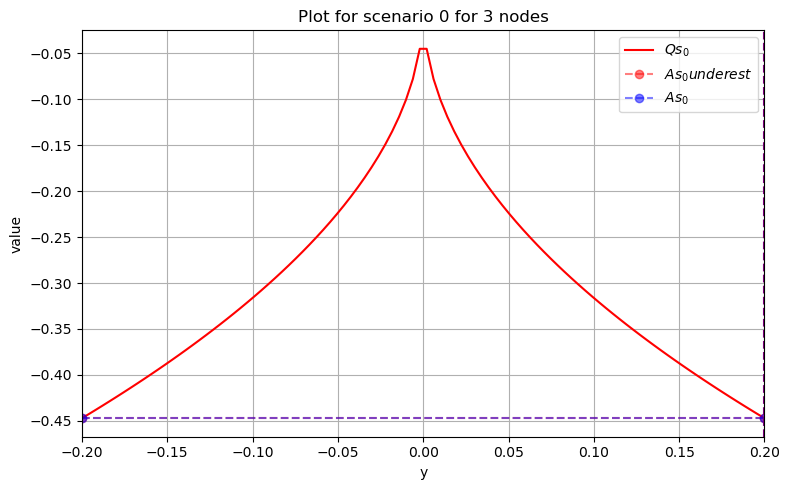

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0
ms is  -0.4472135954999579


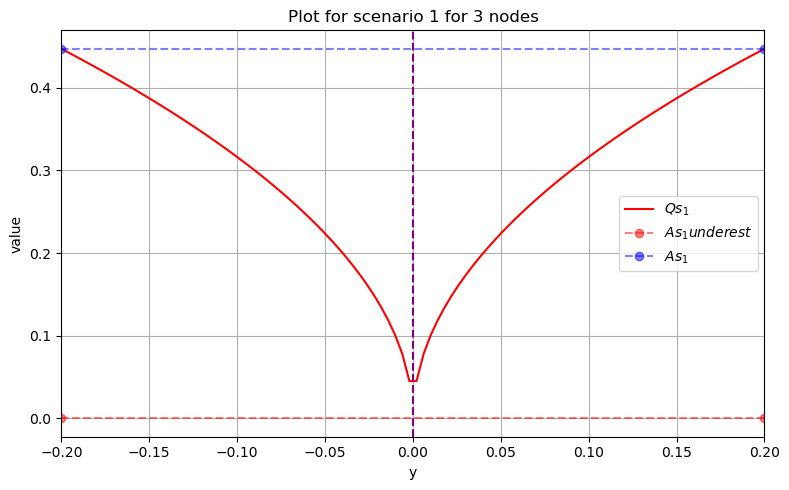

 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


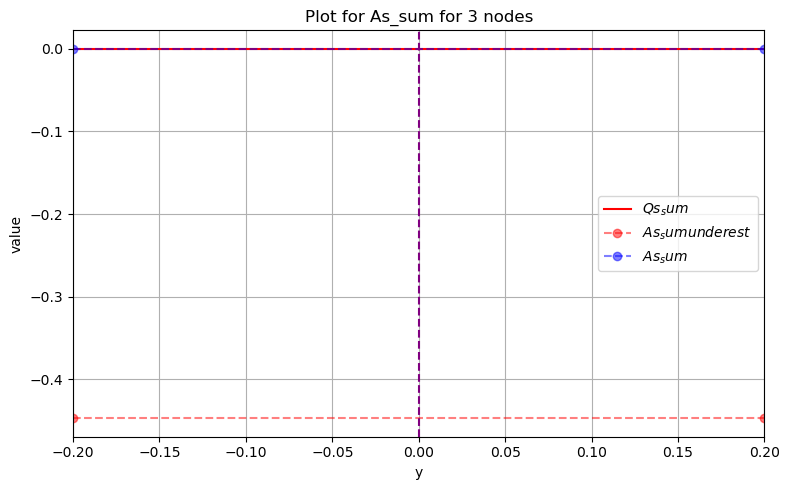

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-5.551115123125783e-17, -0.4472135954999579] -0.447213595499958
new node choosen from ms
new node is 0.0
Current As_min is -0.447213595499958
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.05000837522442001
ms is  -0.11180340861905139


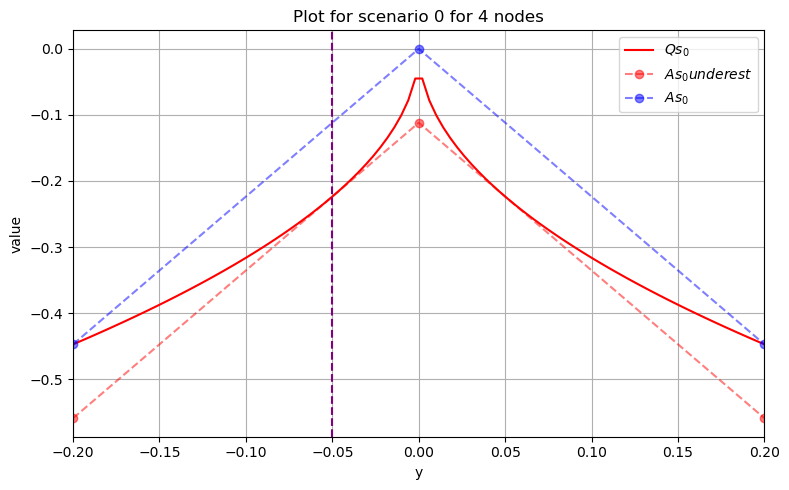

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.2
ms is  -8.193033473880007e-10


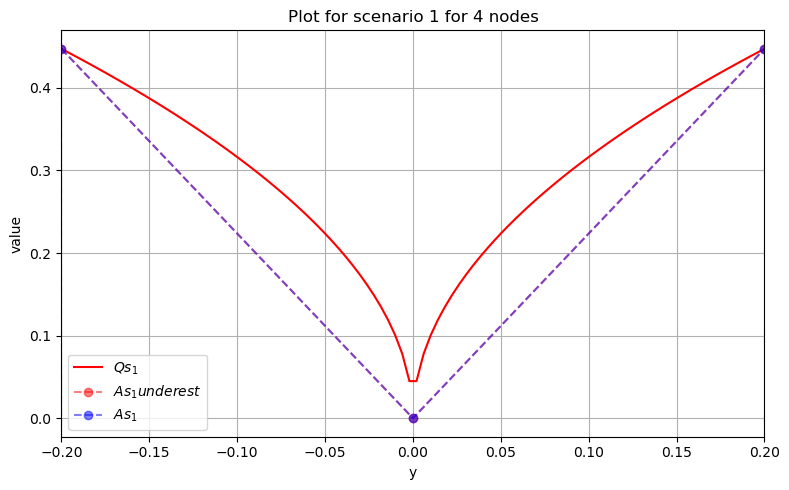

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


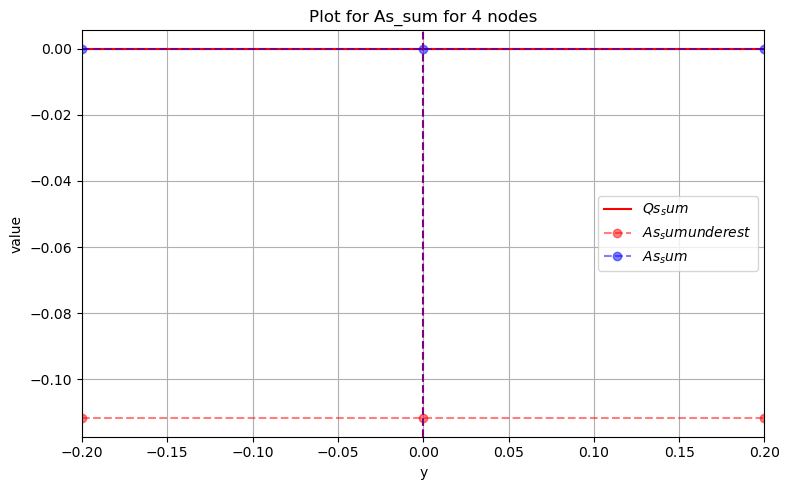

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.11180340861905139, -8.193033473880007e-10] -0.11180340943835473
new node choosen from ms
new node is -0.05000837522442001
Current As_min is -0.11180340943835473
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.05000682156975758
ms is  -0.1118034015248006


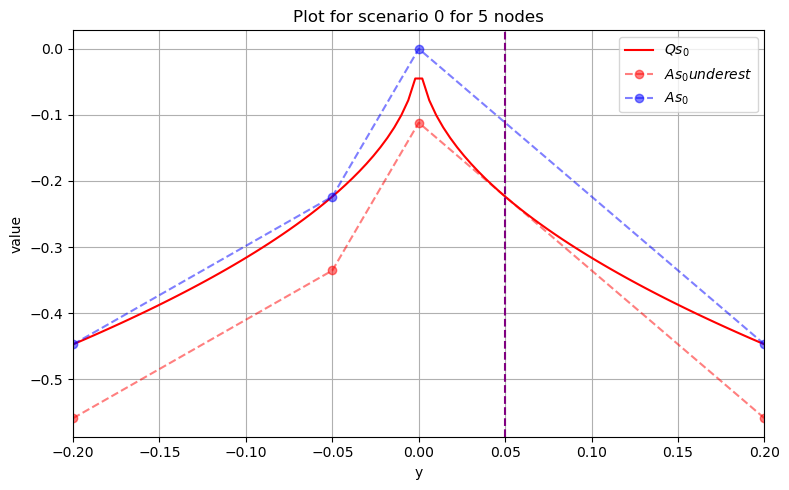

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.2
ms is  -5.008843340092994e-10


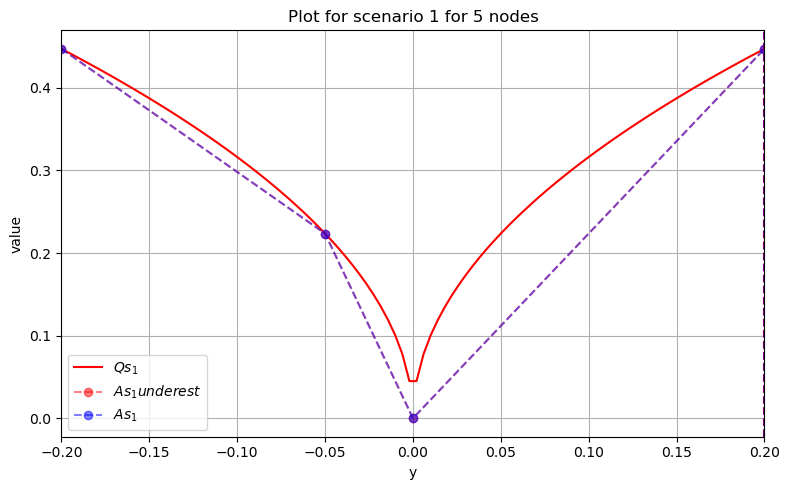

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


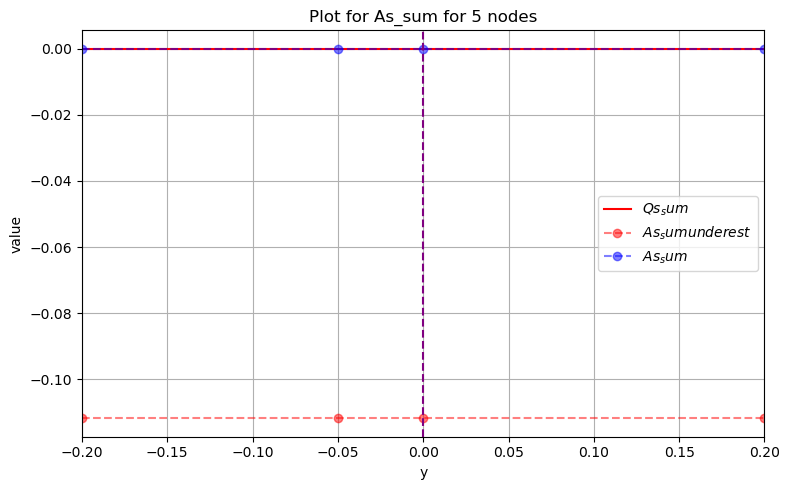

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.1118034015248006, -5.008843340092994e-10] -0.11180340202568494
new node choosen from ms
new node is 0.05000682156975758
Current As_min is -0.11180340202568494
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.0124993377222644
ms is  -0.05590646937290582


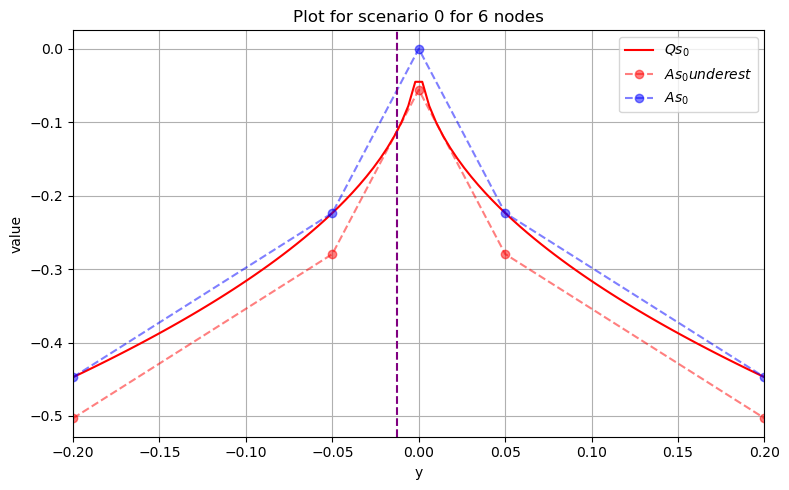

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.05000682156975758
ms is  -1.5157866628534578e-10


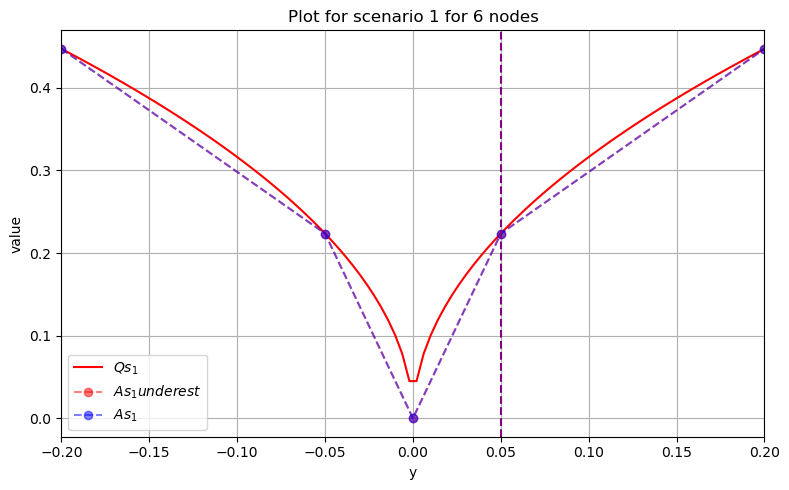

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


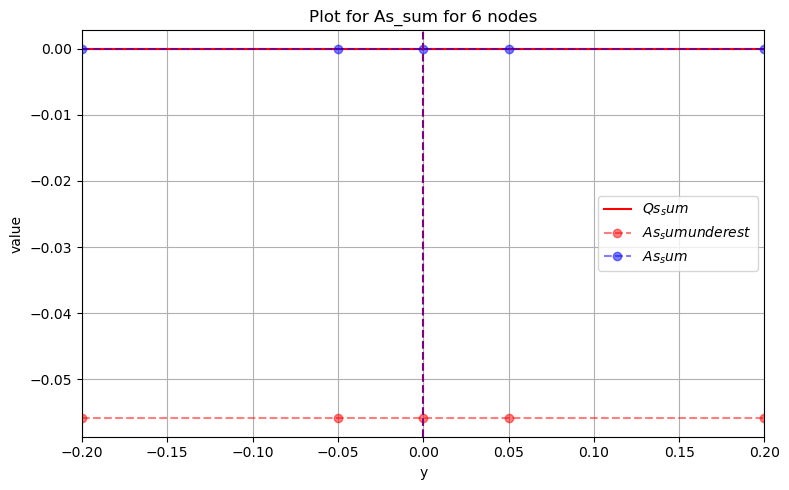

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.05590646937290582, -1.5157866628534578e-10] -0.055906469524484484
new node choosen from ms
new node is -0.0124993377222644
Current As_min is -0.055906469524484484
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.012496960615934407
ms is  -0.05590559106476693


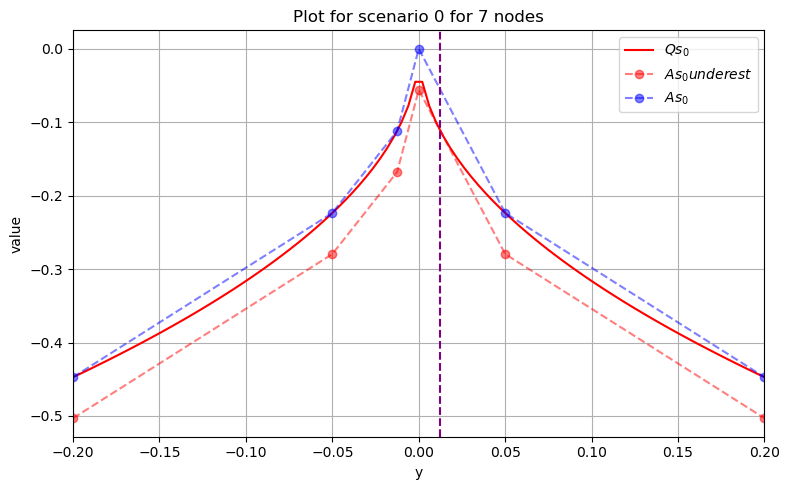

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.05000837522442001
ms is  -1.1382542408622243e-09


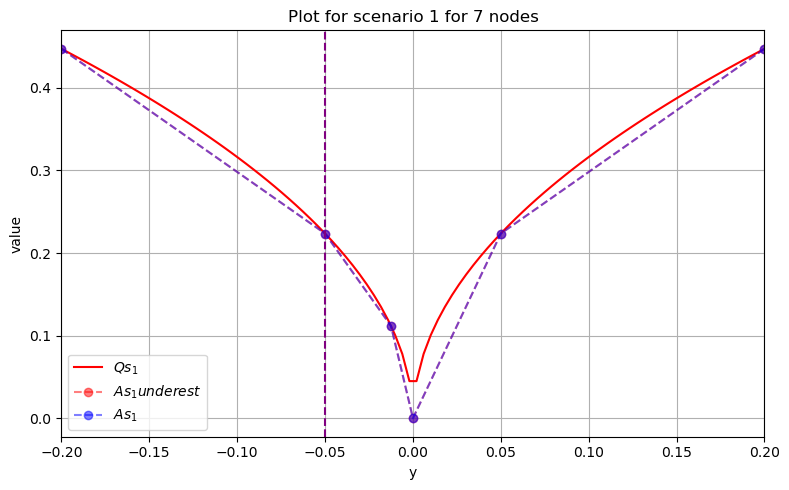

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


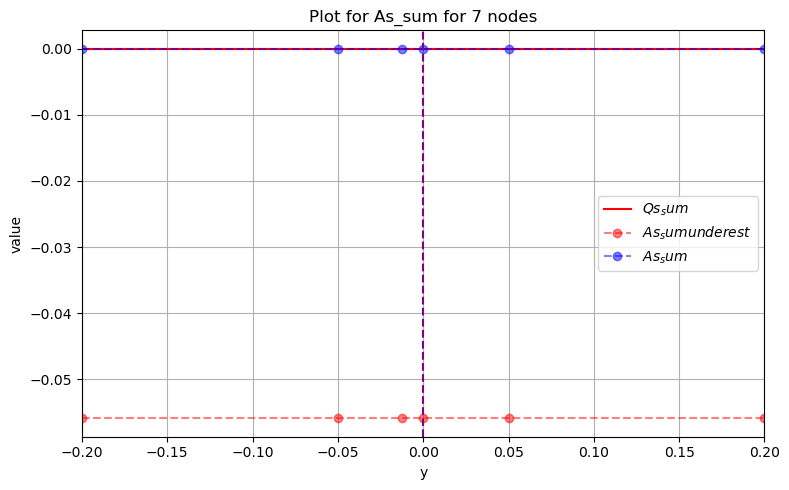

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.05590559106476693, -1.1382542408622243e-09] -0.05590559220302117
new node choosen from ms
new node is 0.012496960615934407
Current As_min is -0.05590559220302117
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.0031155011874327604
ms is  -0.027950902329018642


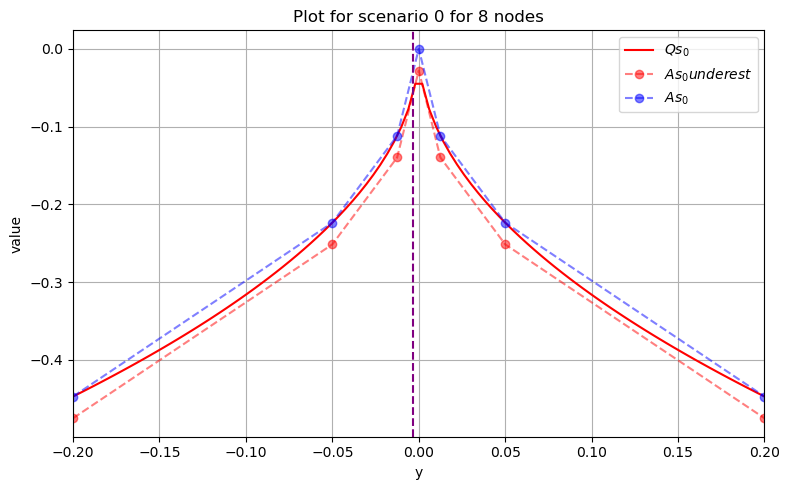

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.05000682156975758
ms is  -1.1379343578532541e-09


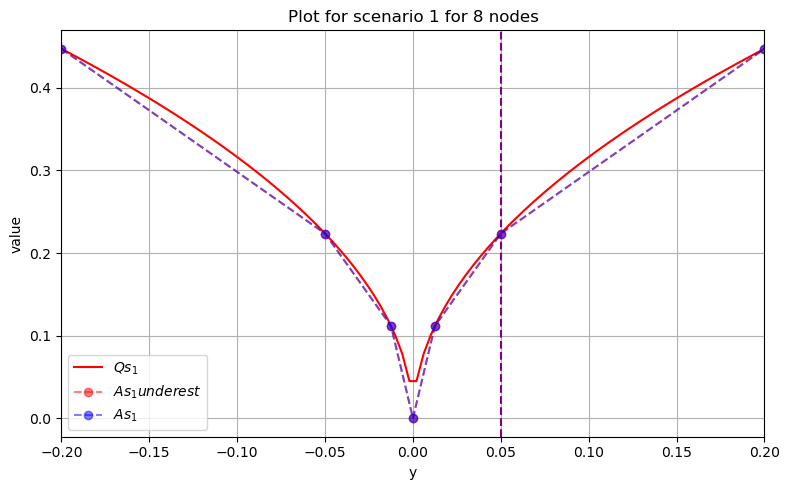

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


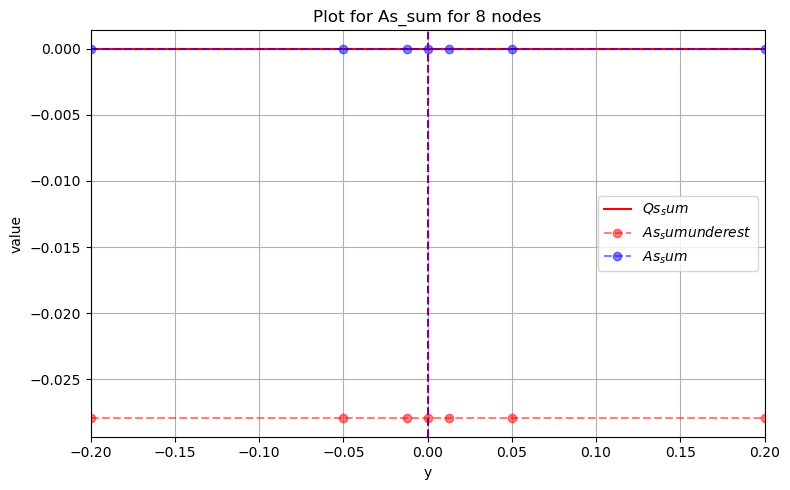

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.027950902329018642, -1.1379343578532541e-09] -0.027950903466953
new node choosen from ms
new node is -0.0031155011874327604
Current As_min is -0.027950903466953
*****************************************

##################################################
##################################################
Start adding node  9
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0031248380367812295
ms is  -0.027948571330653336


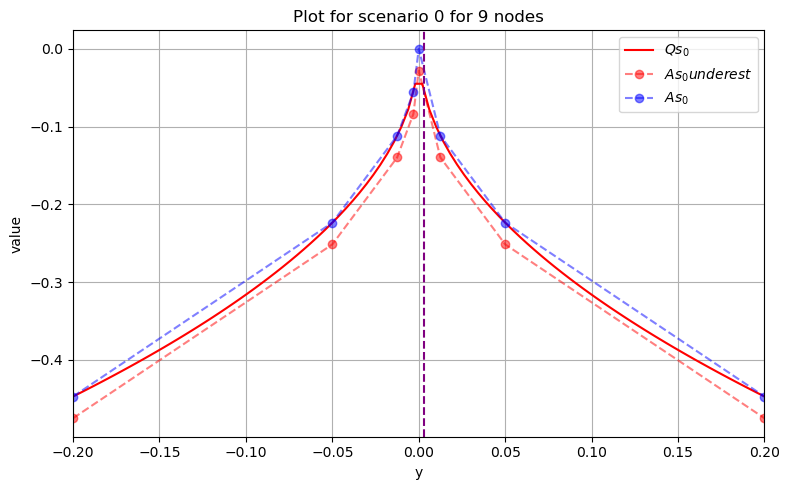

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.05000682156975758
ms is  -1.1379343578532541e-09


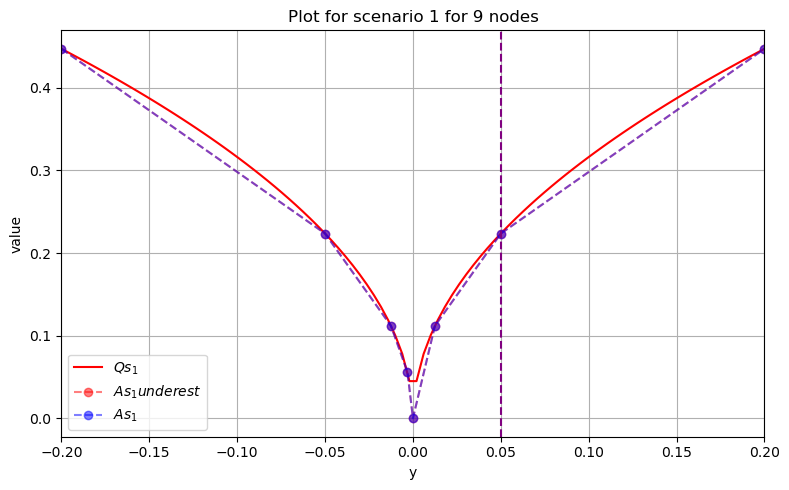

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


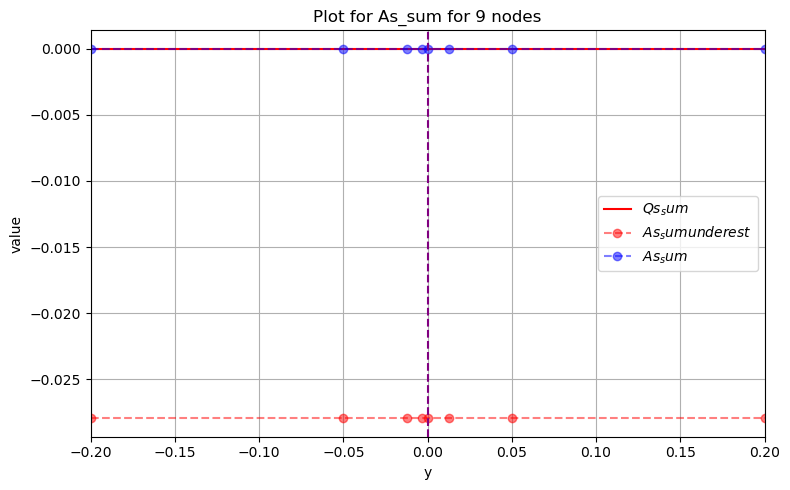

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.027948571330653336, -1.1379343578532541e-09] -0.027948572468587694
new node choosen from ms
new node is 0.0031248380367812295
Current As_min is -0.027948572468587694
*****************************************

##################################################
##################################################
Start adding node  10
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.11249581559304232
ms is  -0.018630937046740792


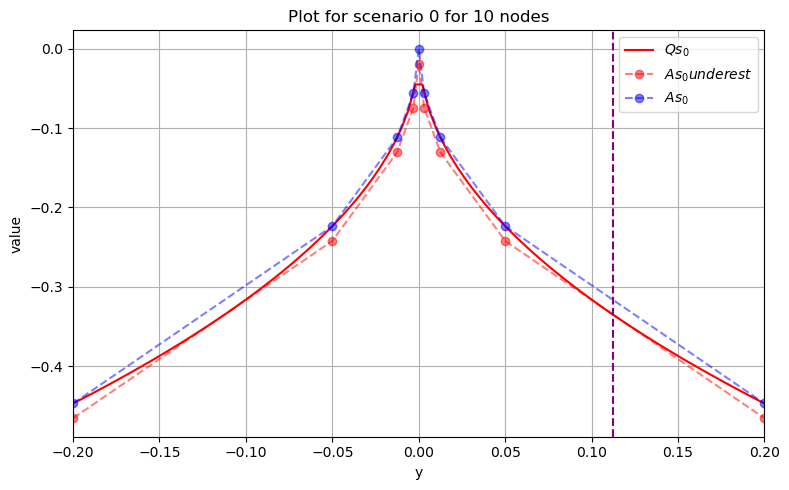

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.05000682156975758
ms is  -1.1379343578532541e-09


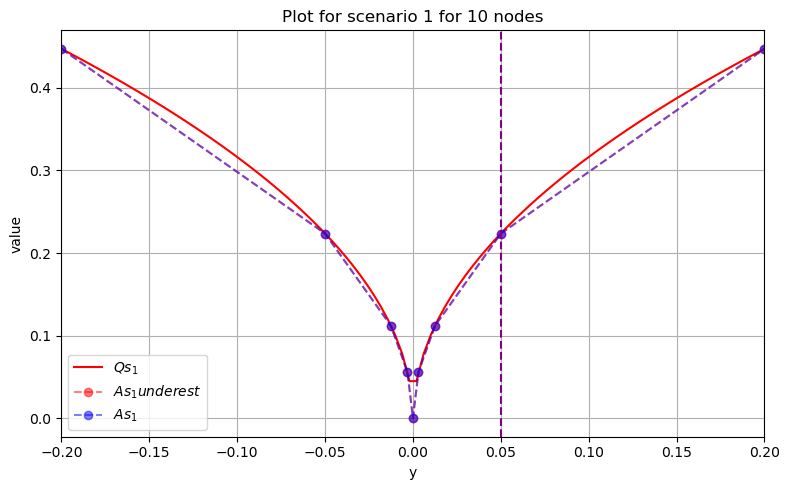

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


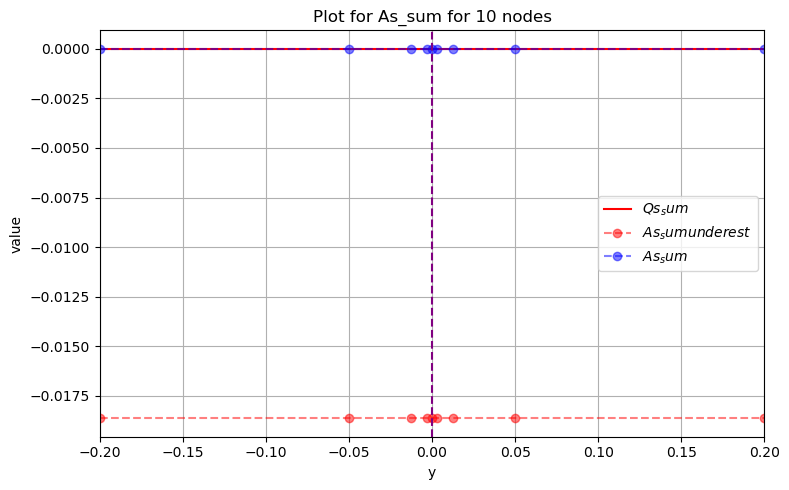

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.018630937046740792, -1.1379343578532541e-09] -0.01863093818467515
new node choosen from ms
new node is 0.11249581559304232
Current As_min is -0.01863093818467515
*****************************************

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.


In [20]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# make delta list
result = nc_underest([ylb, yub],model_list, 10, solver, True, v_list)

C:\Users\pc\AppData\Local\Temp\ipykernel_10704\1387504091.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


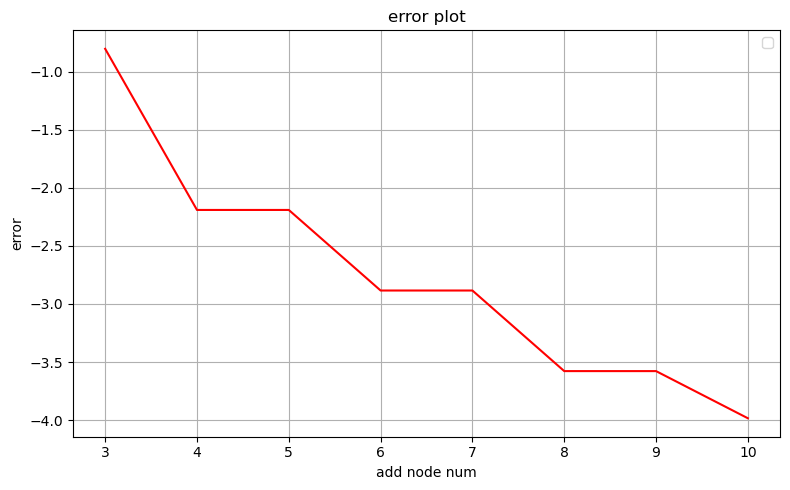

      adds     errors
----------------------
         3 0.447213595500
         4 0.111803409438
         5 0.111803402026
         6 0.055906469524
         7 0.055905592203
         8 0.027950903467
         9 0.027948572469
        10 0.018630938185


In [21]:
adds = result[-1][0]
true_min_val = 0
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
plt.plot(adds, np.log(errors), color='red')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

# P1 10 nodes

In [6]:
# build function for each scenario 
def v_1(y):  
    if y < 5 or y > 20:
        return float('inf')
    elif 5 <= y < 6.53:
        return 2.5 * y - 10 * (2 * y - 10)
    else:
        return 2.5 * y - 10 * 20 / y


def v_2(y): 
    if y < 2.22 or y > 20:
        return float('inf')
    elif 2.22 <= y < 3.49:
        return 2.5 * y - 20 * (4.5 * y - 10)
    else:
        return 2.5 * y - 20 * 20 / y

v_list = [v_1, v_2]

# set up parameters and solvers
n_samples = 10
add_node_num=5
ylb = 6
yub = 15
tolerance=1e-9

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))        ##################################
m1.c1 = Constraint(expr= 2*m1.y-m1.x1>=10)
m1.c2 = Constraint(expr= m1.x1 * m1.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m1.obj_expr = Expression(expr=2.5*m1.y - 10*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var(bounds=(0, None))        ##################################
m2.c1 = Constraint(expr= 4.5*m2.y-m2.x2>=10)
m2.c2 = Constraint(expr= m2.x2 * m2.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m2.obj_expr = Expression(expr=2.5*m2.y - 20*m2.x2)

model_list = [m1, m2]

result = nc_underest([ylb, yub],model_list,10,True, v_list)

ERROR: Solver (gurobi) returned non-zero return code (1)
ERROR: Solver log: Traceback (most recent call last):
      File "<stdin>", line 5, in <module> File "D:\Anaconda\lib\site-
      packages\pyomo\solvers\plugins\solvers\GUROBI_RUN.py", line 62, in
      gurobi_run
        model = read(model_file)
                ^^^^^^^^^^^^^^^^
      File "src\\gurobipy\\gurobi.pxi", line 336, in gurobipy._core.read File
      "src\\gurobipy\\gurobi.pxi", line 116, in gurobipy._core.gurobi.read
      File "src\\gurobipy\\gurobi.pxi", line 60, in
      gurobipy._core.gurobi._getdefaultenv File "src\\gurobipy\\env.pxi", line
      108, in gurobipy._core.Env.__init__
    gurobipy._exception.GurobiError: No Gurobi license found (user pc, host
    DESKTOP-PPPCF27, hostid 3ef6820a, cores 10)


ApplicationError: Solver (gurobi) did not exit normally

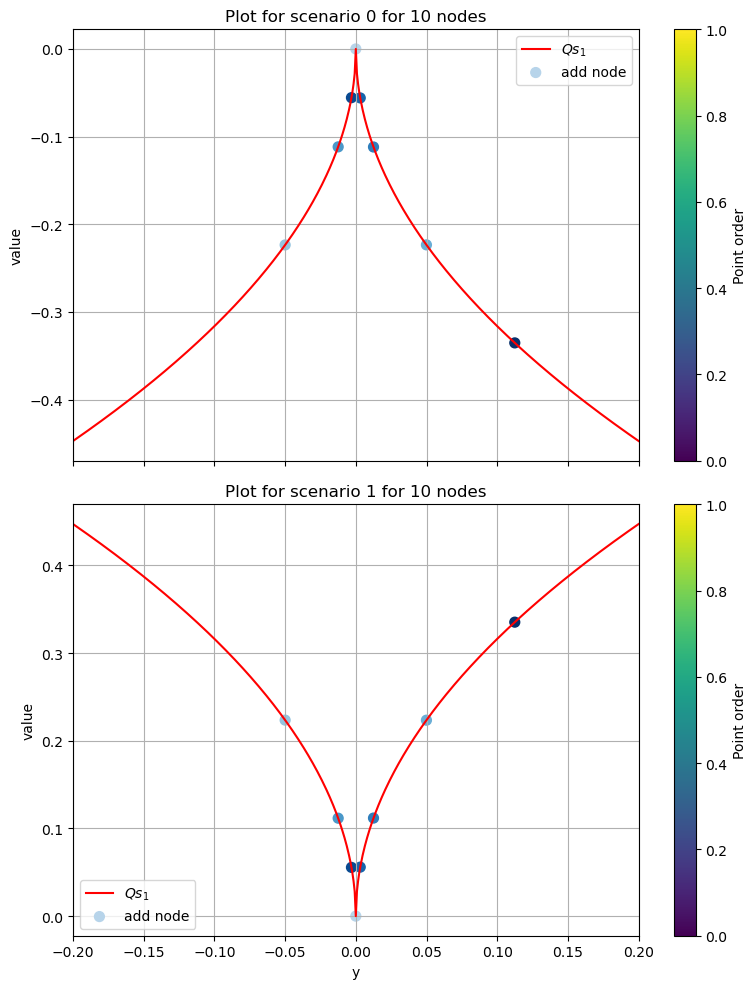

In [97]:
y_vals = np.linspace(ylb, yub, 501)
N = 2
Qs_vals_list = [None] * N
for i in range(N):
    Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
Qs_vals_sum = Qs_arr.sum(axis=0)




adds = result[-1][0]
add_node_history = result[-1][2]
v1_node = [v_list[0](y) for y in add_node_history]
v2_node = [v_list[1](y) for y in add_node_history]
#colors = plt.cm.viridis(np.linspace(0, 1, len(add_node_history)))
colors = plt.cm.Blues(np.linspace(0.3, 1, len(add_node_history)))




fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=False)
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap)
axes[0].plot(y_vals, Qs_vals_list[0], label=fr'$Qs_{i}$', color='red')
sc0 = axes[0].scatter(add_node_history, v1_node, c=colors, s=50, label='add node')
axes[0].set_xlim(ylb, yub)
axes[0].set_ylabel('value')
axes[0].set_title("Plot for scenario 0 for 10 nodes")
axes[0].legend()
axes[0].grid(True)
fig.colorbar(sm, ax=axes[0], label='Point order')
axes[1].plot(y_vals, Qs_vals_list[1], label=fr'$Qs_{i}$', color='red')
sc1 = axes[1].scatter(add_node_history, v2_node, c=colors, s=50, label='add node')
axes[1].set_xlim(ylb, yub)
axes[1].set_xlabel('y')
axes[1].set_ylabel('value')
axes[1].set_title("Plot for scenario 1 for 10 nodes")
axes[1].legend()
axes[1].grid(True)
fig.colorbar(sm, ax=axes[1], label='Point order')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


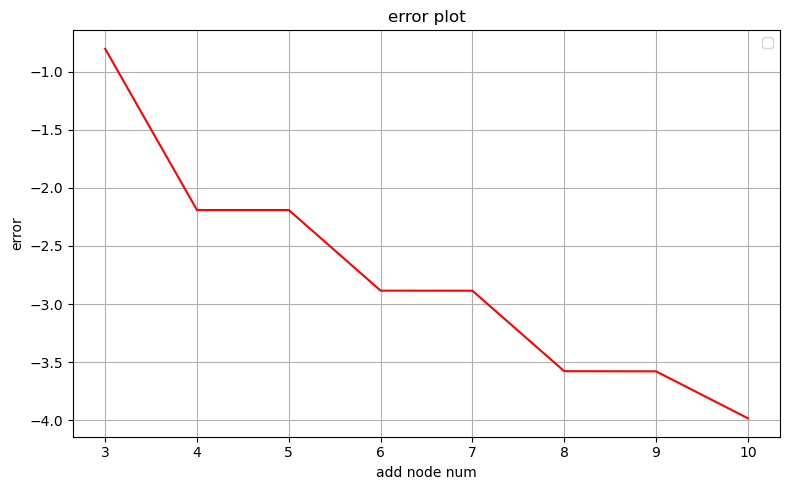

      adds     errors
----------------------
         3 0.447213595500
         4 0.111803406155
         5 0.111803368951
         6 0.055891001358
         7 0.055871873800
         8 0.027963820094
         9 0.027923593409
        10 0.018657128032


In [98]:
adds = result[-1][0]
true_min_val = 0
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
plt.plot(adds, np.log(errors), color='red')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

# P1 20 nodes

The goal is to get  20  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.2
ms is  0.0


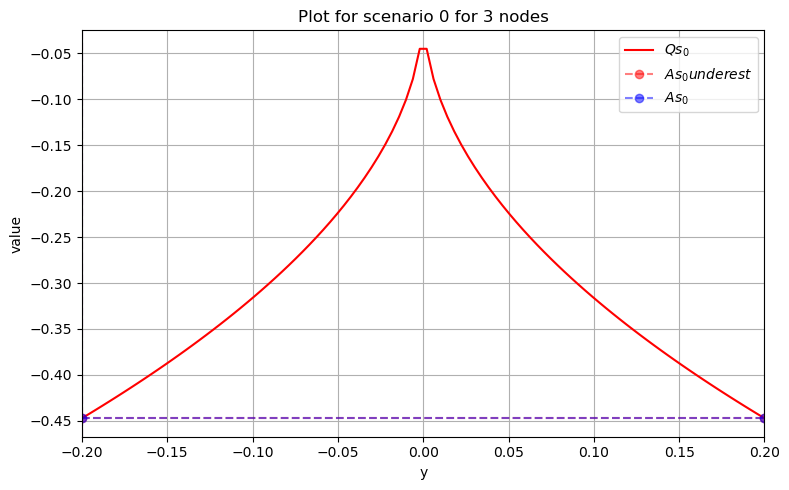

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0
ms is  -0.4472135954999579


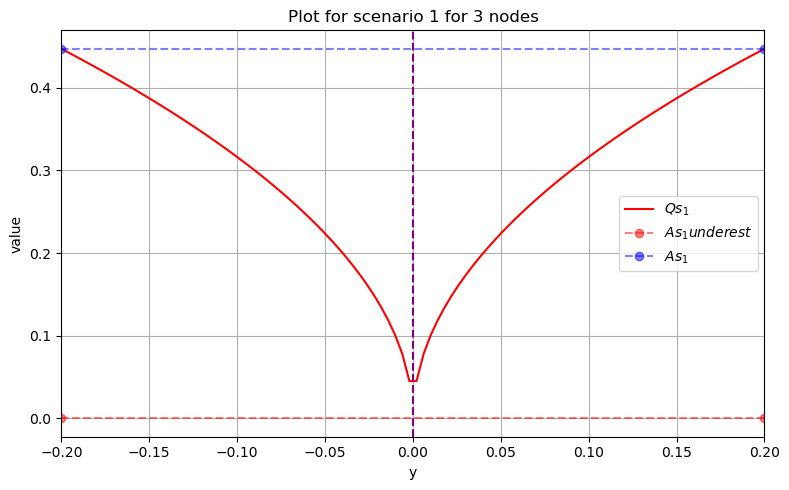

 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


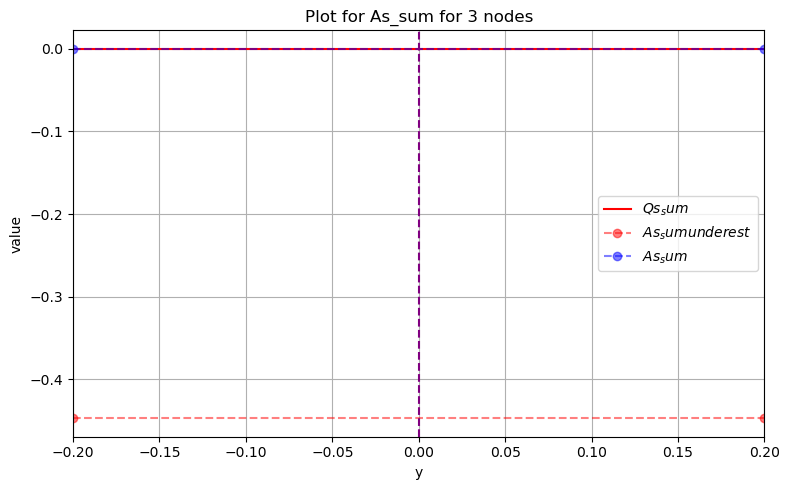

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0, -0.4472135954999579] -0.4472135954999579
new node choosen from ms
new node is 0.0
Current As_min is -0.4472135954999579
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.04998092776511266
ms is  -0.11180340533848798


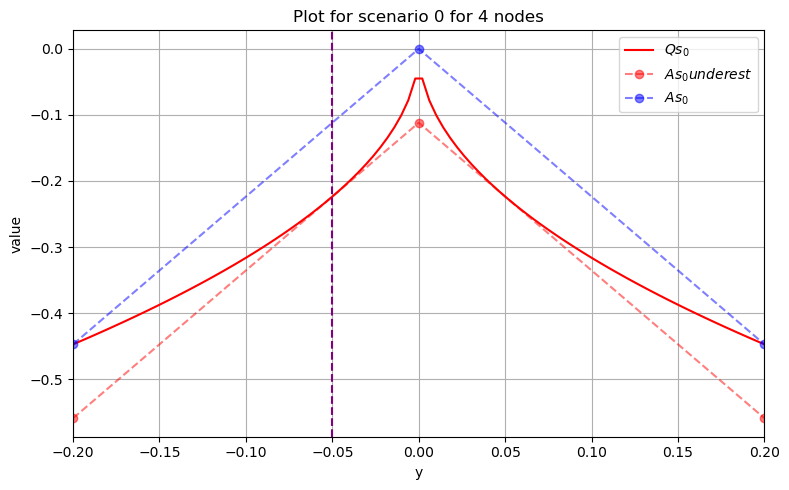

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.2
ms is  -8.166172182910714e-10


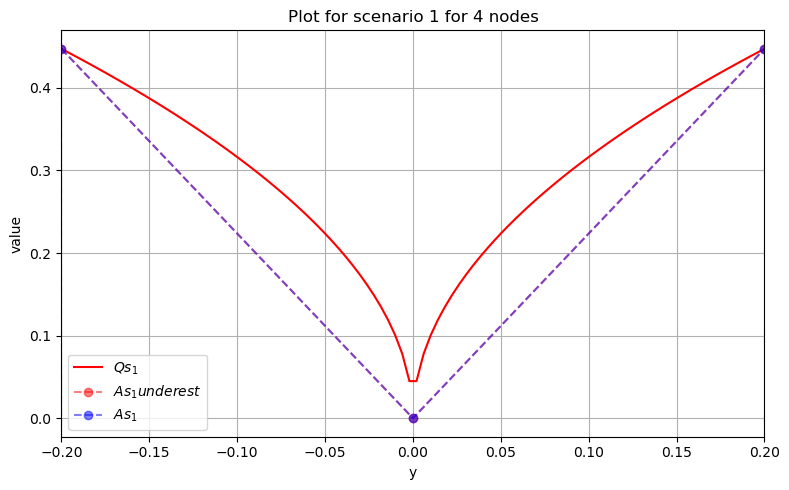

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


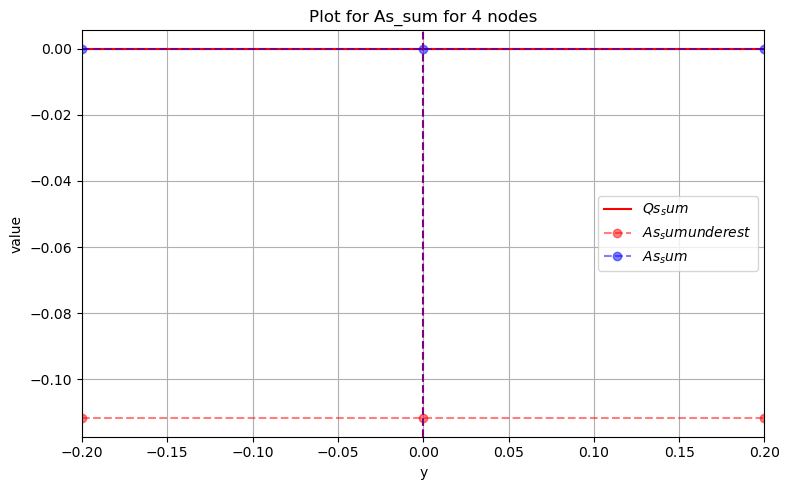

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.11180340533848798, -8.166172182910714e-10] -0.1118034061551052
new node choosen from ms
new node is -0.04998092776511266
Current As_min is -0.1118034061551052
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.04994661012497079
ms is  -0.1118033669886418


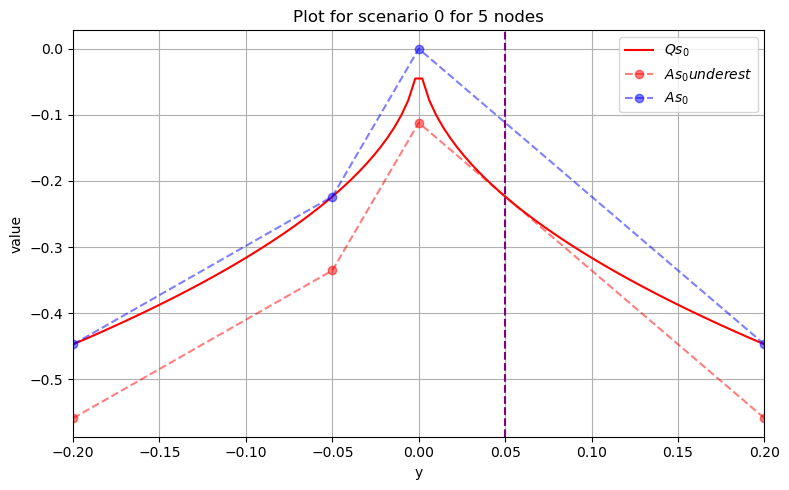

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.04998092776511263
ms is  -1.96253091555576e-09


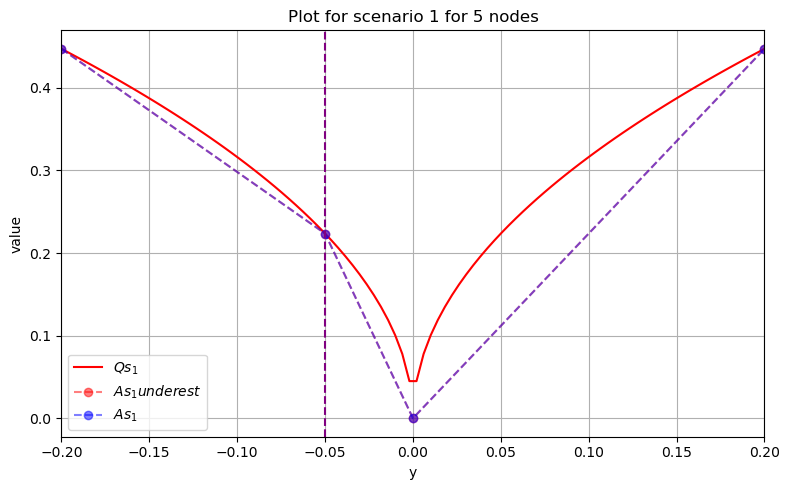

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.04998092776511266
error is  0.0


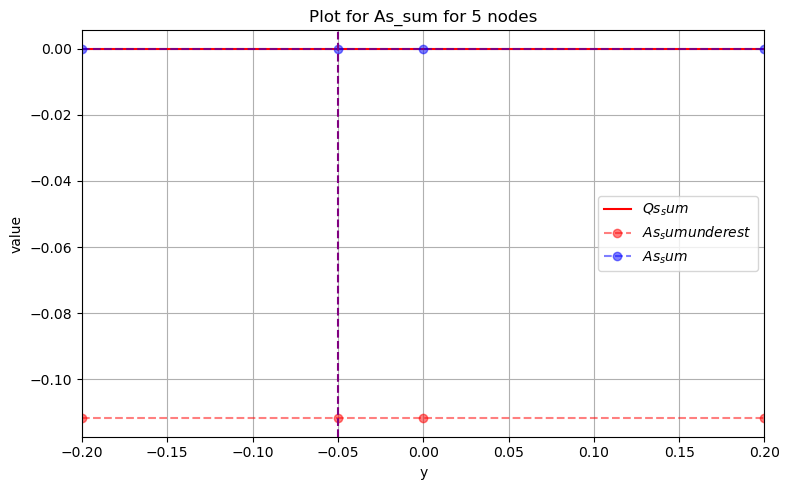

Sum *****************************************
error at y_star is  0.0
y_star is  -0.04998092776511266
ms_list and sum_ms is  [-0.1118033669886418, -1.96253091555576e-09] -0.11180336895117271
new node choosen from ms
new node is 0.04994661012497079
Current As_min is -0.11180336895117271
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.012474947219599651
ms is  -0.05589099986318791


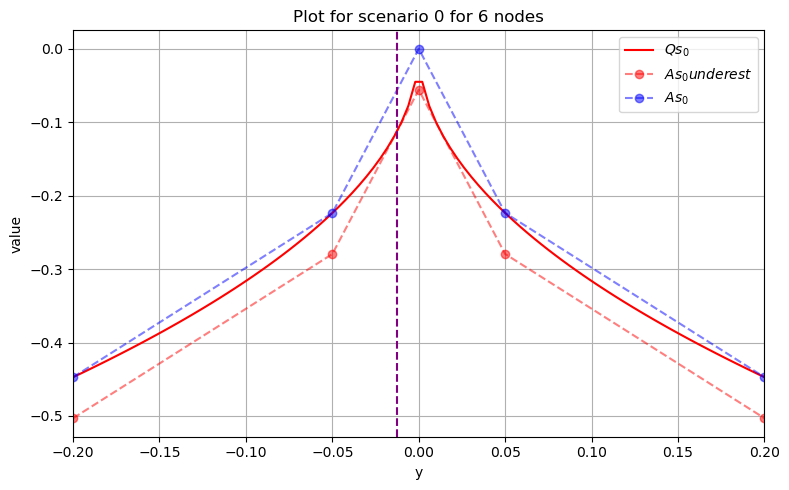

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.04994661012497079
ms is  -1.4947386384189798e-09


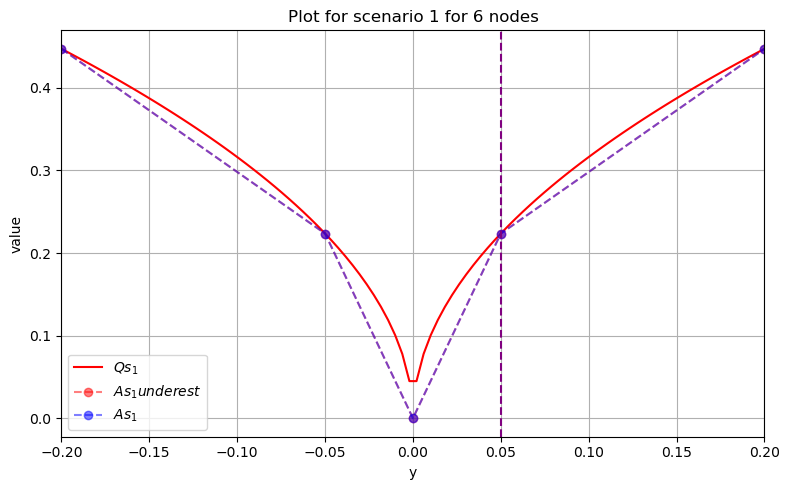

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


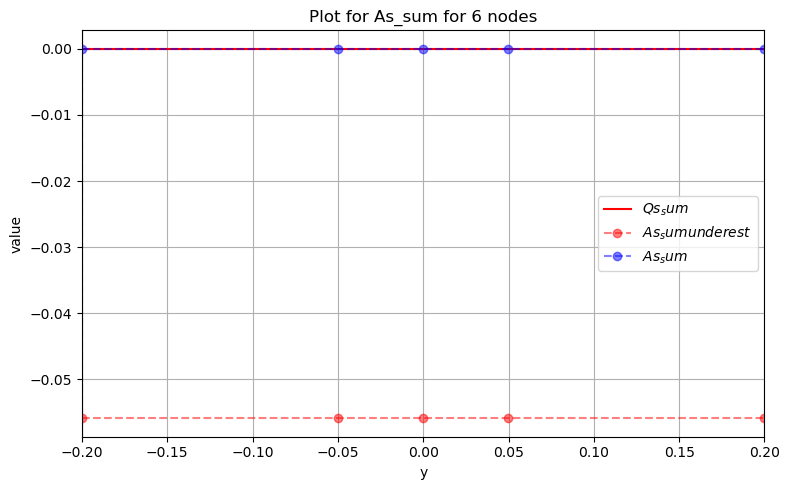

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.05589099986318791, -1.4947386384189798e-09] -0.055891001357926545
new node choosen from ms
new node is -0.012474947219599651
Current As_min is -0.055891001357926545
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.012510611581006229
ms is  -0.055871873170053855


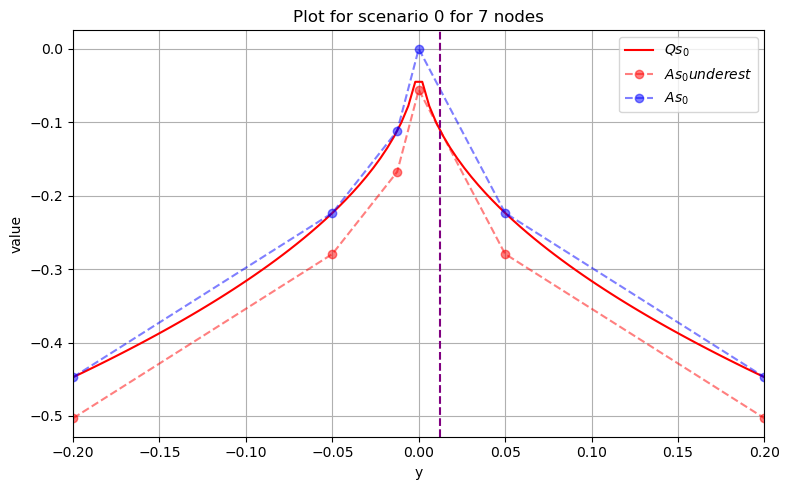

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.04998092776511266
ms is  -6.30302809945249e-10


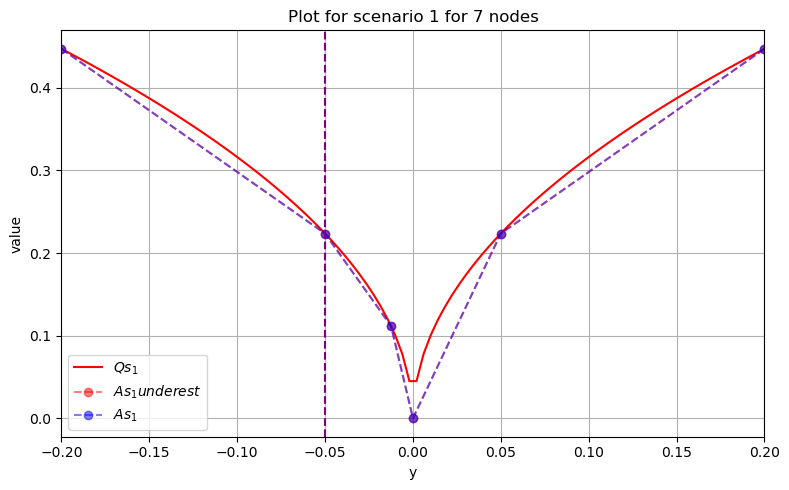

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


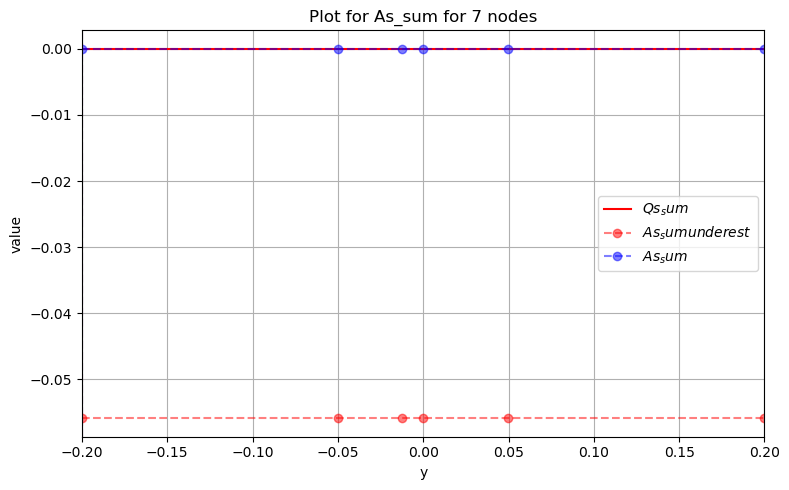

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.055871873170053855, -6.30302809945249e-10] -0.055871873800356665
new node choosen from ms
new node is 0.012510611581006229
Current As_min is -0.055871873800356665
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0031232030575204647
ms is  -0.02796381786683955


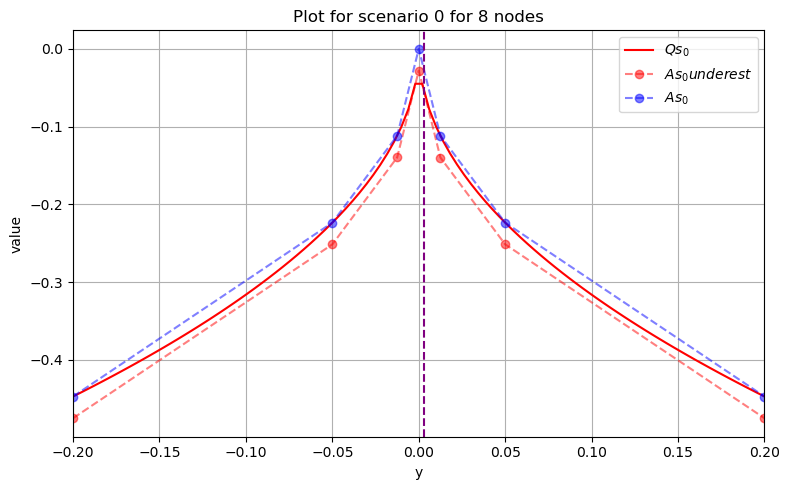

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.04994661012497079
ms is  -2.2272207411688782e-09


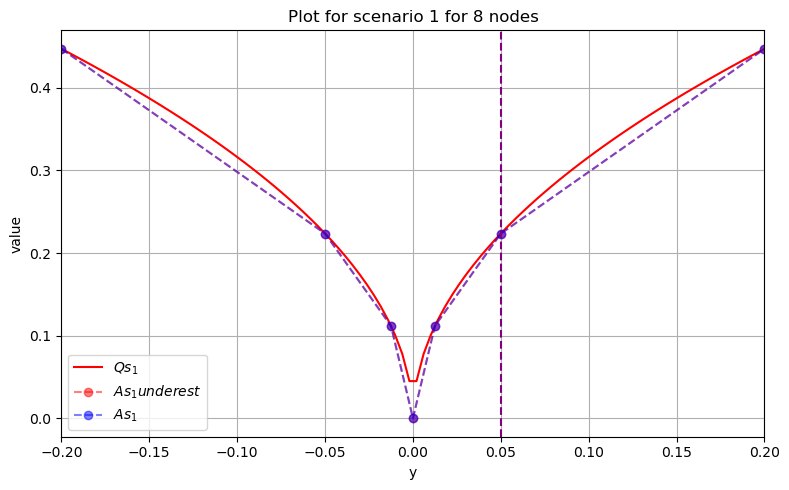

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


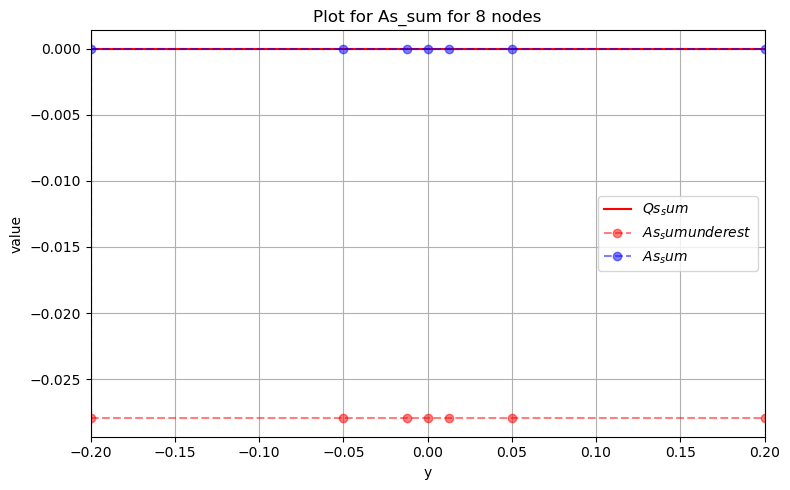

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.02796381786683955, -2.2272207411688782e-09] -0.02796382009406029
new node choosen from ms
new node is 0.0031232030575204647
Current As_min is -0.02796382009406029
*****************************************

##################################################
##################################################
Start adding node  9
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.0030885591670721363
ms is  -0.027923591862646535


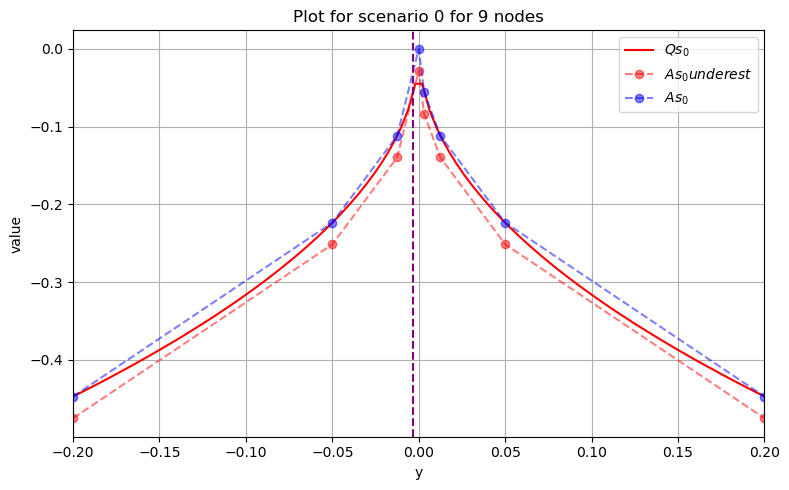

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.012510611581006229
ms is  -1.5459850483123816e-09


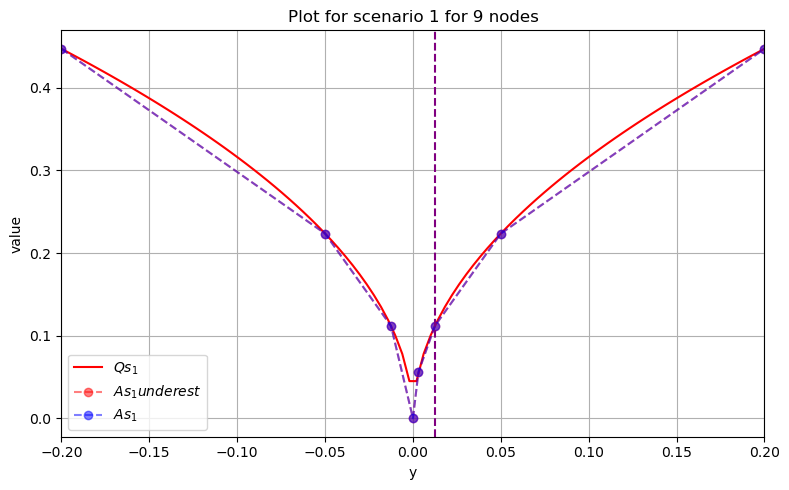

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


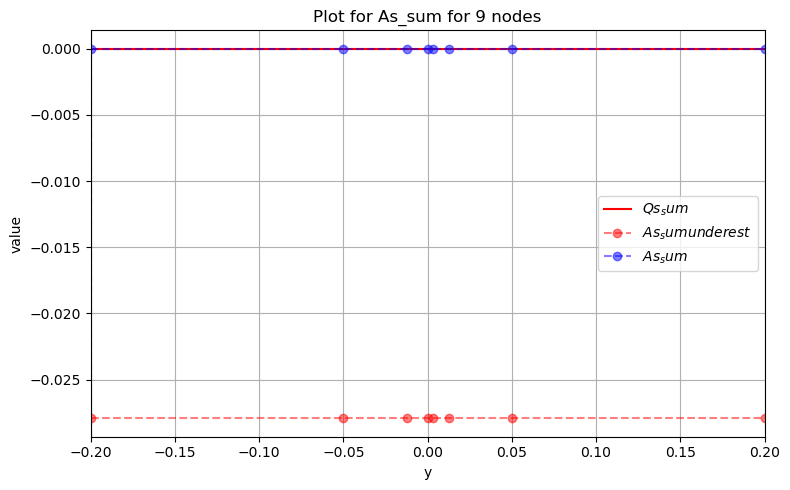

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.027923591862646535, -1.5459850483123816e-09] -0.027923593408631583
new node choosen from ms
new node is -0.0030885591670721363
Current As_min is -0.027923593408631583
*****************************************

##################################################
##################################################
Start adding node  10
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.11242687232211532
ms is  -0.01865712527193275


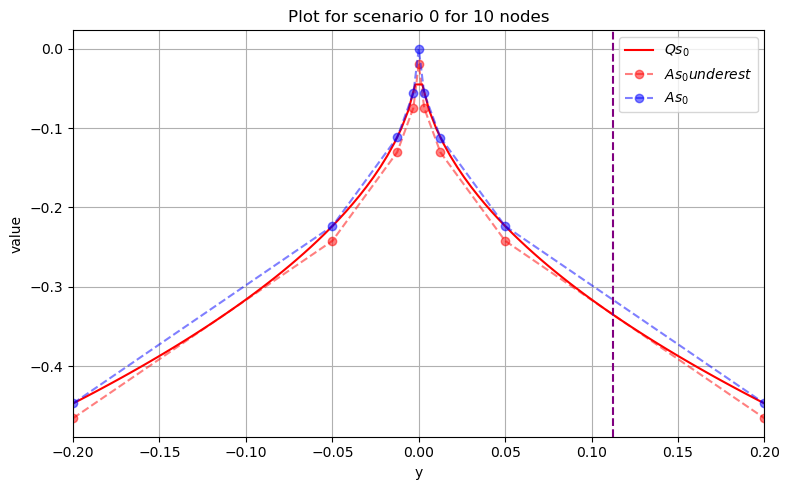

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0031232030575204647
ms is  -2.760528160228315e-09


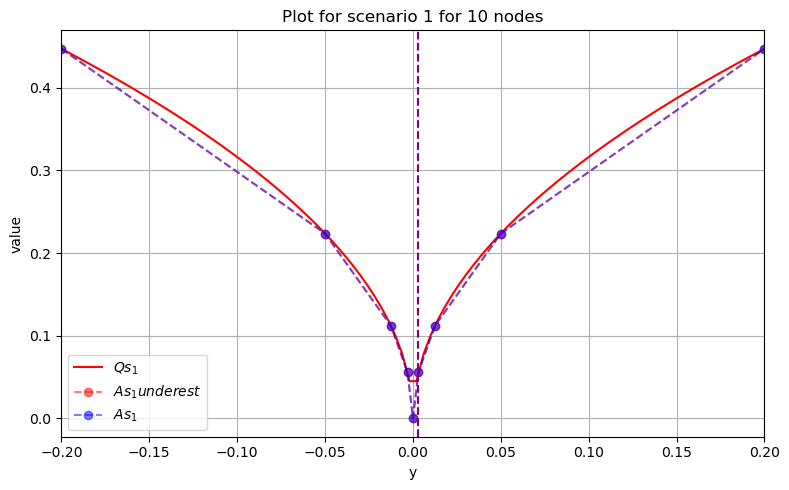

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


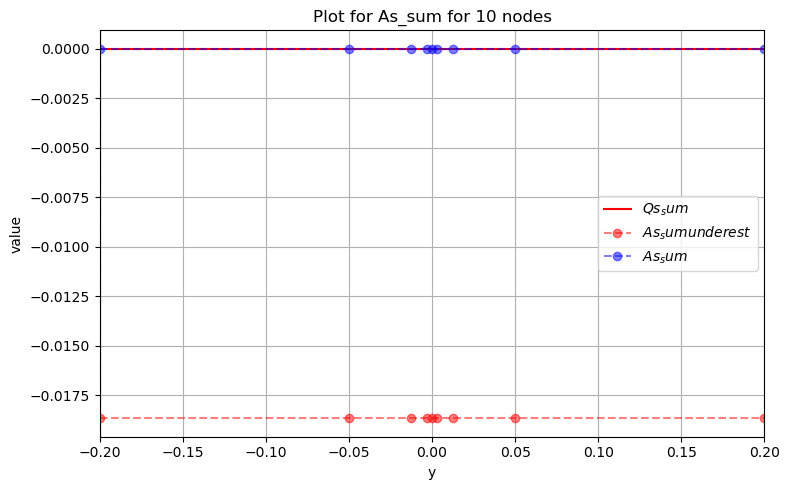

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.01865712527193275, -2.760528160228315e-09] -0.01865712803246091
new node choosen from ms
new node is 0.11242687232211532
Current As_min is -0.01865712803246091
*****************************************

##################################################
##################################################
Start adding node  11
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.11247758965027846
ms is  -0.018642197244144676


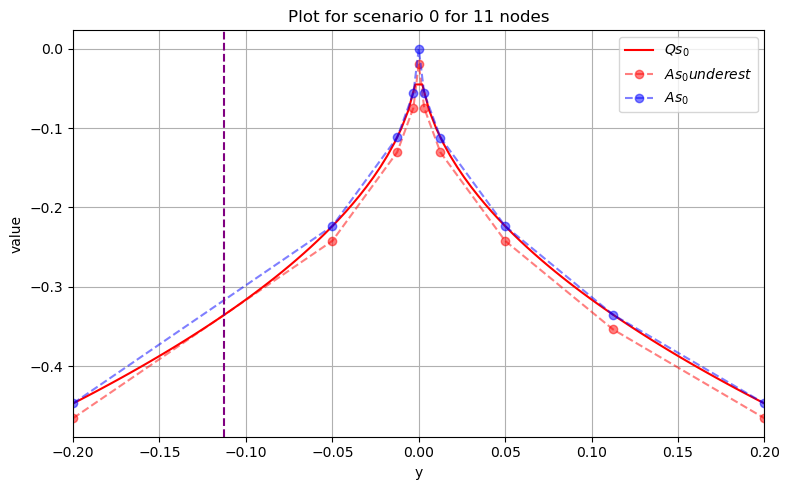

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0031232030575204647
ms is  -2.760528160228315e-09


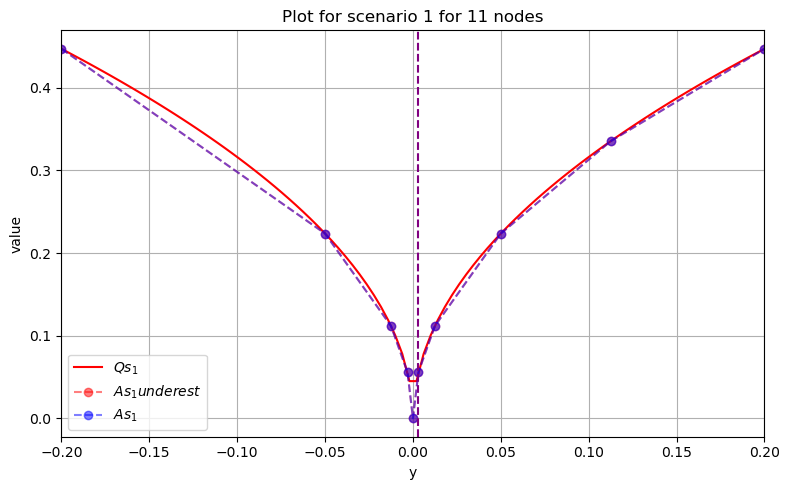

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


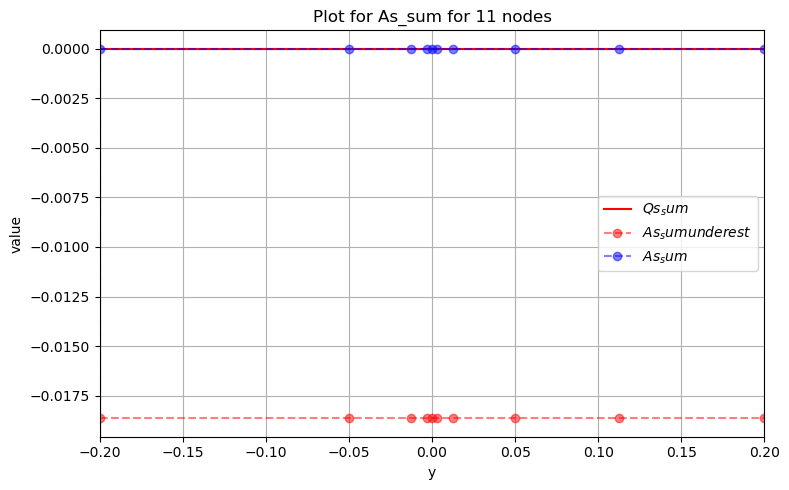

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.018642197244144676, -2.760528160228315e-09] -0.018642200004672836
new node choosen from ms
new node is -0.11247758965027846
Current As_min is -0.018642200004672836
*****************************************

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0007627778465109994
ms is  -0.013979757807998887


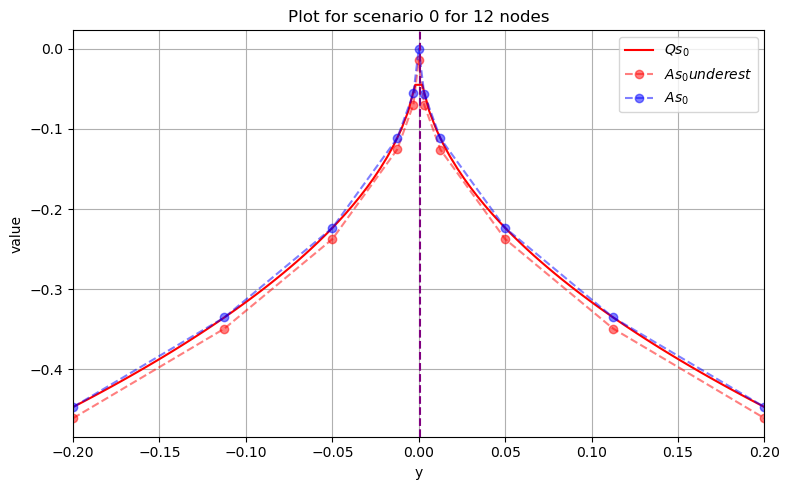

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0031232030575204647
ms is  -8.398939460585453e-09


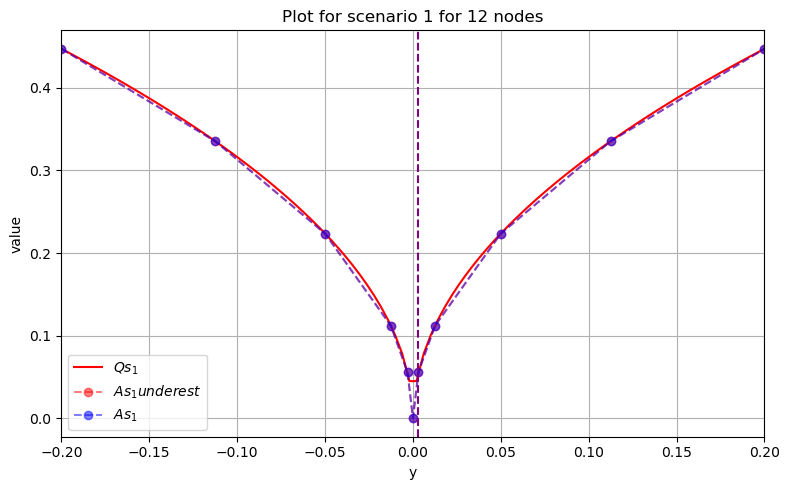

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


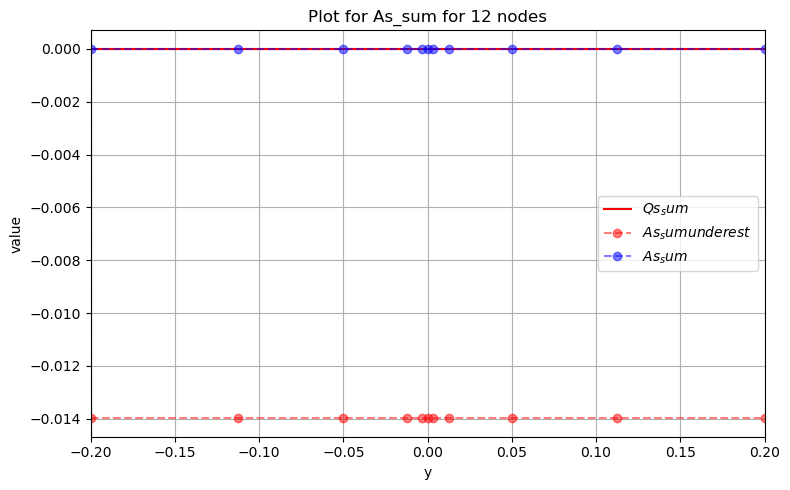

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.013979757807998887, -8.398939460585453e-09] -0.013979766206938348
new node choosen from ms
new node is 0.0007627778465109994
Current As_min is -0.013979766206938348
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.0007611127273406658
ms is  -0.013902387668886998


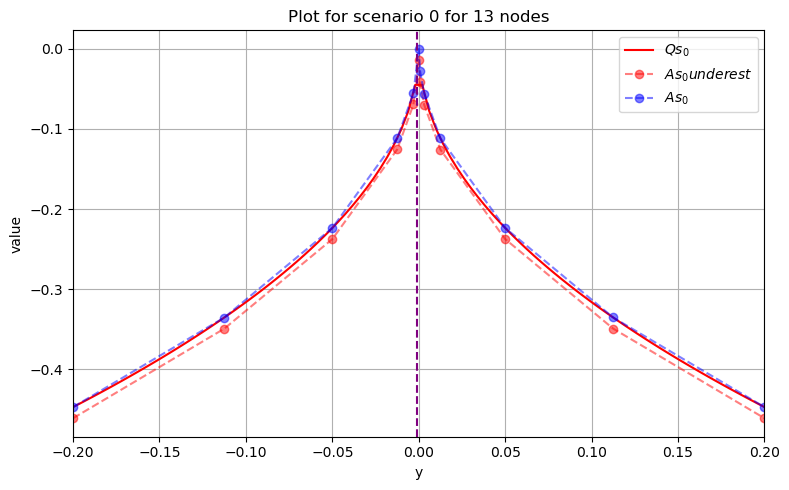

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.003088559167072127
ms is  -8.6606798122002e-09


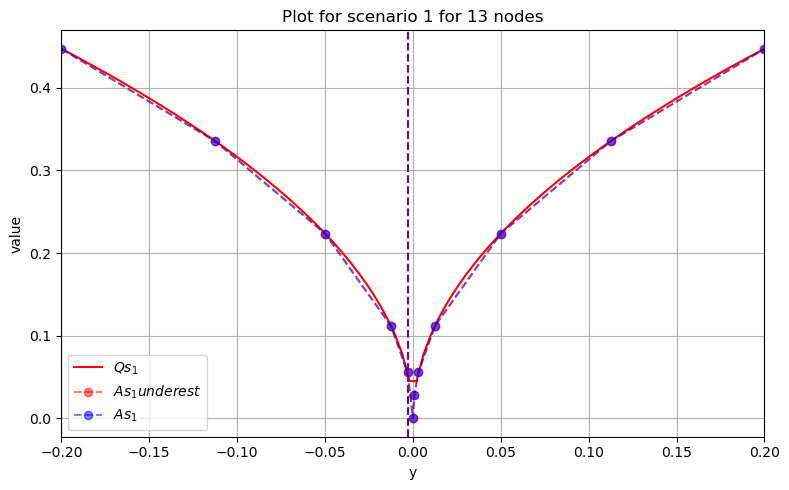

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.2
error is  0.0


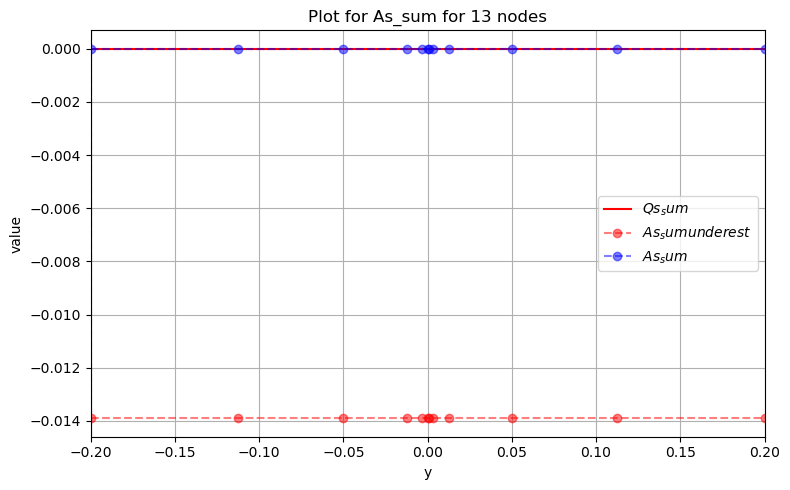

Sum *****************************************
error at y_star is  0.0
y_star is  -0.2
ms_list and sum_ms is  [-0.013902387668886998, -8.6606798122002e-09] -0.01390239632956681
new node choosen from ms
new node is -0.0007611127273406658
Current As_min is -0.01390239632956681
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.028074477039604348
ms is  -0.009332833615180863


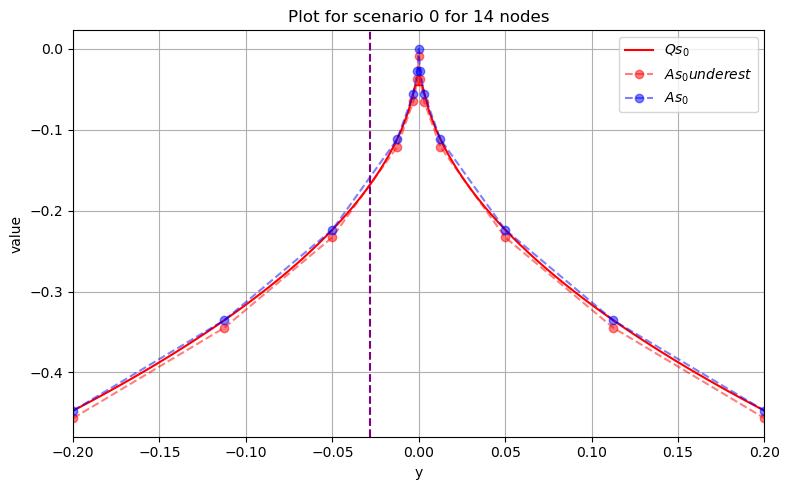

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0007627778465109994
ms is  -1.0124742242517693e-08


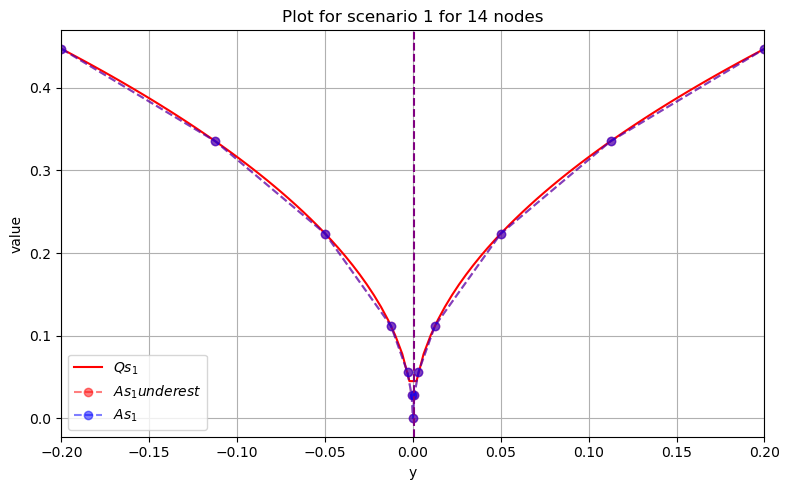

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


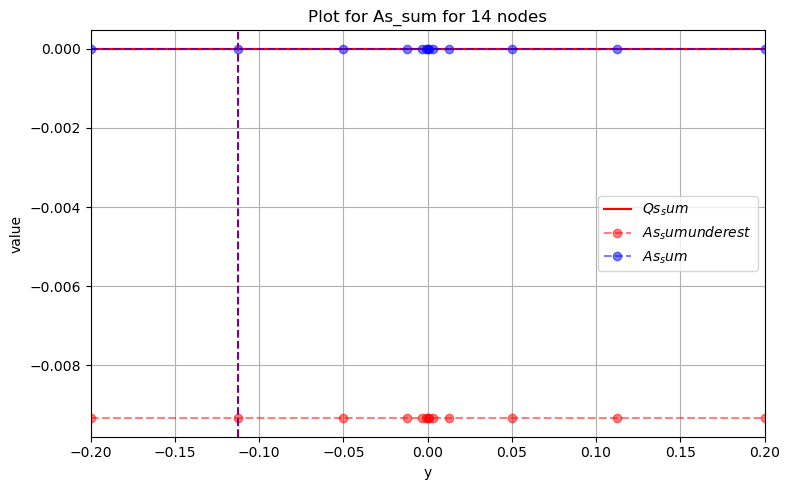

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.009332833615180863, -1.0124742242517693e-08] -0.009332843739923106
new node choosen from ms
new node is -0.028074477039604348
Current As_min is -0.009332843739923106
*****************************************

##################################################
##################################################
Start adding node  15
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.028159114552134955
ms is  -0.009291097472953064


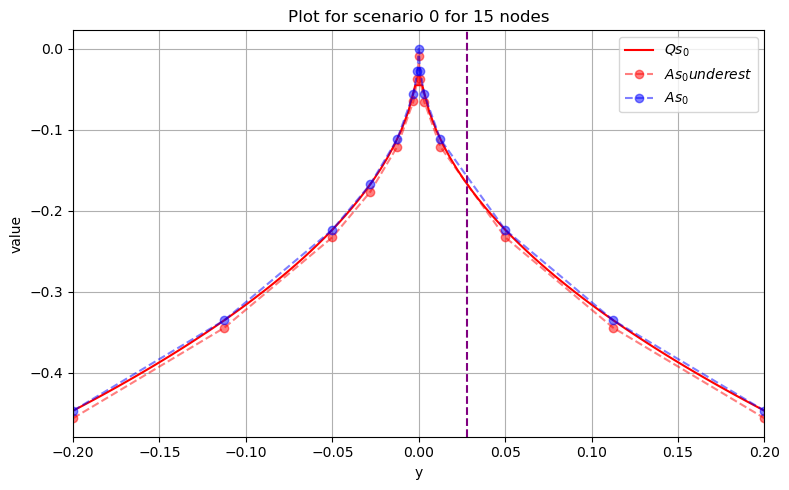

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0007611127273406658
ms is  -1.3239937601133844e-08


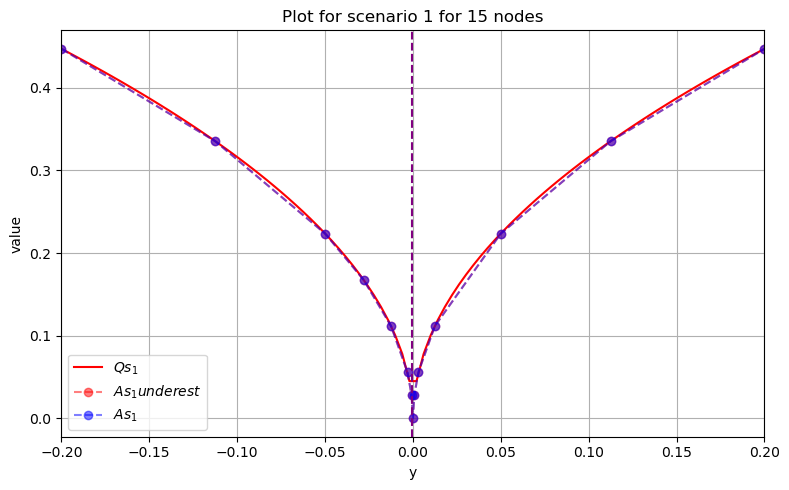

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


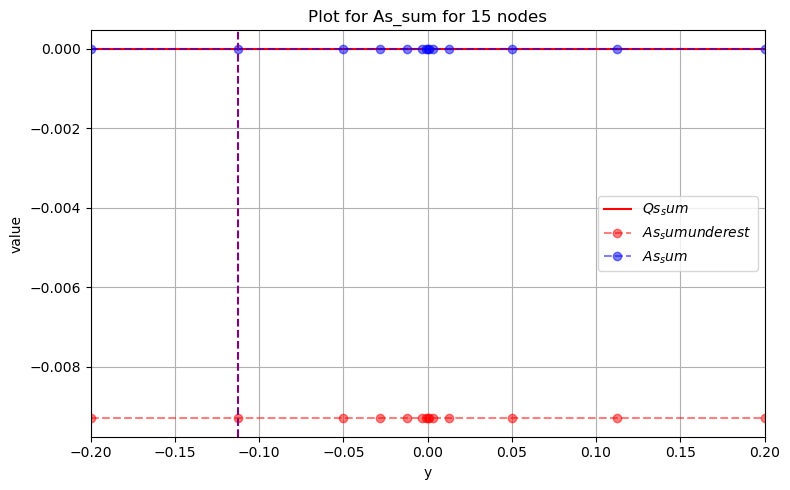

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.009291097472953064, -1.3239937601133844e-08] -0.009291110712890665
new node choosen from ms
new node is 0.028159114552134955
Current As_min is -0.009291110712890665
*****************************************

##################################################
##################################################
Start adding node  16
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.00019544211754280705
ms is  -0.006997100213386996


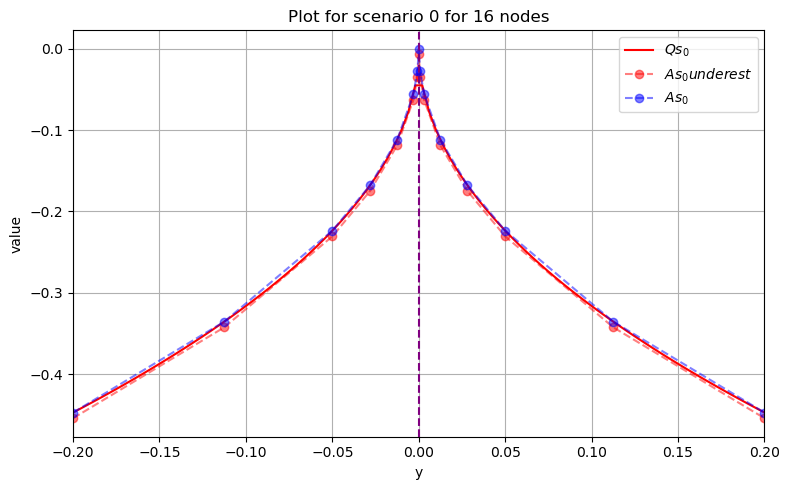

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  0.0007627778465109994
ms is  -1.0128949276544397e-08


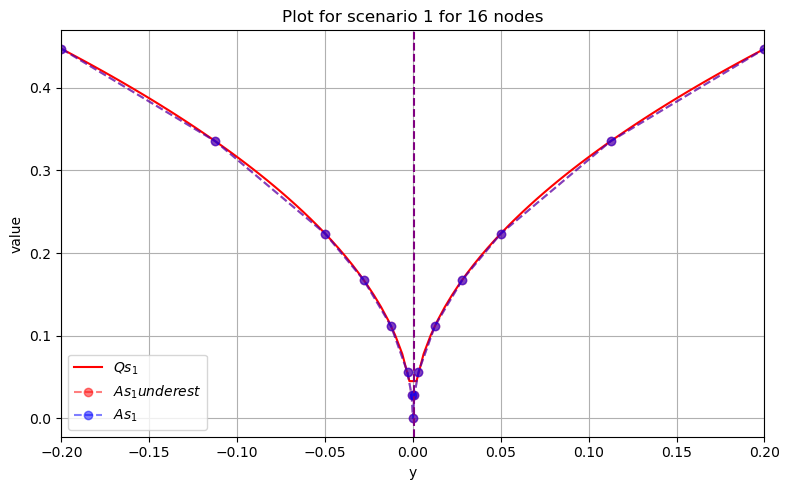

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


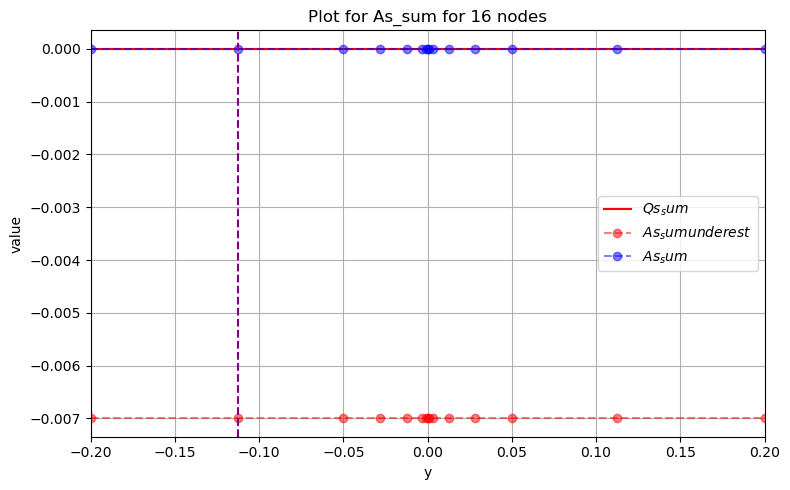

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.006997100213386996, -1.0128949276544397e-08] -0.006997110342336272
new node choosen from ms
new node is 0.00019544211754280705
Current As_min is -0.006997110342336272
*****************************************

##################################################
##################################################
Start adding node  17
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.0001834122160116058
ms is  -0.006980161315442829


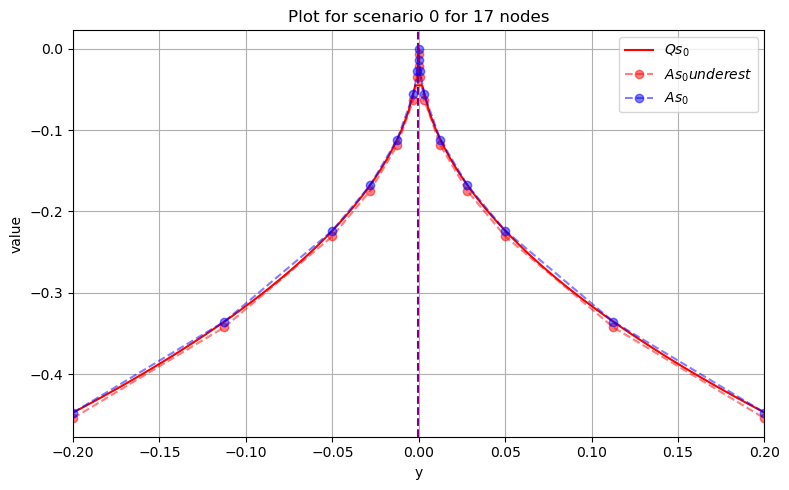

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0007611127273406658
ms is  -1.7490546674187035e-08


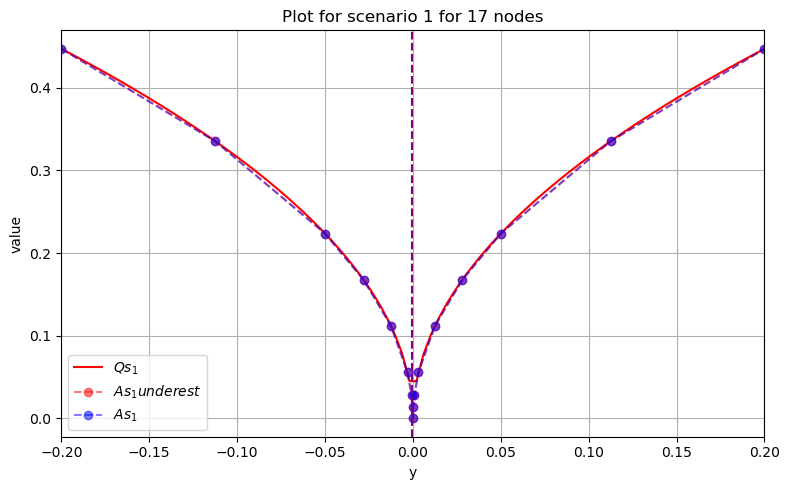

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


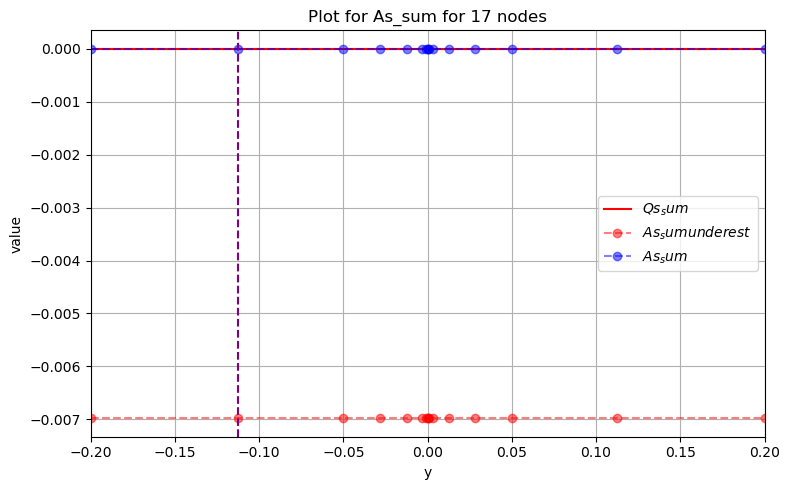

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.006980161315442829, -1.7490546674187035e-08] -0.0069801788059895035
new node choosen from ms
new node is -0.0001834122160116058
Current As_min is -0.0069801788059895035
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.07807567173204438
ms is  -0.005593499682735814


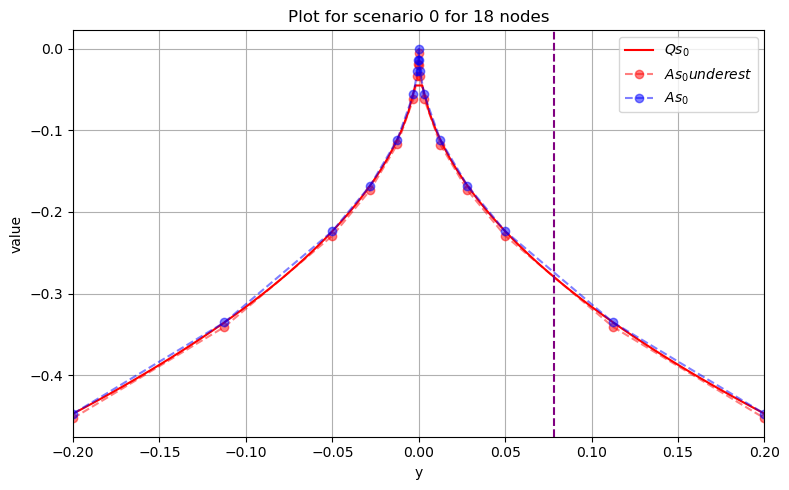

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0007611127273406658
ms is  -1.7779173230869638e-08


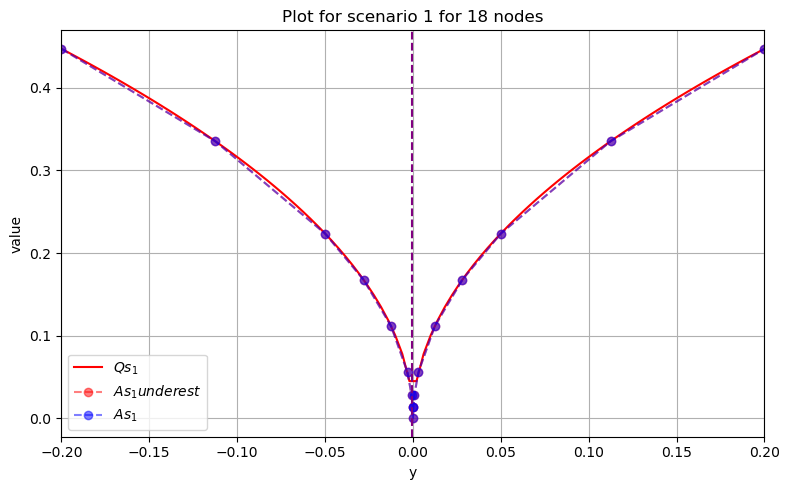

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


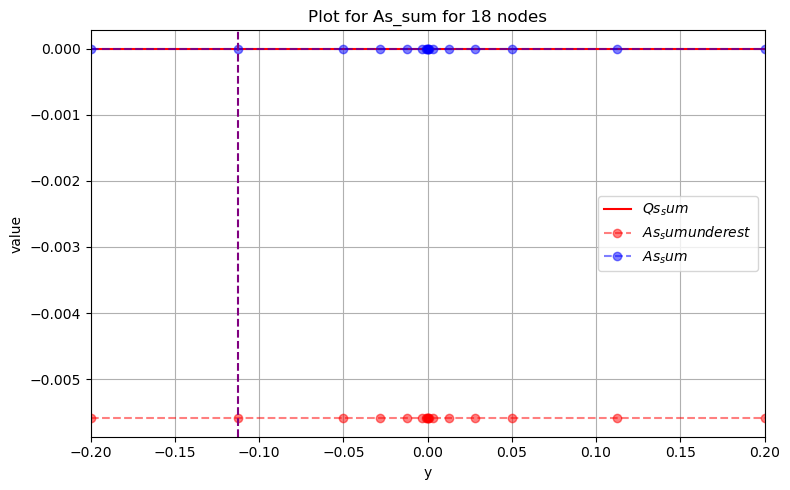

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.005593499682735814, -1.7779173230869638e-08] -0.005593517461909045
new node choosen from ms
new node is 0.07807567173204438
Current As_min is -0.005593517461909045
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.07808648597954229
ms is  -0.005591862191869634


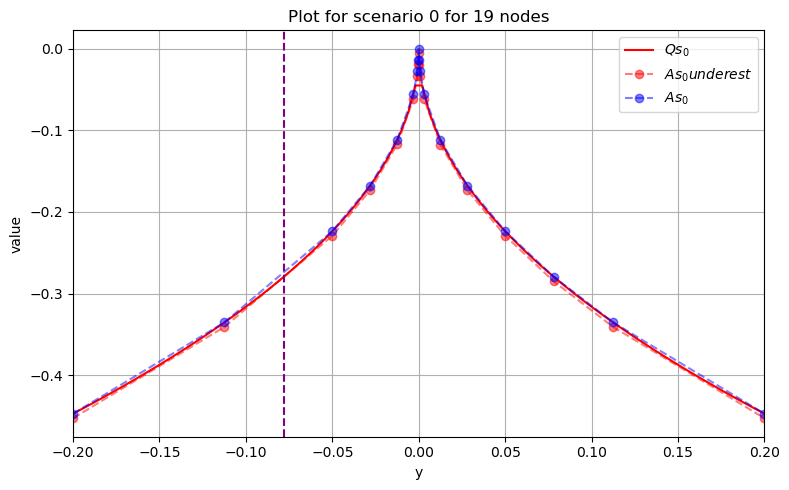

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0007611127273406658
ms is  -1.5908963178073998e-08


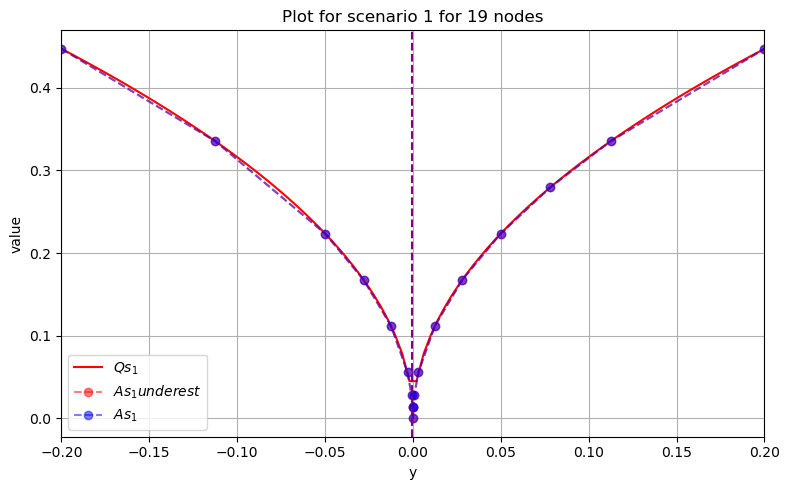

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


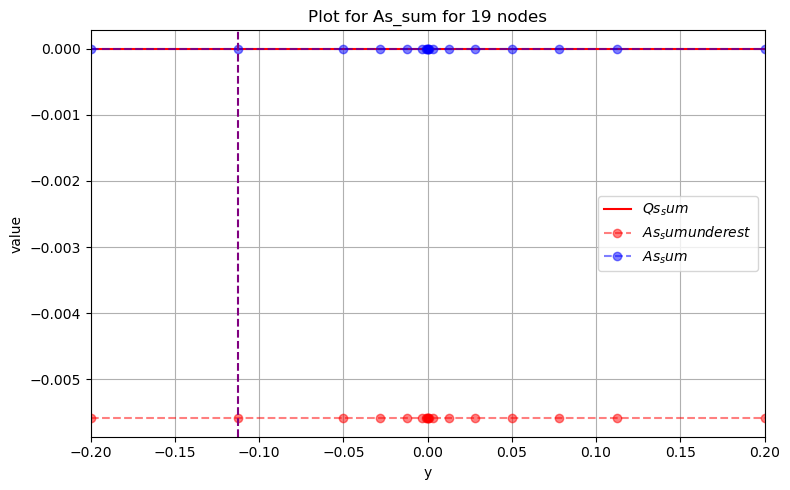

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.005591862191869634, -1.5908963178073998e-08] -0.005591878100832812
new node choosen from ms
new node is -0.07808648597954229
Current As_min is -0.005591878100832812
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  0.0
ms is  -0.005428983983444669


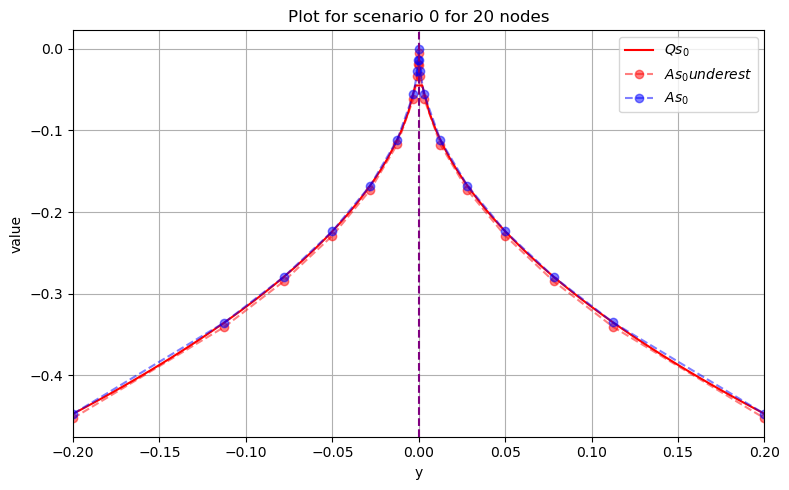

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0007611127273406658
ms is  -1.5833393200714863e-08


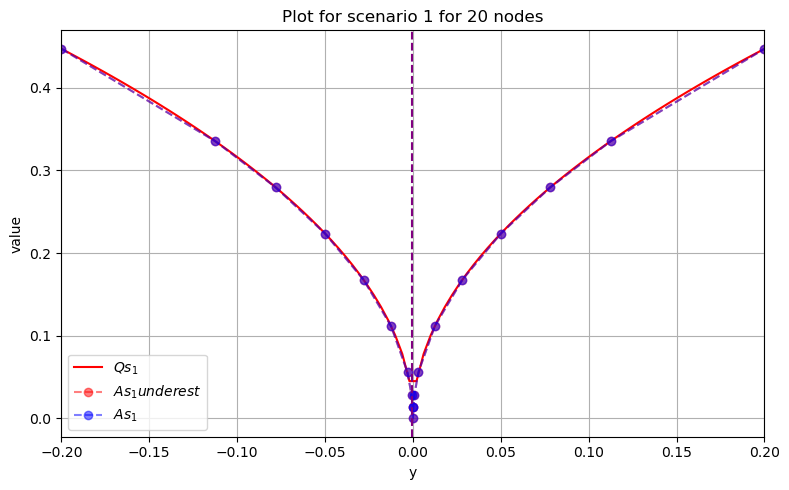

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for As_sum
The potential y_star is  -0.11247758965027846
error is  0.0


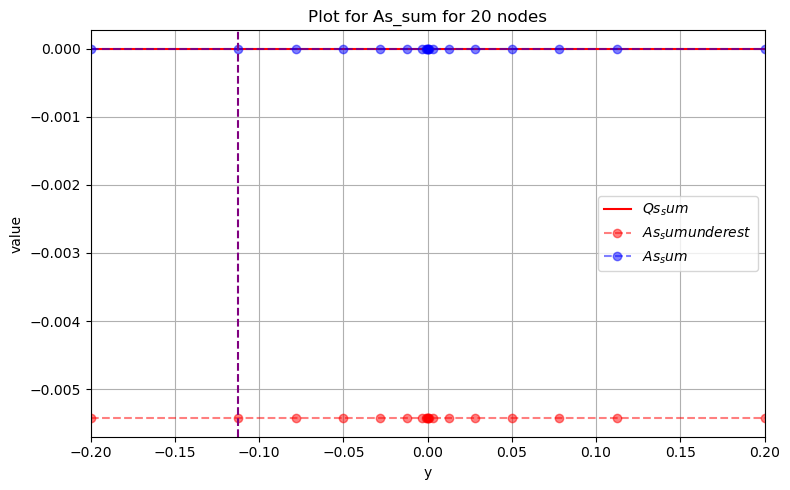

Sum *****************************************
error at y_star is  0.0
y_star is  -0.11247758965027846
ms_list and sum_ms is  [-0.005428983983444669, -1.5833393200714863e-08] -0.005428999816837869
new node choosen from ms
new node is 0.0
Current As_min is -0.005428999816837869
*****************************************

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.


In [99]:
result = nc_underest([ylb, yub],model_list,20,True, v_list)

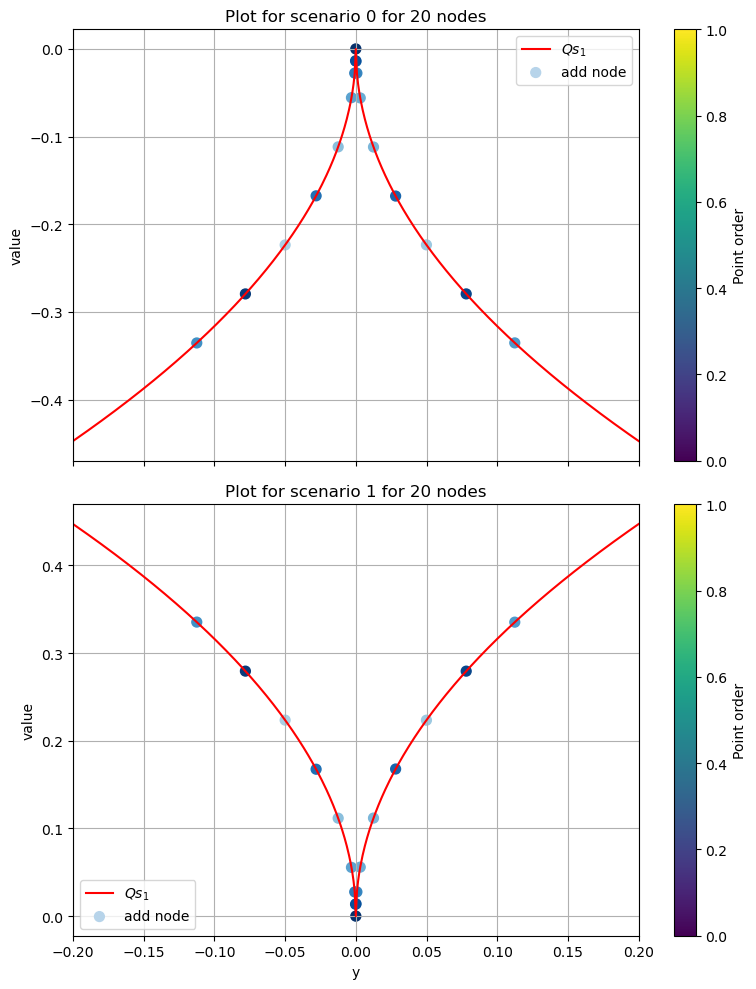

In [100]:
y_vals = np.linspace(ylb, yub, 501)
N = 2
Qs_vals_list = [None] * N
for i in range(N):
    Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
Qs_vals_sum = Qs_arr.sum(axis=0)




adds = result[-1][0]
add_node_history = result[-1][2]
v1_node = [v_list[0](y) for y in add_node_history]
v2_node = [v_list[1](y) for y in add_node_history]
#colors = plt.cm.viridis(np.linspace(0, 1, len(add_node_history)))
colors = plt.cm.Blues(np.linspace(0.3, 1, len(add_node_history)))



fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=False)
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap)
axes[0].plot(y_vals, Qs_vals_list[0], label=fr'$Qs_{i}$', color='red')
sc0 = axes[0].scatter(add_node_history, v1_node, c=colors, s=50, label='add node')
axes[0].set_xlim(ylb, yub)
axes[0].set_ylabel('value')
axes[0].set_title("Plot for scenario 0 for 20 nodes")
axes[0].legend()
axes[0].grid(True)
fig.colorbar(sm, ax=axes[0], label='Point order')
axes[1].plot(y_vals, Qs_vals_list[1], label=fr'$Qs_{i}$', color='red')
sc1 = axes[1].scatter(add_node_history, v2_node, c=colors, s=50, label='add node')
axes[1].set_xlim(ylb, yub)
axes[1].set_xlabel('y')
axes[1].set_ylabel('value')
axes[1].set_title("Plot for scenario 1 for 20 nodes")
axes[1].legend()
axes[1].grid(True)
fig.colorbar(sm, ax=axes[1], label='Point order')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


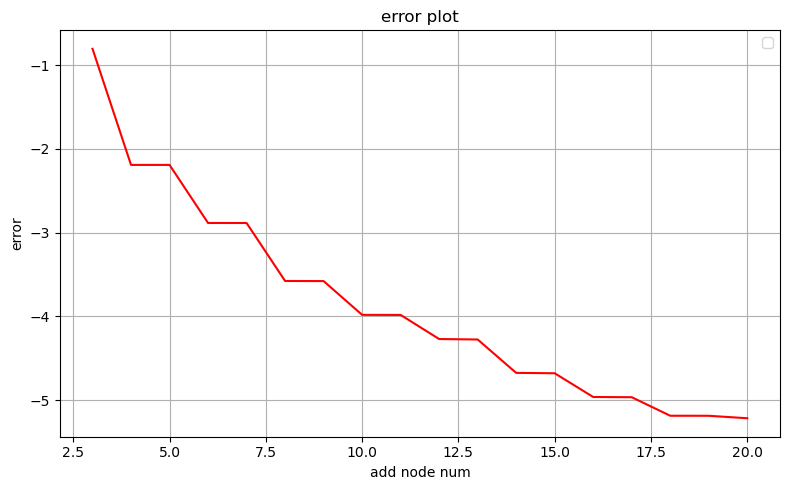

      adds     errors
----------------------
         3 0.447213595500
         4 0.111803406155
         5 0.111803368951
         6 0.055891001358
         7 0.055871873800
         8 0.027963820094
         9 0.027923593409
        10 0.018657128032
        11 0.018642200005
        12 0.013979766207
        13 0.013902396330
        14 0.009332843740
        15 0.009291110713
        16 0.006997110342
        17 0.006980178806
        18 0.005593517462
        19 0.005591878101
        20 0.005428999817


In [101]:
adds = result[-1][0]
true_min_val = 0
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
plt.plot(adds, np.log(errors), color='red')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

In [102]:
lam0 = [0,0.5, 0]
lag_history = lagrangian_loop(model_list, max_iter=10, zUB=0.2, t=0.1, lam0=lam0)
lag_iter = range(10)
lag_min = [lag_history[i][1] for i in range(len(lag_history))]
# plot
true_min_val = 0
plt.figure(figsize=(8, 5))
lag_errors = [true_min_val-item for item in lag_min]
plt.plot(lag_iter[1:], np.log(lag_errors[1:]), color='red')
plt.xlabel('iteration num')
plt.ylabel('error')
plt.title(f"lag error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(lag_iter, lag_errors):
    print(f"{a:>10} {e:>10.12f}")

TypeError: lagrangian_loop() got an unexpected keyword argument 'zUB'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


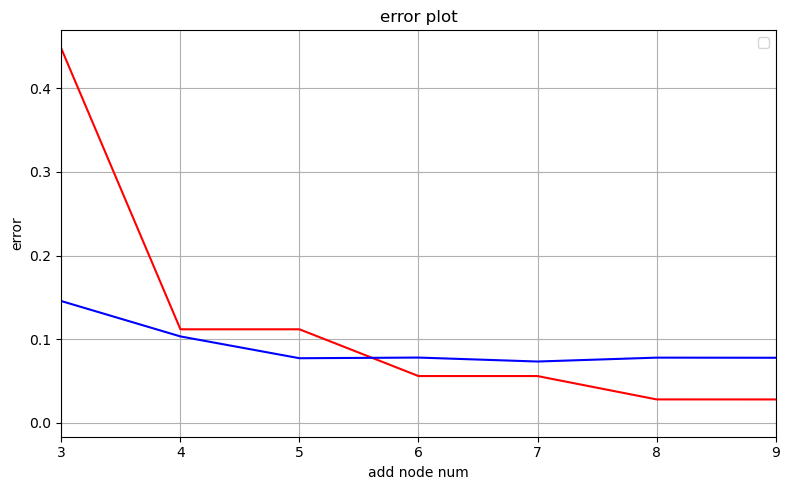

      adds     errors
----------------------
         3 0.447213595500
         4 0.111803406155
         5 0.111803368951
         6 0.055891001358
         7 0.055871873800
         8 0.027963820094
         9 0.027923593409
        10 0.018657128032
        11 0.018642200005
        12 0.013979766207
        13 0.013902396330
        14 0.009332843740
        15 0.009291110713
        16 0.006997110342
        17 0.006980178806
        18 0.005593517462
        19 0.005591878101
        20 0.005428999817


In [103]:
adds = result[-1][0]
true_min_val = 0
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
#plt.plot(adds, np.log(errors), color='red')
#plt.plot(lag_iter[1:], np.log(lag_errors[1:]), color='blue')
plt.plot(adds, errors, color='red')
plt.plot(lag_iter[1:], lag_errors[1:], color='blue')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.xlim(3, 9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

# P5

The goal is to get  10  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


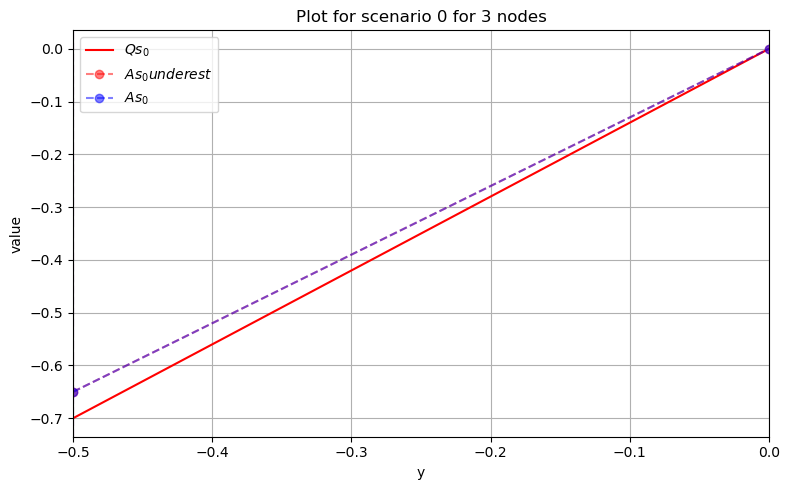

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.25
ms is  -0.06250000000000006


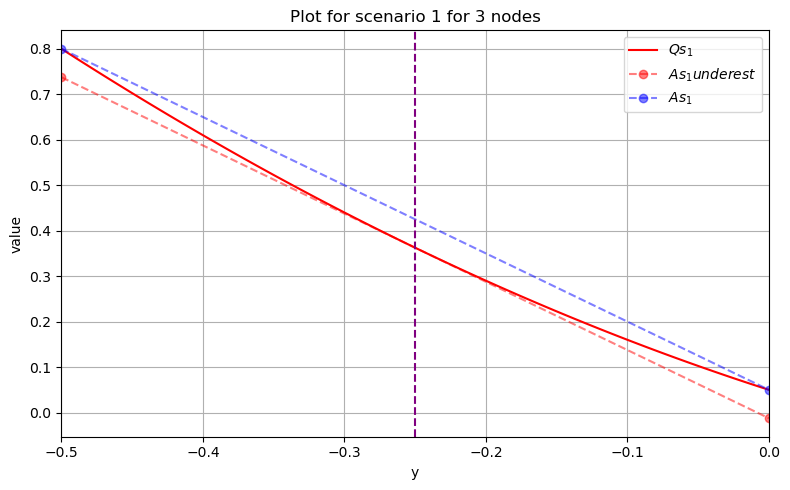

 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


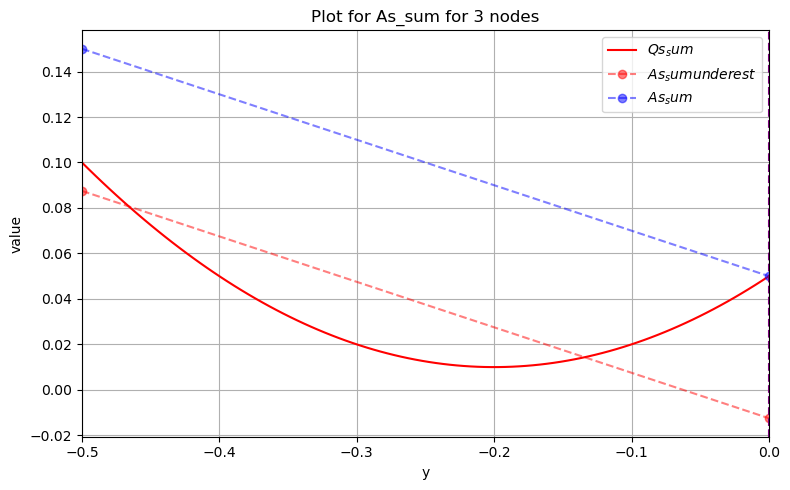

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0, -0.06250000000000006] -0.06250000000000006
new node choosen from ms
new node is -0.25
Current As_min is -0.012500000000000067
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.25
ms is  0.0


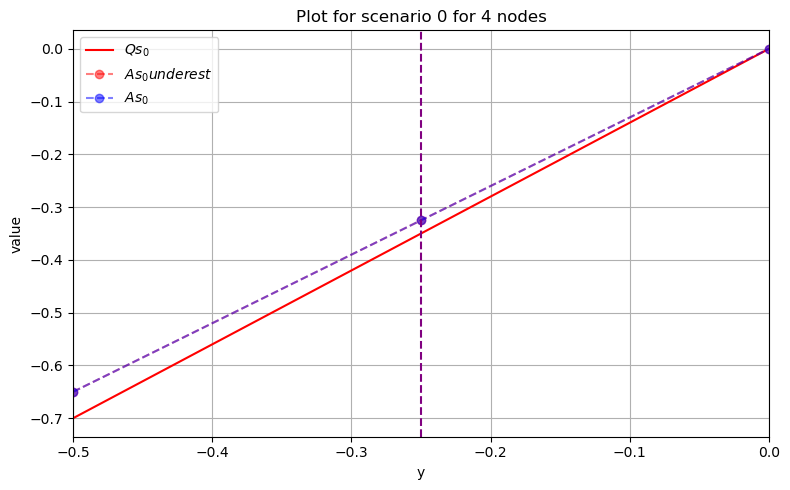

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.3750000000000001
ms is  -0.015624999999999889


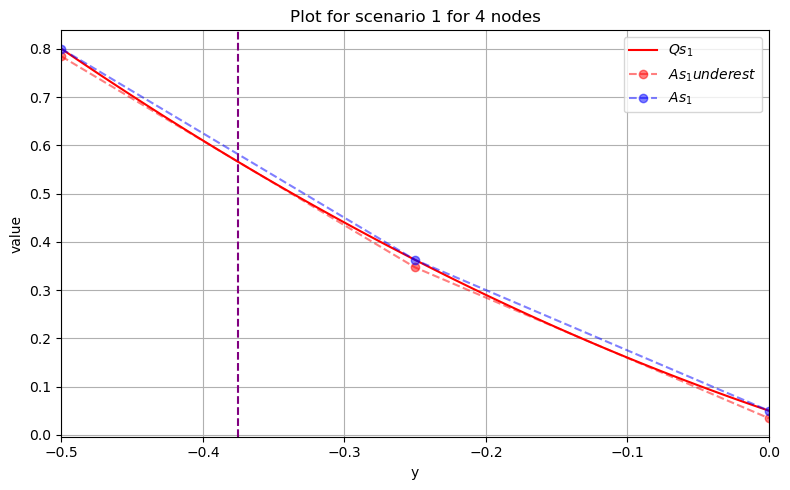

 
The plot for As_sum
The potential y_star is  -0.25
error is  0.0


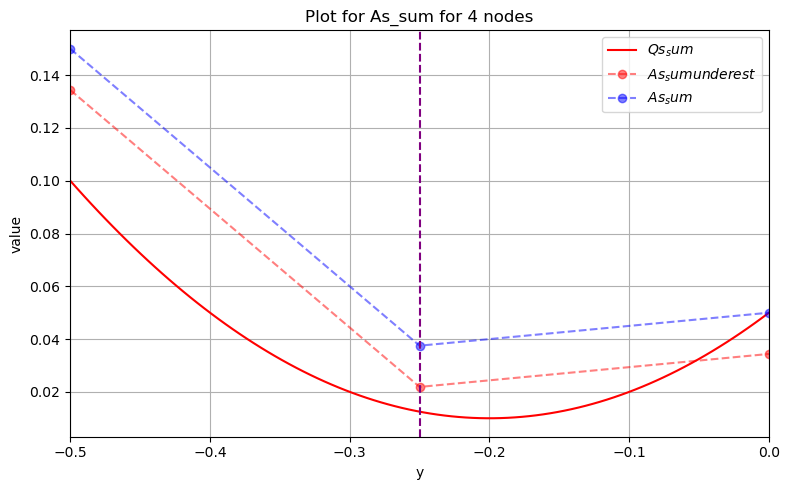

Sum *****************************************
error at y_star is  0.0
y_star is  -0.25
ms_list and sum_ms is  [0.0, -0.015624999999999889] -0.015624999999999889
new node choosen from ms
new node is -0.3750000000000001
Current As_min is 0.02187500000000009
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.3750000000000001
ms is  0.0


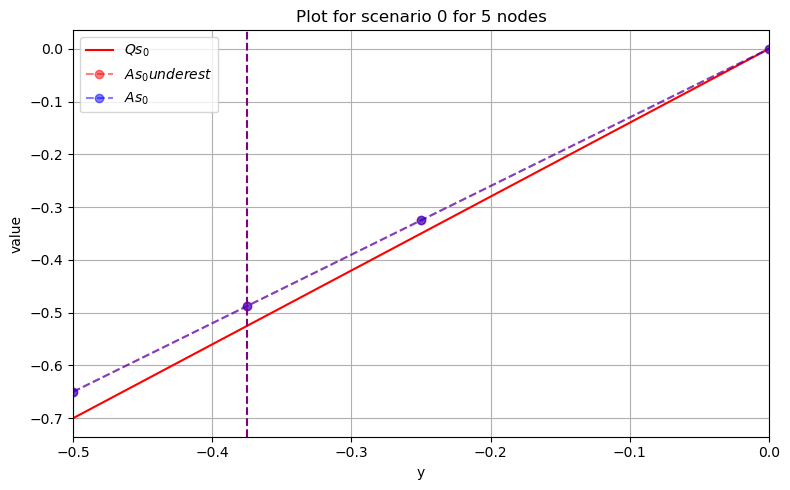

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.125
ms is  -0.015625


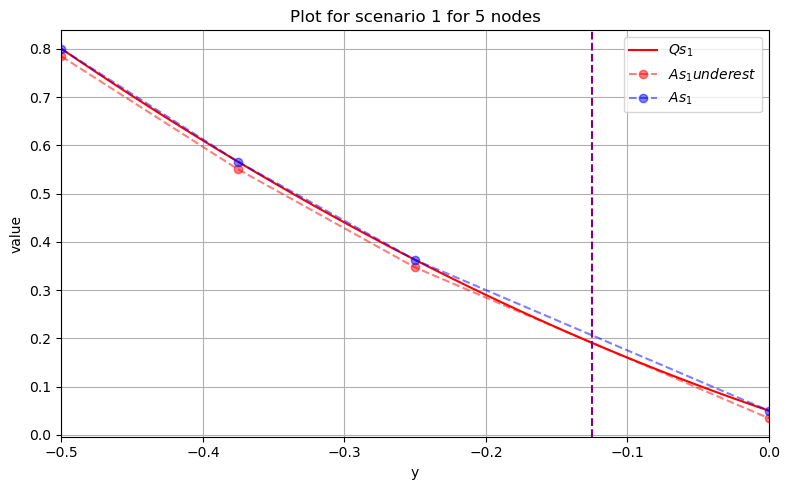

 
The plot for As_sum
The potential y_star is  -0.25
error is  0.0


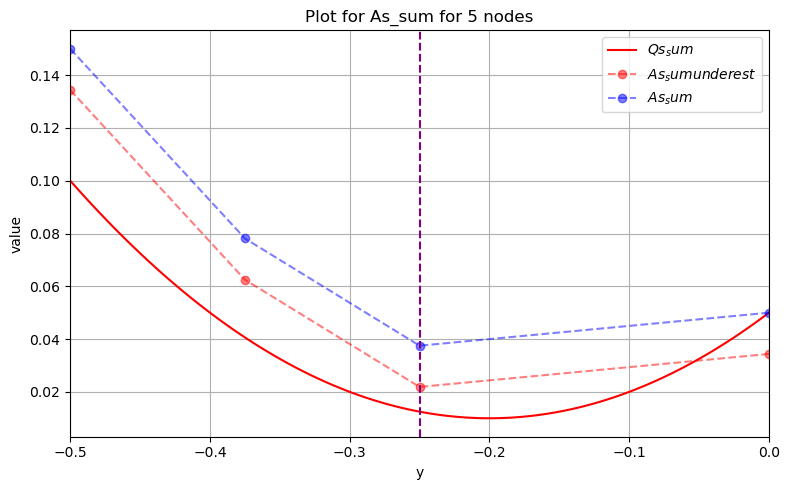

Sum *****************************************
error at y_star is  0.0
y_star is  -0.25
ms_list and sum_ms is  [0.0, -0.015625] -0.015625
new node choosen from ms
new node is -0.125
Current As_min is 0.021874999999999978
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


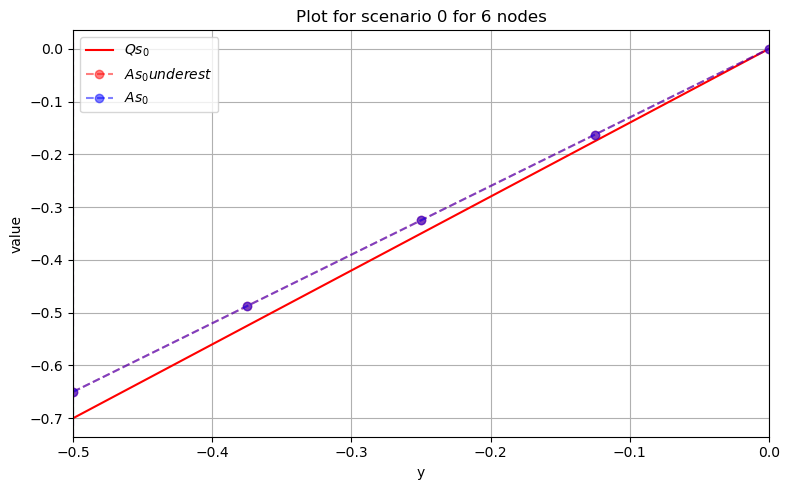

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.4374999999999999
ms is  -0.00390625


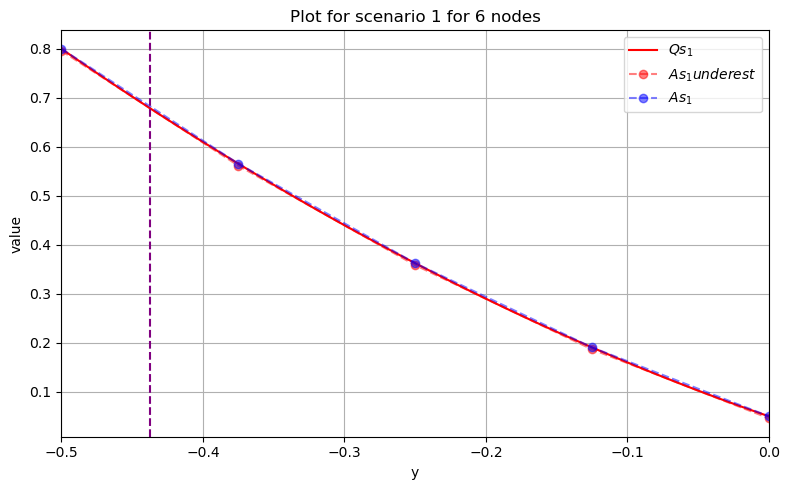

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


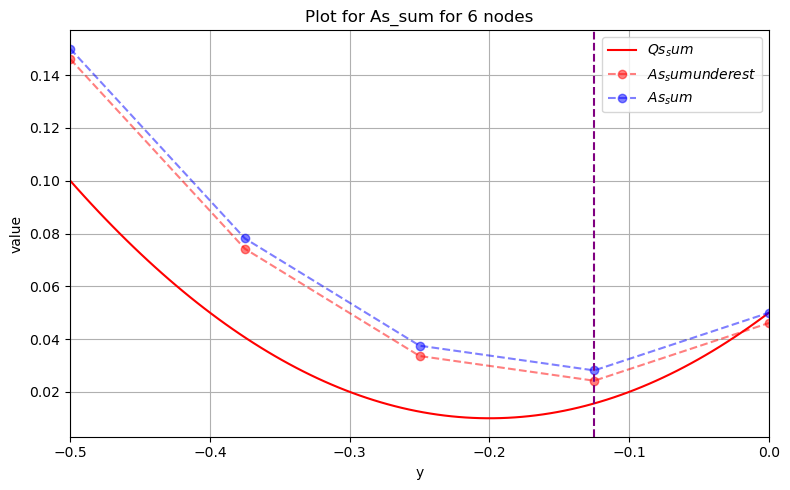

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.4374999999999999
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


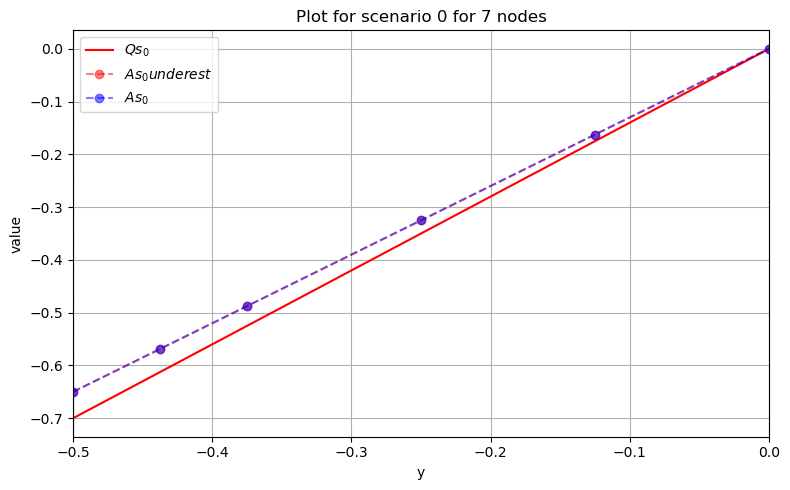

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.1875
ms is  -0.00390625


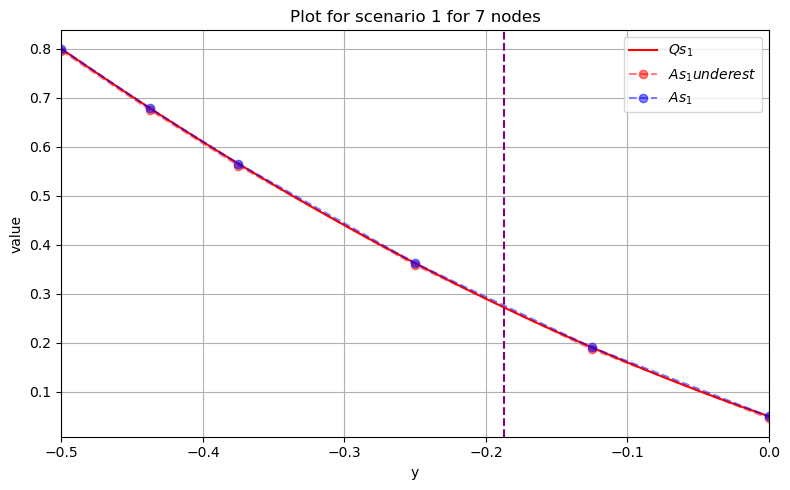

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


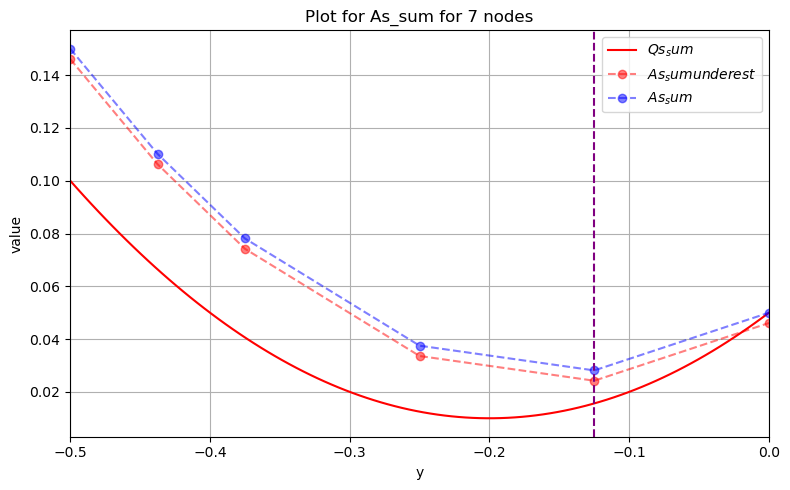

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.1875
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


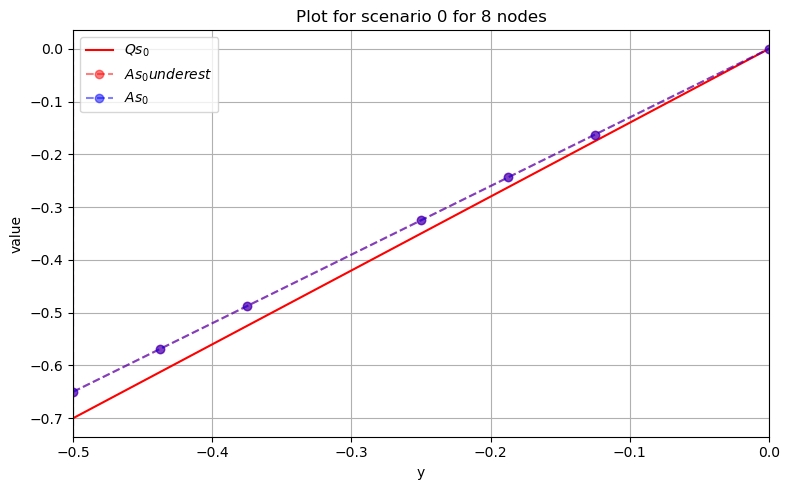

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0625
ms is  -0.00390625


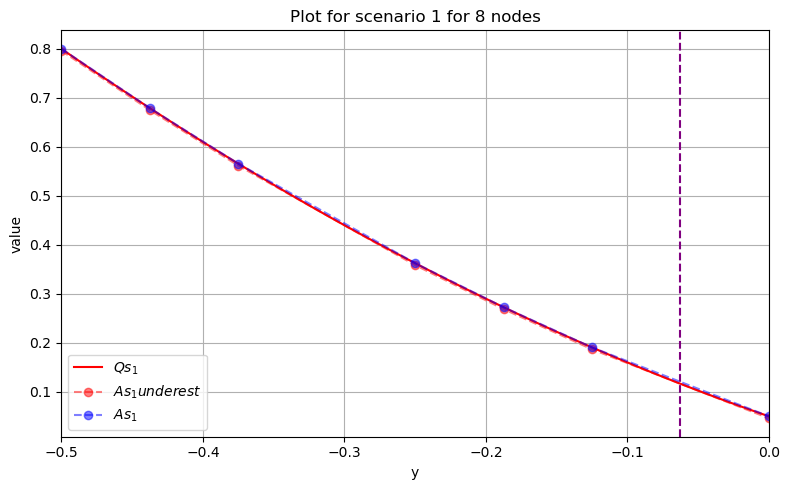

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


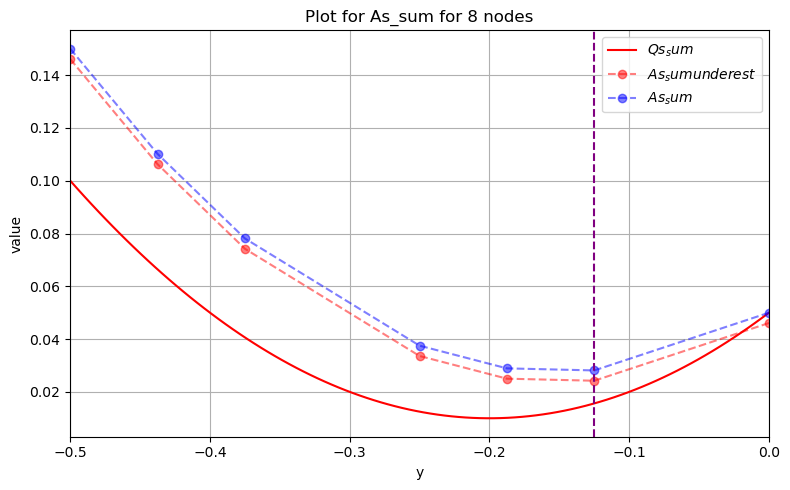

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.0625
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  9
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


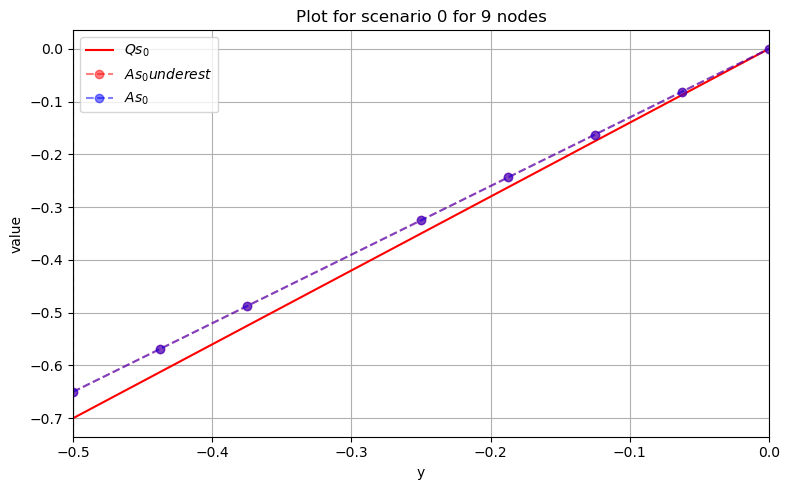

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.31250000000000044
ms is  -0.003906250000000111


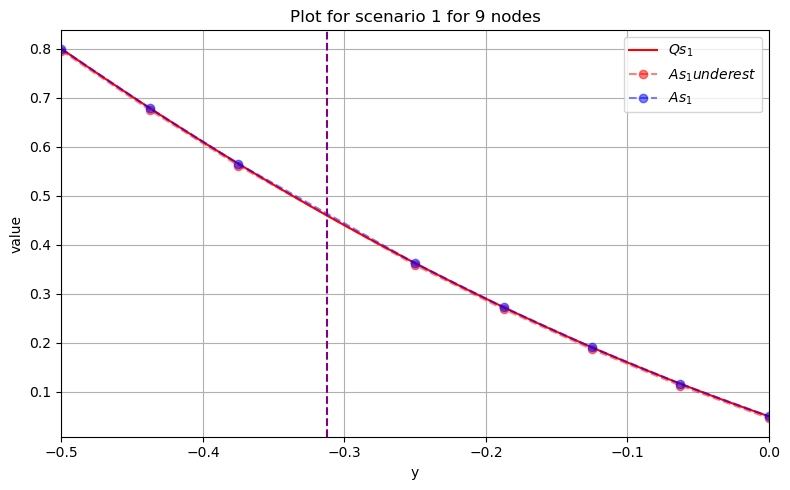

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


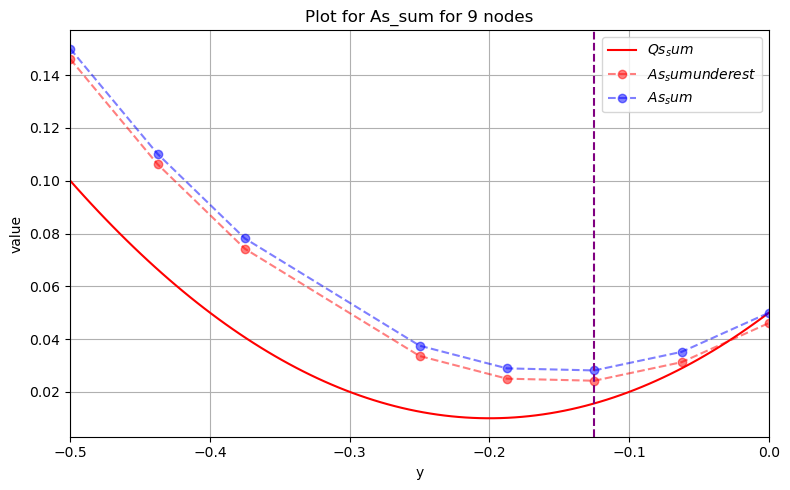

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.003906250000000111] -0.003906250000000111
new node choosen from ms
new node is -0.31250000000000044
Current As_min is 0.024218749999999872
*****************************************

##################################################
##################################################
Start adding node  10
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


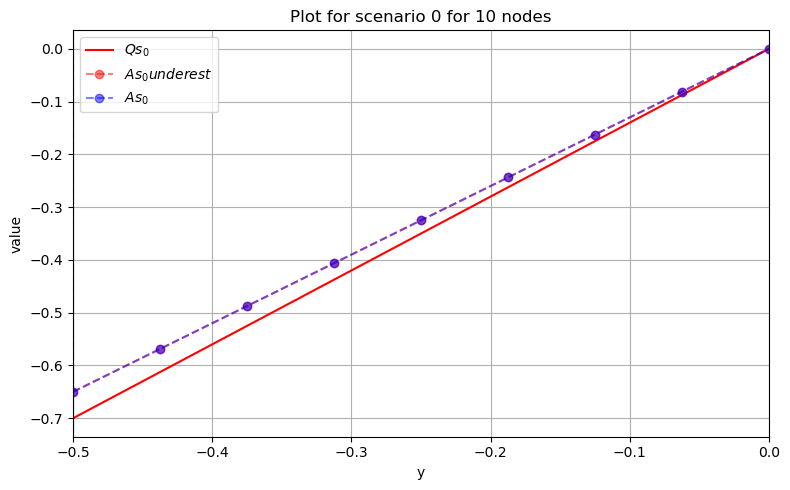

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.4687499999999999
ms is  -0.0009765625


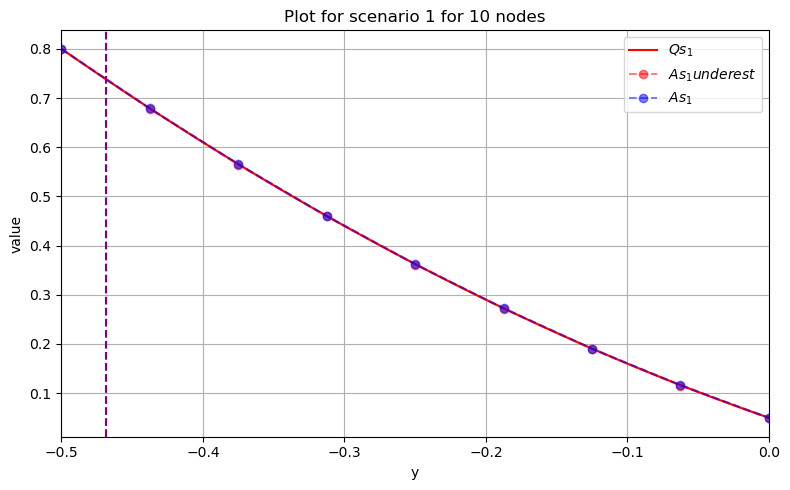

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


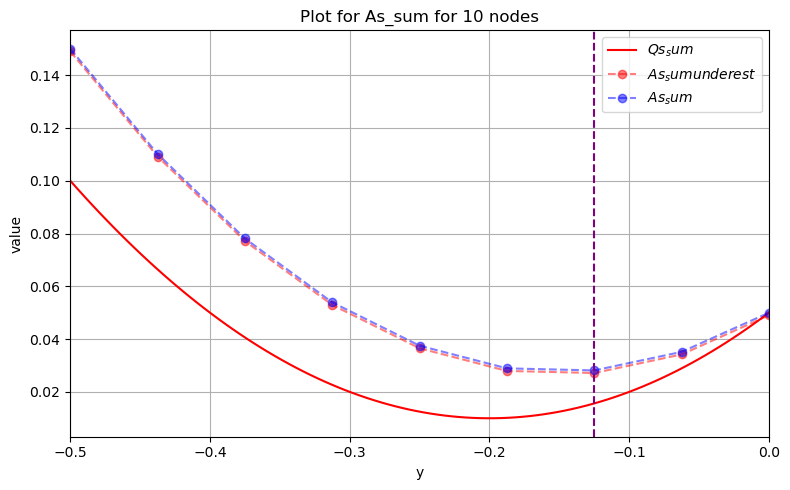

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.4687499999999999
Current As_min is 0.027148437499999983
*****************************************



In [80]:
# build function for each scenario
def v_1(y):  
    return 1.4*y

def v_2(y): 
    return (y-0.5)**2-0.2
# in this case, min is at y=-0.2, obj = 0.01
v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.5
yub = 0
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y)
m1.obj_expr = Expression(expr=1.3*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == (m2.y-0.5)**2)
m2.obj_expr = Expression(expr=m2.x2-0.2)

model_list = [m1, m2]
result = nc_underest([ylb, yub],model_list,10,True, v_list)

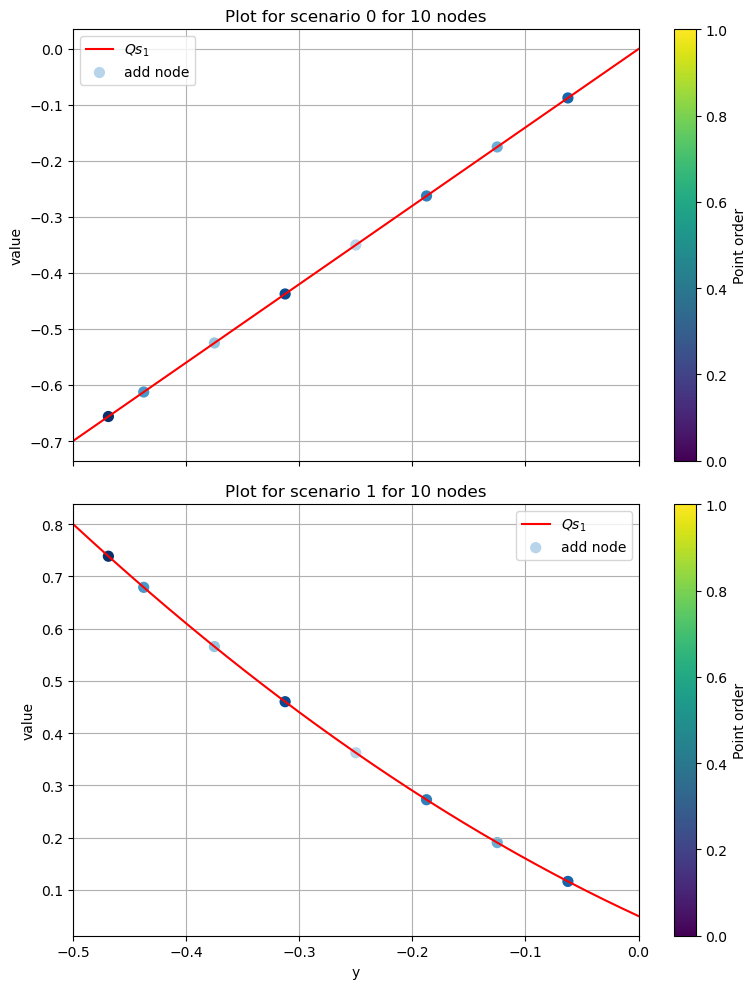

In [81]:
y_vals = np.linspace(ylb, yub, 501)
N = 2
Qs_vals_list = [None] * N
for i in range(N):
    Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
Qs_vals_sum = Qs_arr.sum(axis=0)




adds = result[-1][0]
add_node_history = result[-1][2]
v1_node = [v_list[0](y) for y in add_node_history]
v2_node = [v_list[1](y) for y in add_node_history]
#colors = plt.cm.viridis(np.linspace(0, 1, len(add_node_history)))
colors = plt.cm.Blues(np.linspace(0.3, 1, len(add_node_history)))




fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=False)
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap)
axes[0].plot(y_vals, Qs_vals_list[0], label=fr'$Qs_{i}$', color='red')
sc0 = axes[0].scatter(add_node_history, v1_node, c=colors, s=50, label='add node')
axes[0].set_xlim(ylb, yub)
axes[0].set_ylabel('value')
axes[0].set_title("Plot for scenario 0 for 10 nodes")
axes[0].legend()
axes[0].grid(True)
fig.colorbar(sm, ax=axes[0], label='Point order')
axes[1].plot(y_vals, Qs_vals_list[1], label=fr'$Qs_{i}$', color='red')
sc1 = axes[1].scatter(add_node_history, v2_node, c=colors, s=50, label='add node')
axes[1].set_xlim(ylb, yub)
axes[1].set_xlabel('y')
axes[1].set_ylabel('value')
axes[1].set_title("Plot for scenario 1 for 10 nodes")
axes[1].legend()
axes[1].grid(True)
fig.colorbar(sm, ax=axes[1], label='Point order')
plt.tight_layout()
plt.show()

The goal is to get  20  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


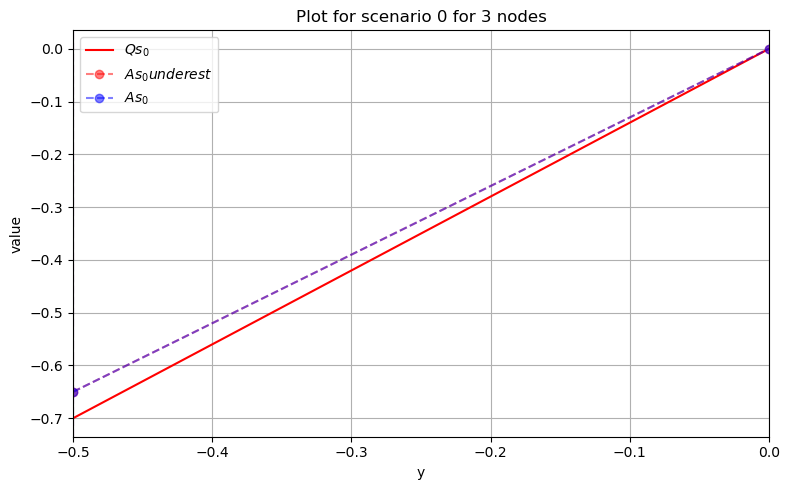

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.25
ms is  -0.06250000000000006


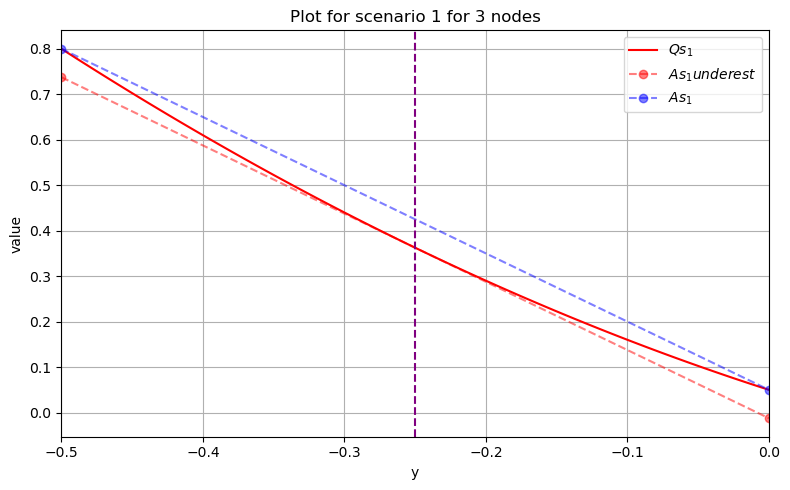

 
The plot for As_sum
The potential y_star is  0.0
error is  0.0


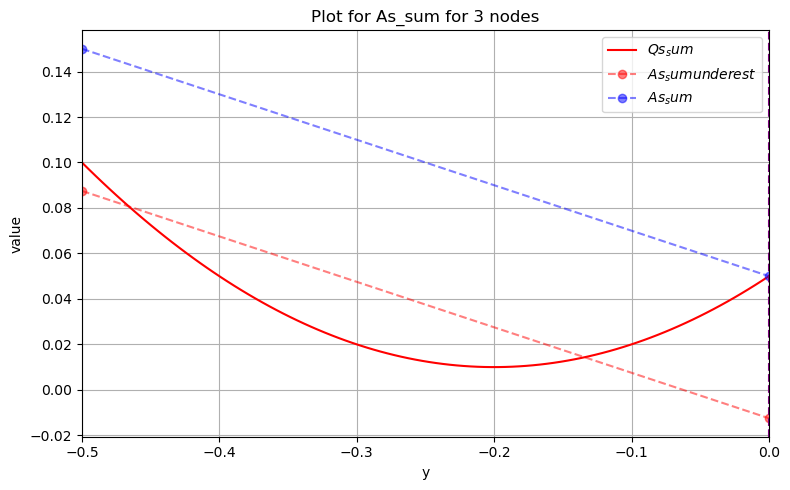

Sum *****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0, -0.06250000000000006] -0.06250000000000006
new node choosen from ms
new node is -0.25
Current As_min is -0.012500000000000067
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.25
ms is  0.0


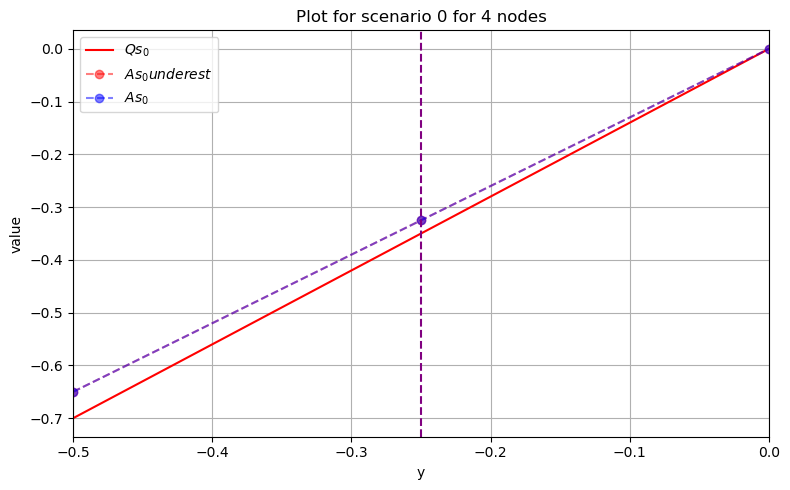

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.3750000000000001
ms is  -0.015624999999999889


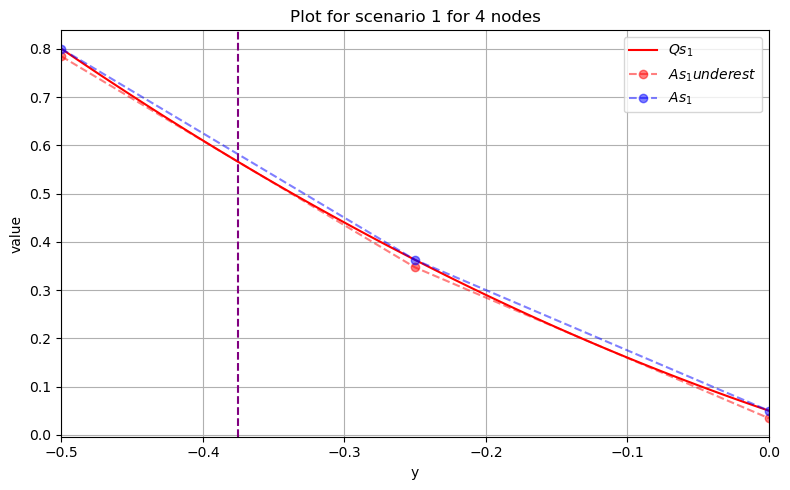

 
The plot for As_sum
The potential y_star is  -0.25
error is  0.0


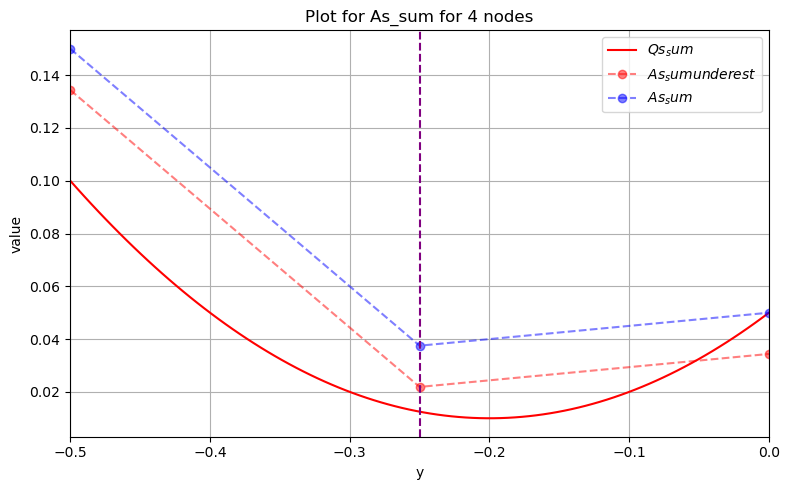

Sum *****************************************
error at y_star is  0.0
y_star is  -0.25
ms_list and sum_ms is  [0.0, -0.015624999999999889] -0.015624999999999889
new node choosen from ms
new node is -0.3750000000000001
Current As_min is 0.02187500000000009
*****************************************

##################################################
##################################################
Start adding node  5
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.3750000000000001
ms is  0.0


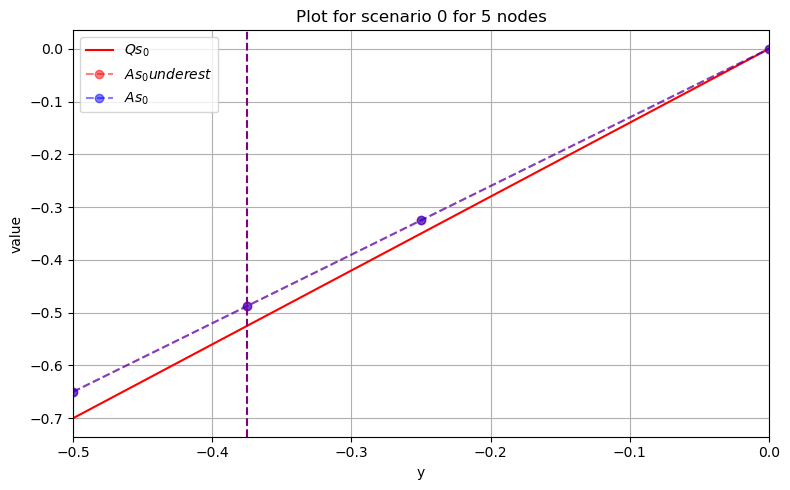

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.125
ms is  -0.015625


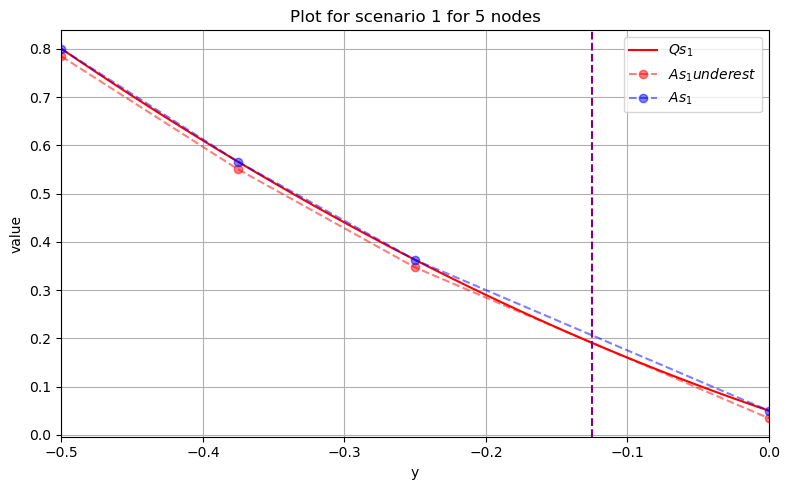

 
The plot for As_sum
The potential y_star is  -0.25
error is  0.0


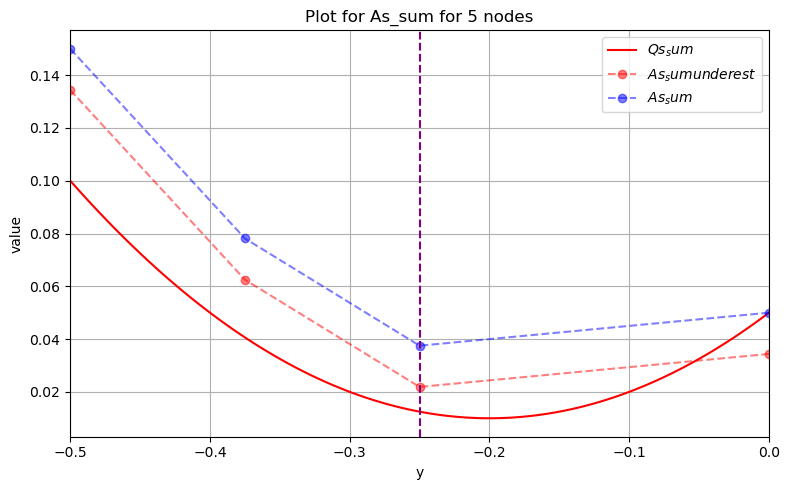

Sum *****************************************
error at y_star is  0.0
y_star is  -0.25
ms_list and sum_ms is  [0.0, -0.015625] -0.015625
new node choosen from ms
new node is -0.125
Current As_min is 0.021874999999999978
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


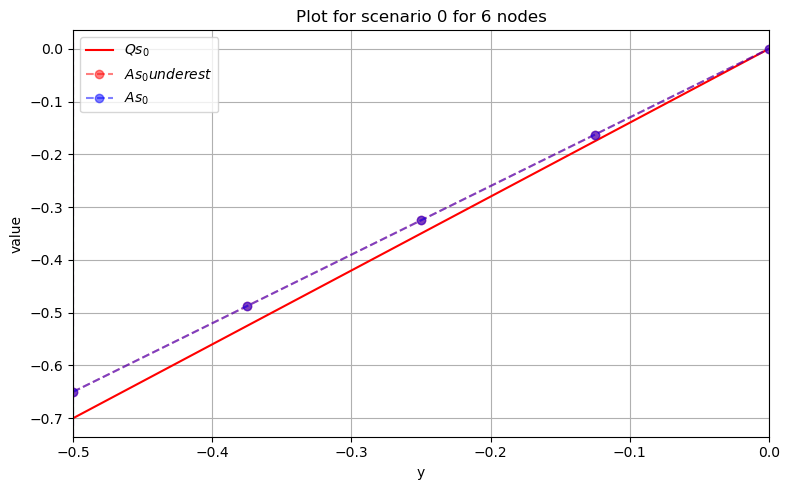

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.4374999999999999
ms is  -0.00390625


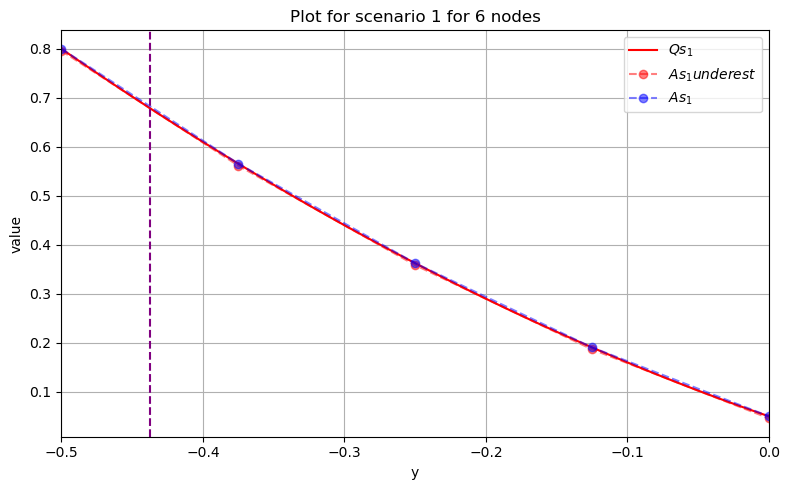

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


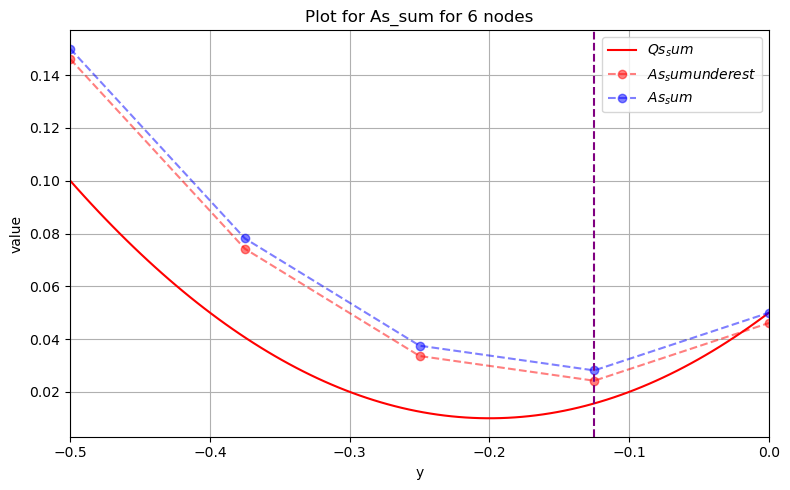

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.4374999999999999
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


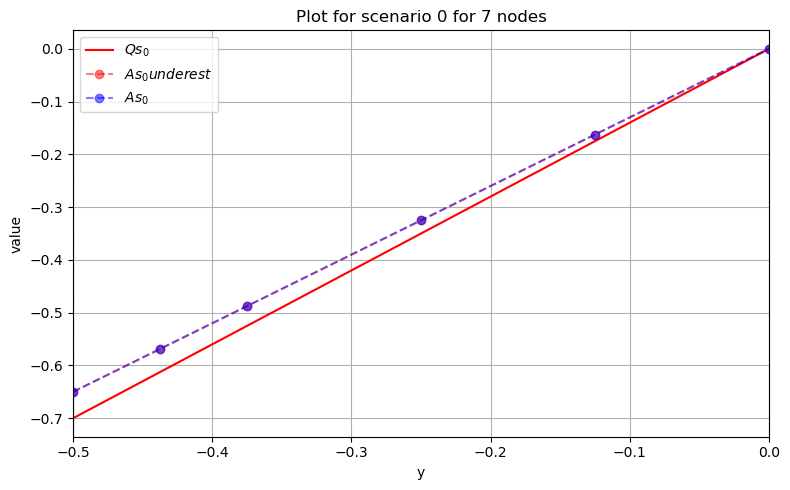

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.1875
ms is  -0.00390625


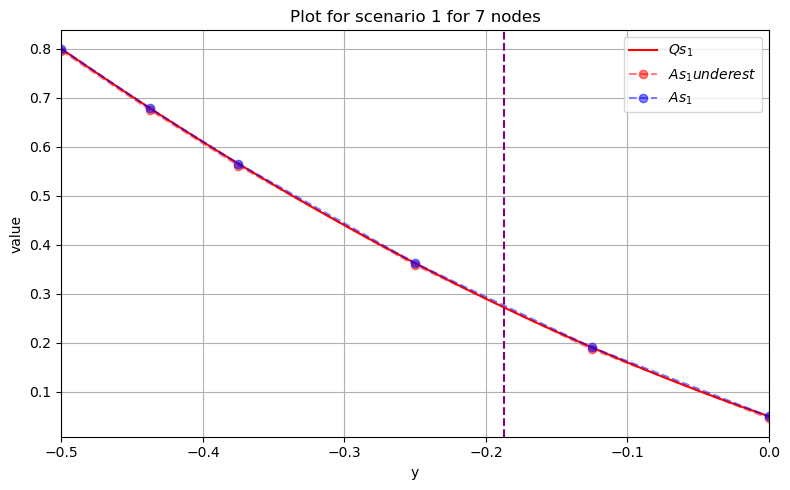

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


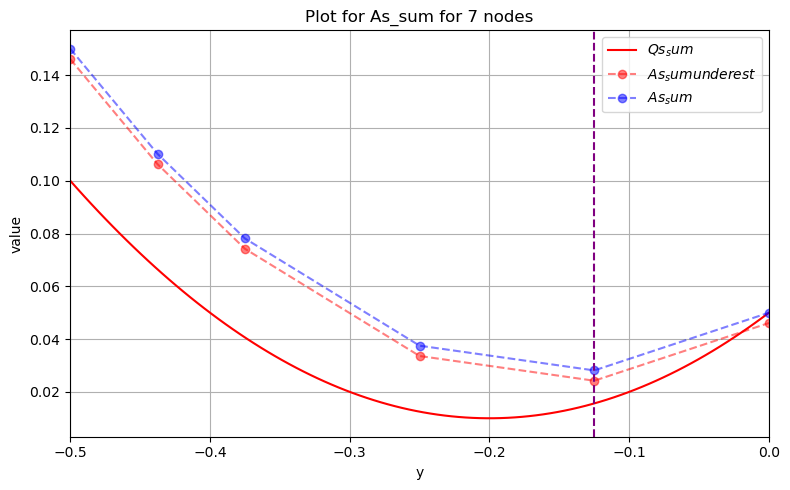

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.1875
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  8
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


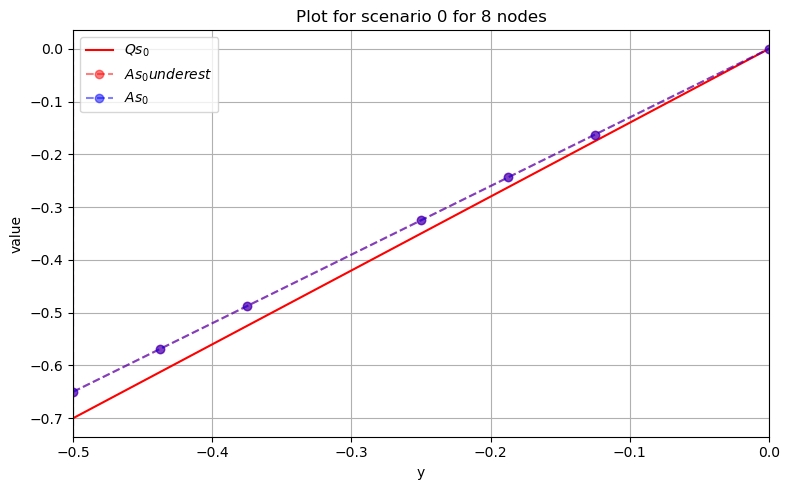

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.0625
ms is  -0.00390625


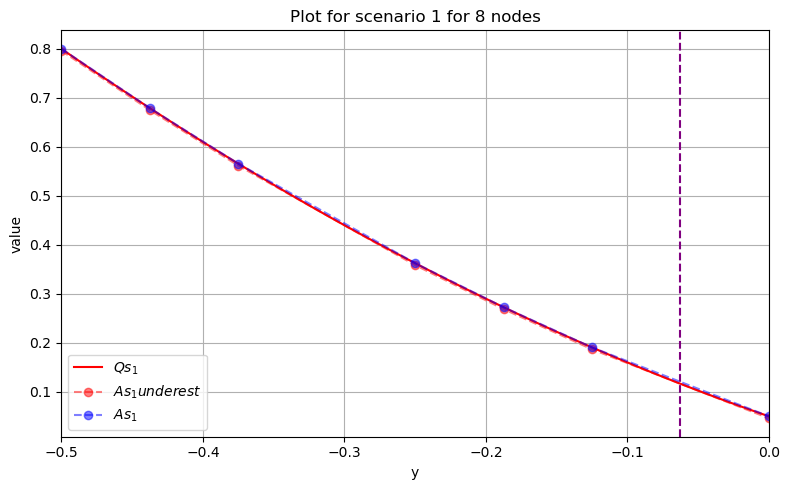

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


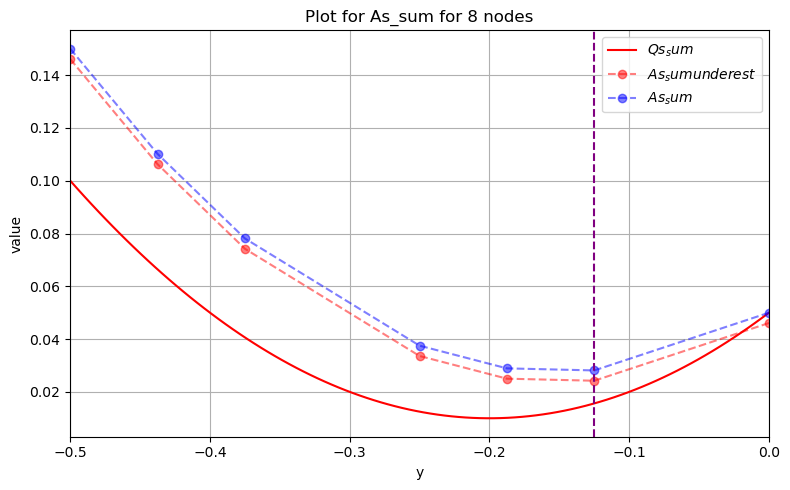

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.00390625] -0.00390625
new node choosen from ms
new node is -0.0625
Current As_min is 0.024218749999999983
*****************************************

##################################################
##################################################
Start adding node  9
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


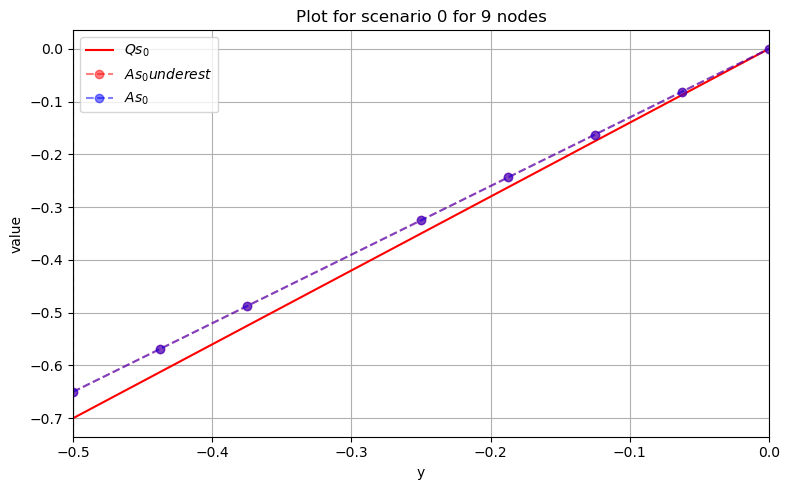

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.31250000000000044
ms is  -0.003906250000000111


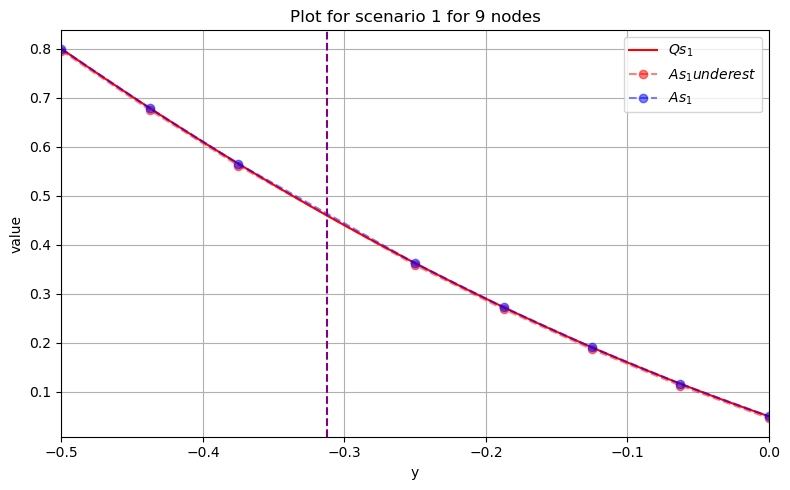

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


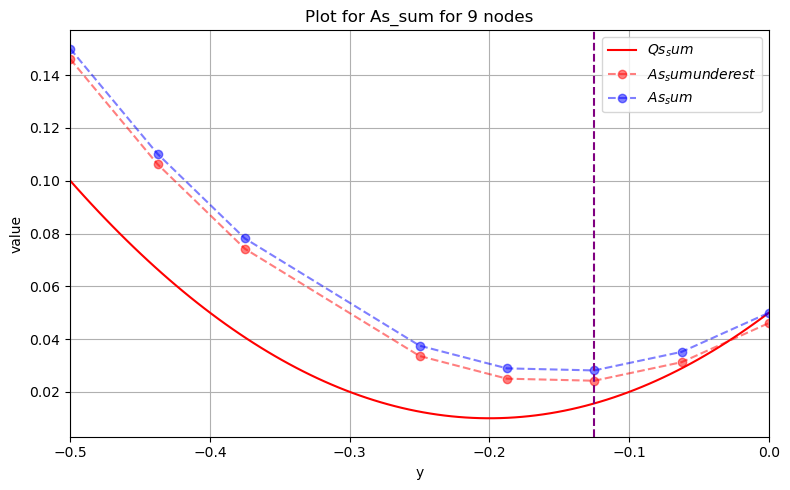

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.003906250000000111] -0.003906250000000111
new node choosen from ms
new node is -0.31250000000000044
Current As_min is 0.024218749999999872
*****************************************

##################################################
##################################################
Start adding node  10
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


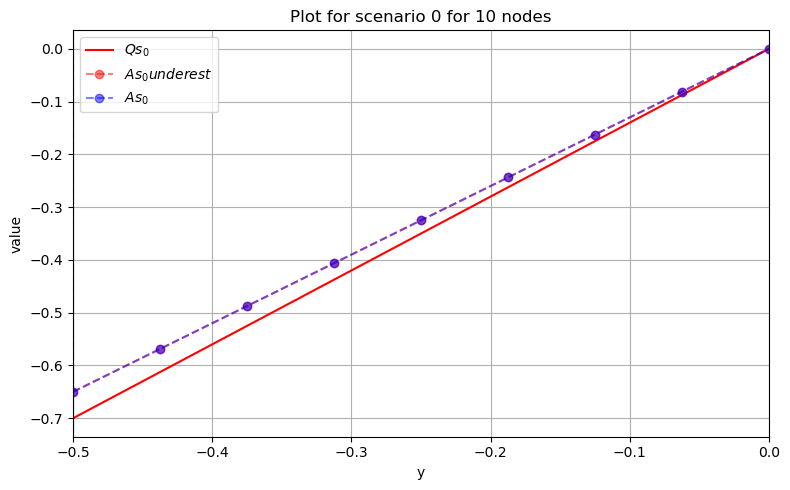

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.4687499999999999
ms is  -0.0009765625


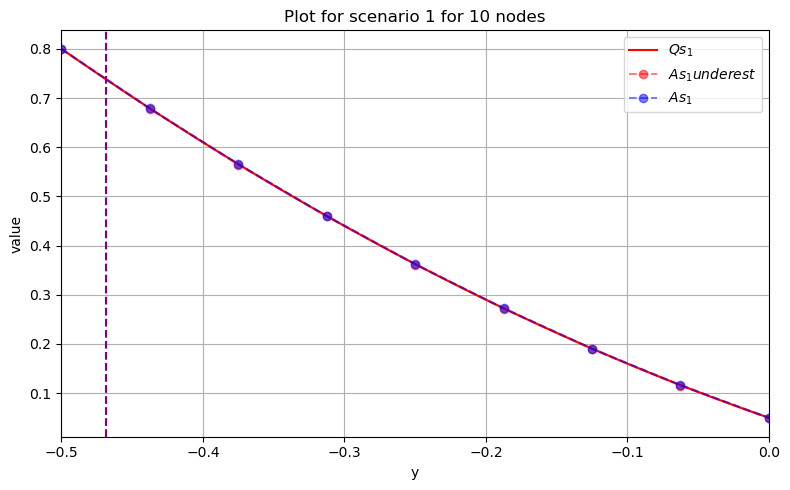

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


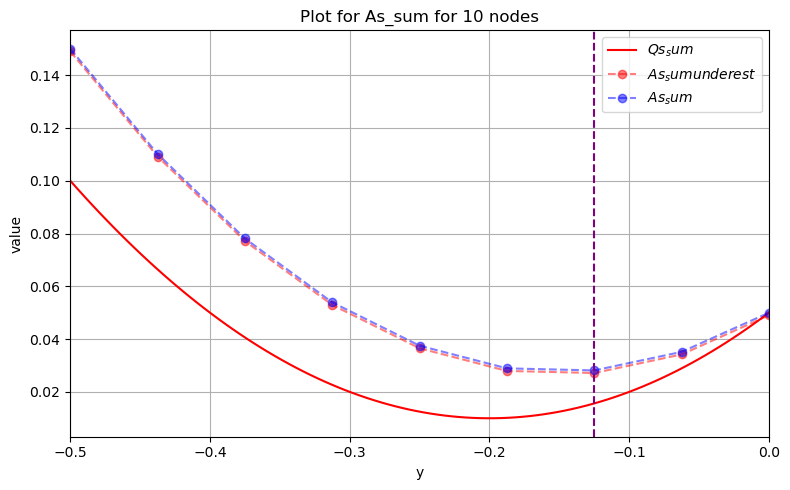

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.4687499999999999
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  11
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.5
ms is  0.0


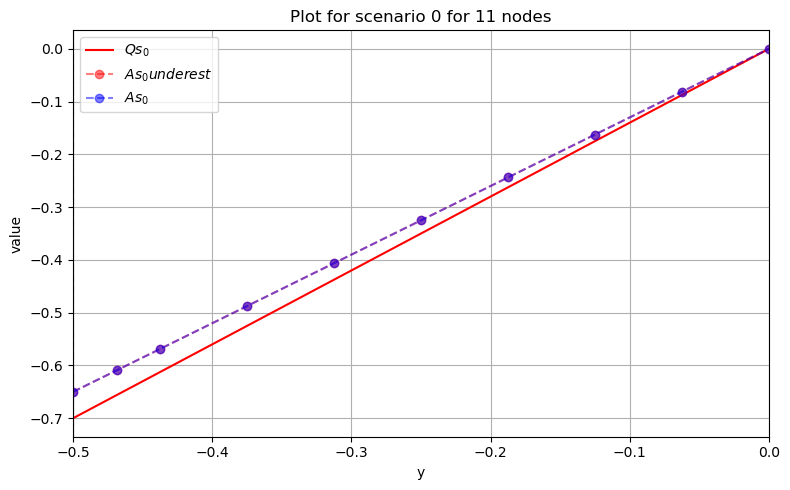

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.09375
ms is  -0.0009765625


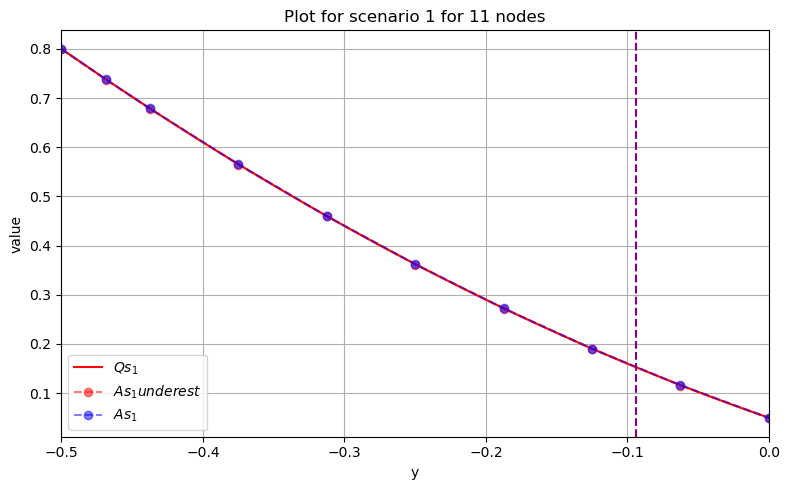

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


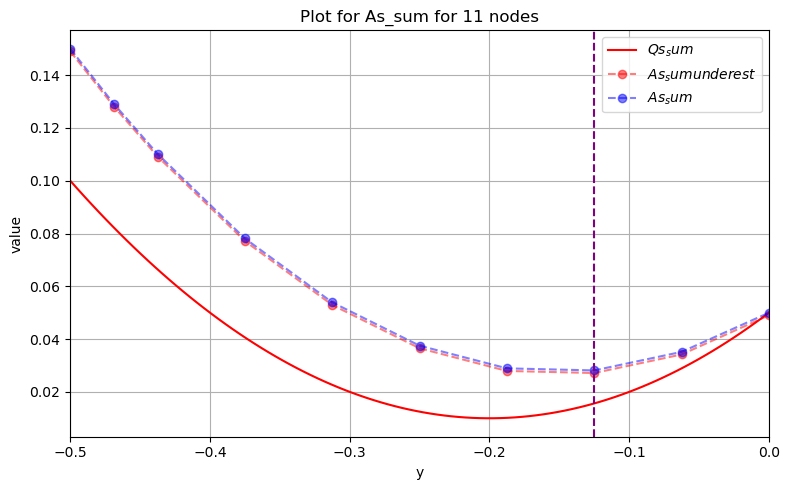

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.09375
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


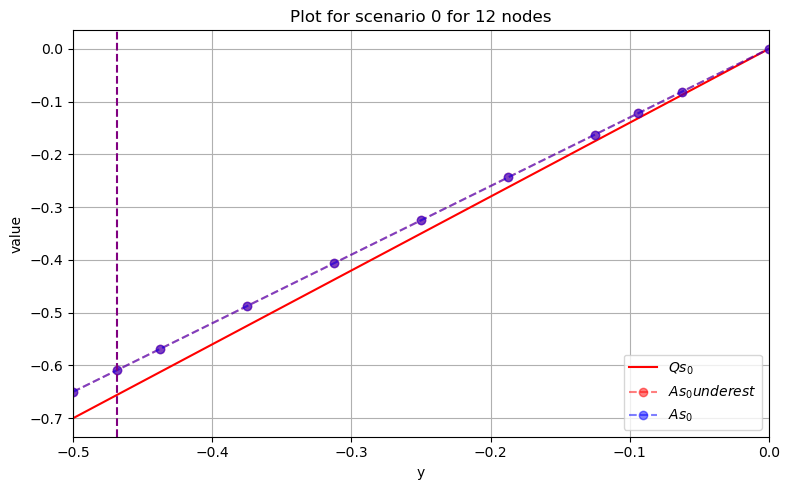

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.34375000000000133
ms is  -0.0009765625


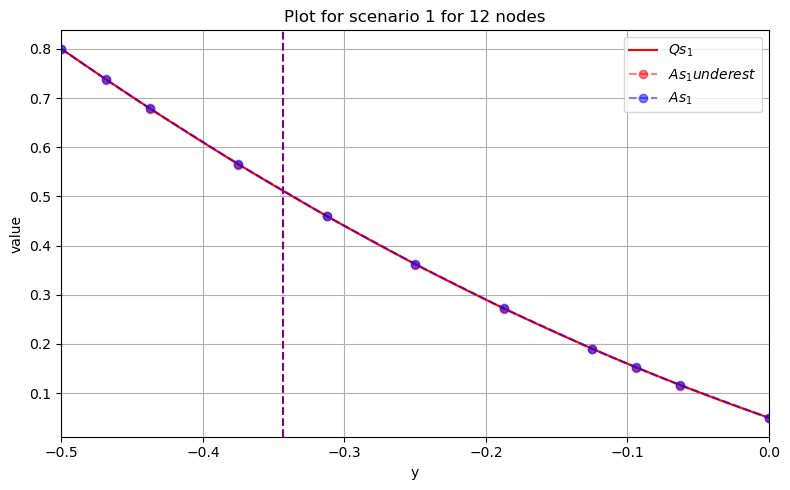

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


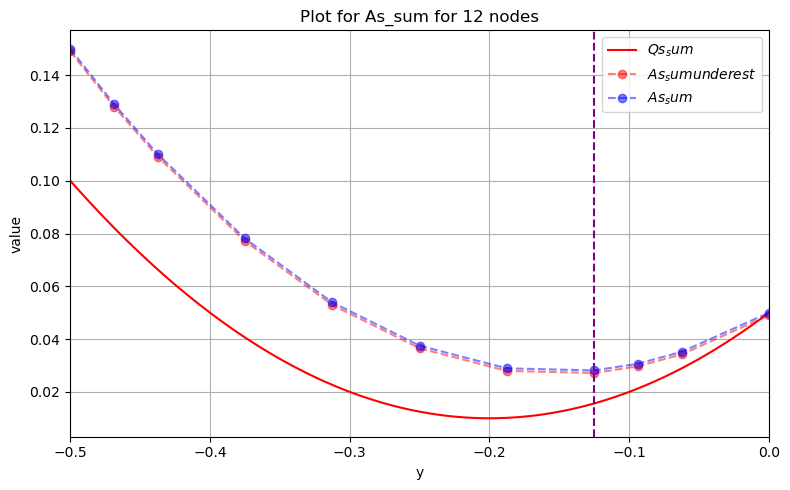

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.34375000000000133
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


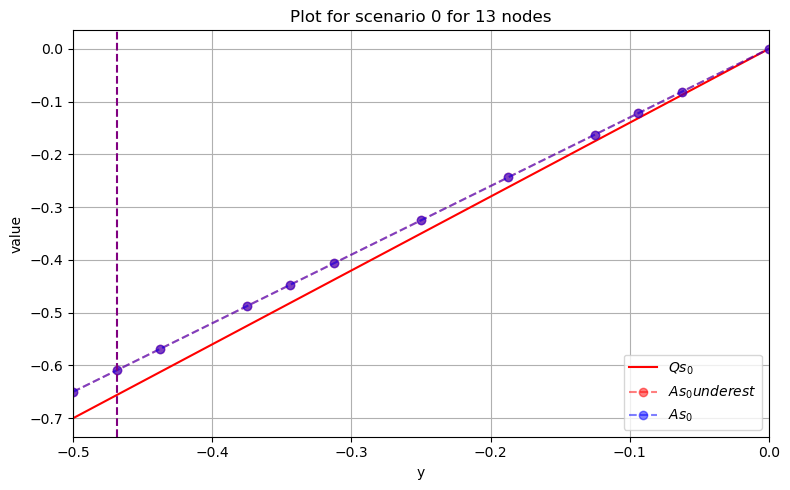

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.03125
ms is  -0.0009765625


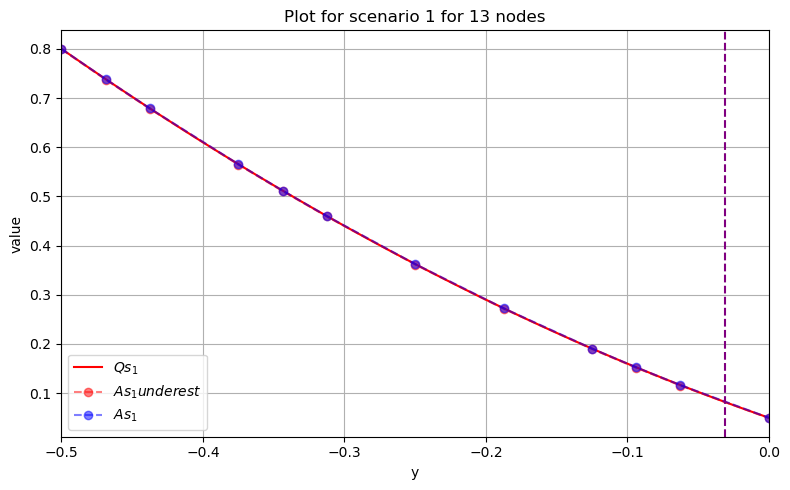

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


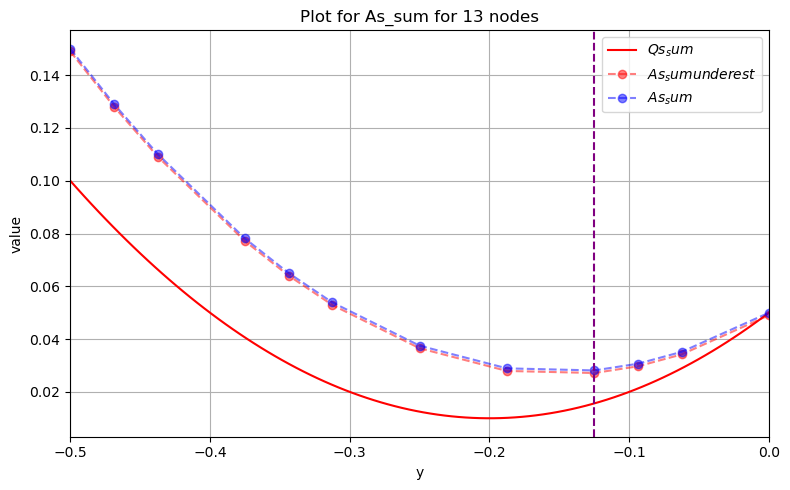

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.03125
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


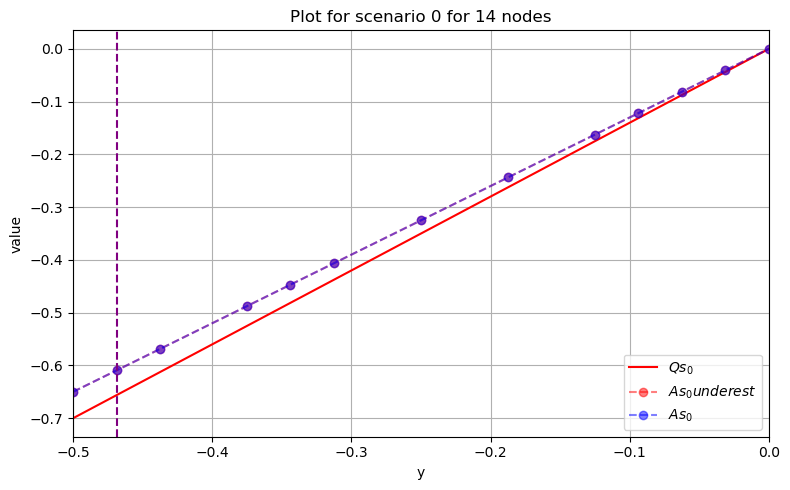

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.4062499999999999
ms is  -0.0009765625


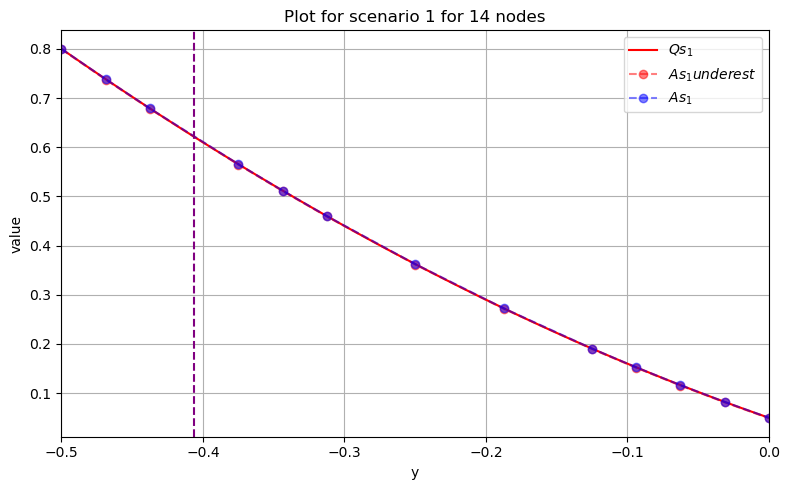

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


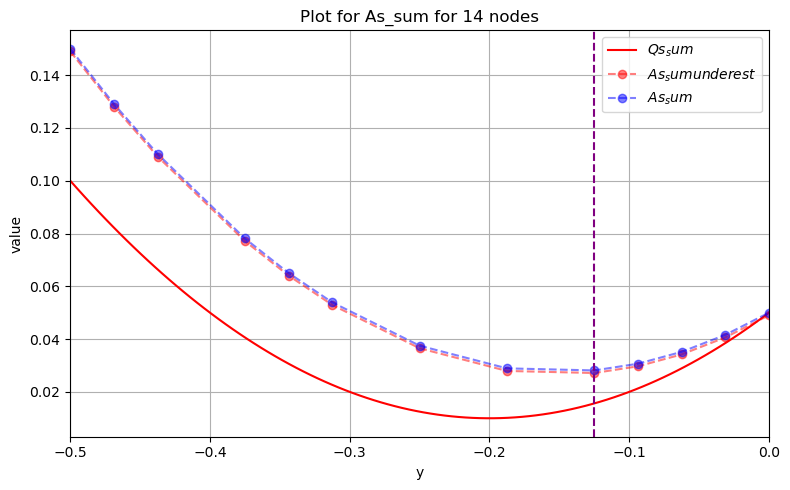

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.4062499999999999
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  15
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


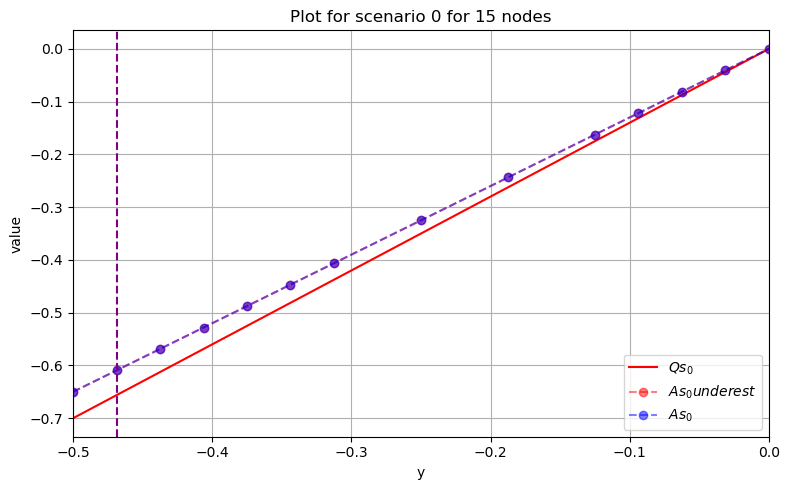

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.15625
ms is  -0.0009765625


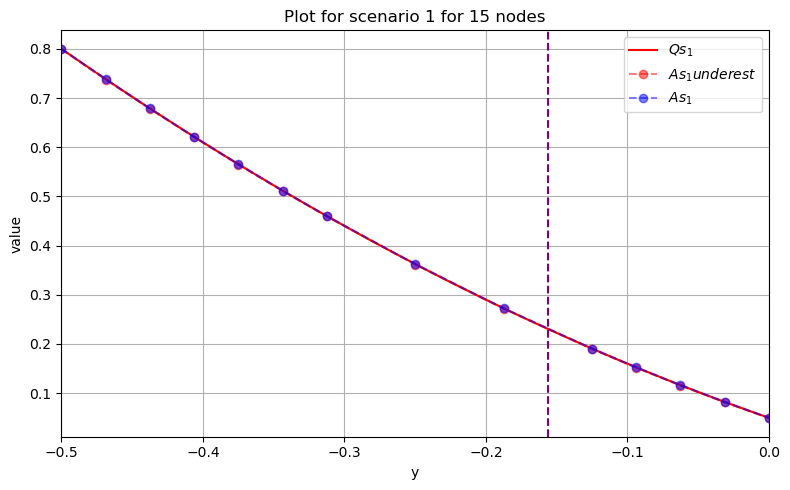

 
The plot for As_sum
The potential y_star is  -0.125
error is  0.0


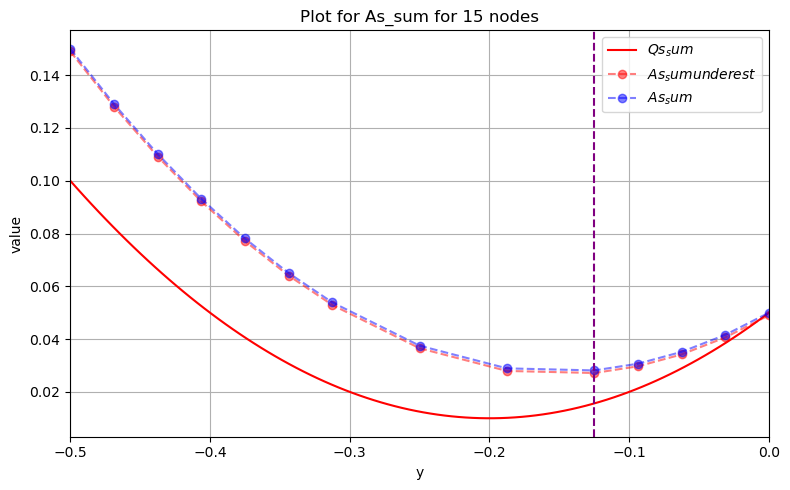

Sum *****************************************
error at y_star is  0.0
y_star is  -0.125
ms_list and sum_ms is  [0.0, -0.0009765625] -0.0009765625
new node choosen from ms
new node is -0.15625
Current As_min is 0.027148437499999983
*****************************************

##################################################
##################################################
Start adding node  16
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


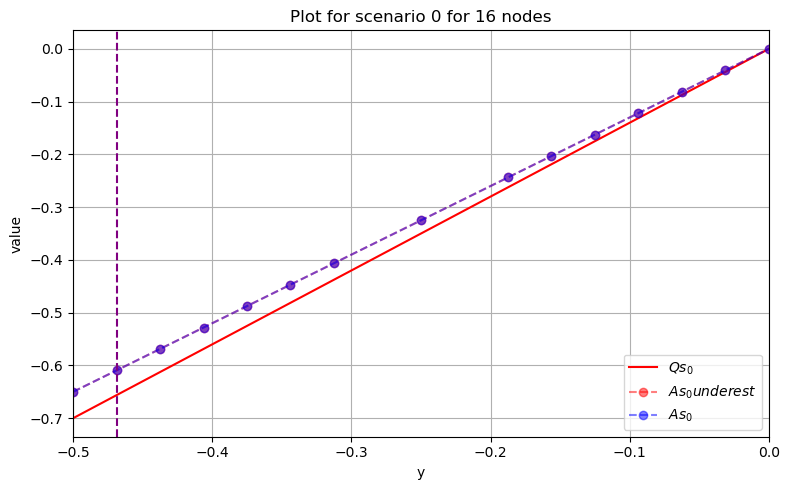

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.2187499999999999
ms is  -0.0009765624999999445


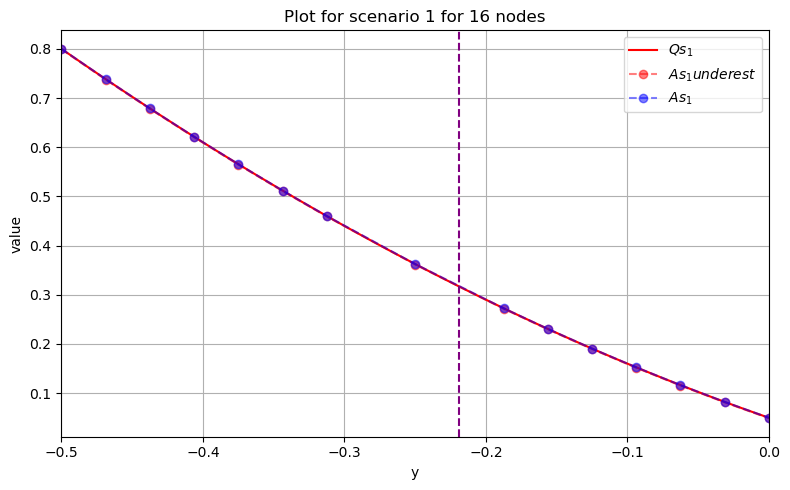

 
The plot for As_sum
The potential y_star is  -0.15625
error is  0.0


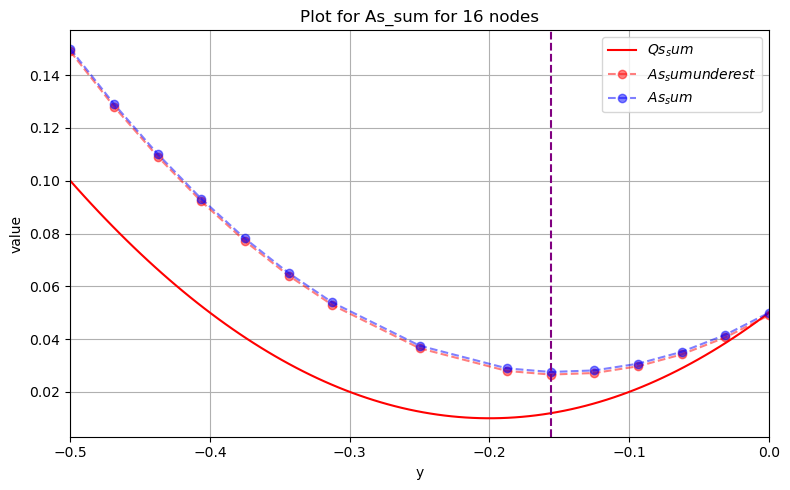

Sum *****************************************
error at y_star is  0.0
y_star is  -0.15625
ms_list and sum_ms is  [0.0, -0.0009765624999999445] -0.0009765624999999445
new node choosen from ms
new node is -0.2187499999999999
Current As_min is 0.026562500000000044
*****************************************

##################################################
##################################################
Start adding node  17
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


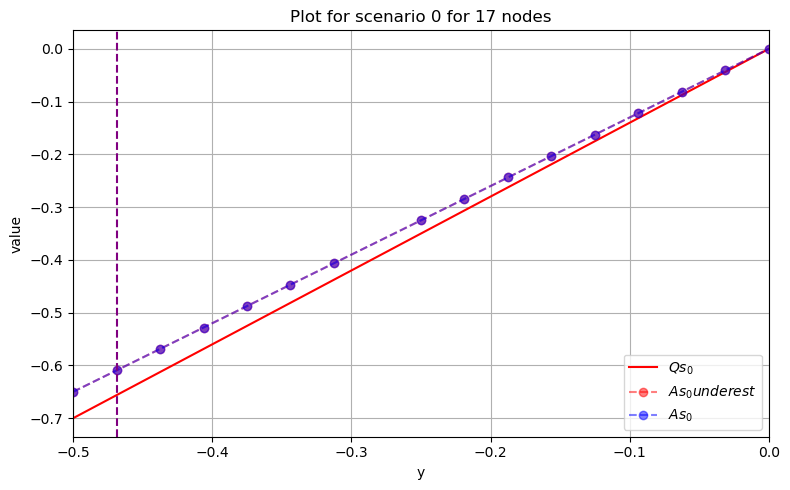

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.28124999999999956
ms is  -0.0009765624999999445


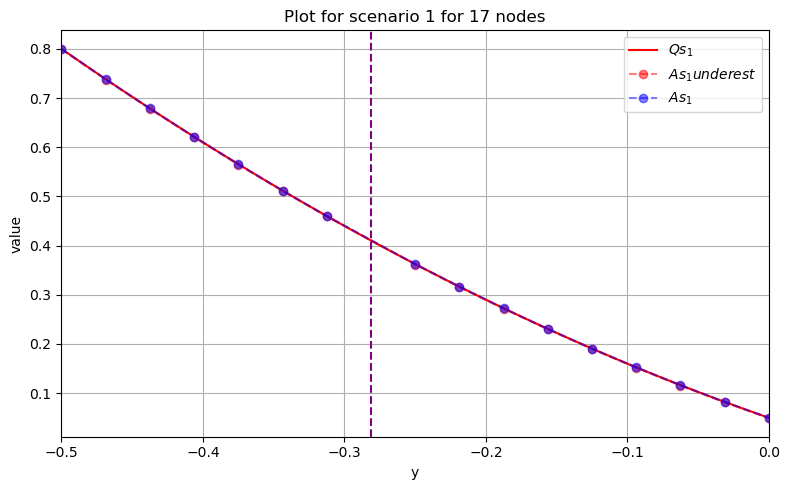

 
The plot for As_sum
The potential y_star is  -0.15625
error is  0.0


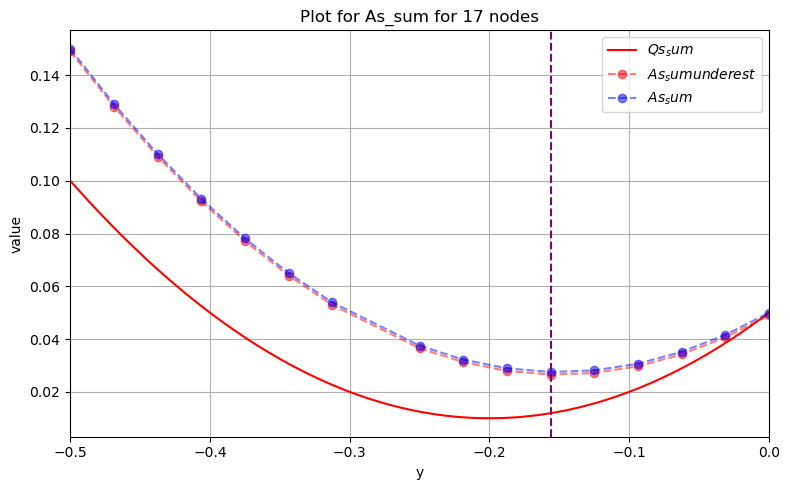

Sum *****************************************
error at y_star is  0.0
y_star is  -0.15625
ms_list and sum_ms is  [0.0, -0.0009765624999999445] -0.0009765624999999445
new node choosen from ms
new node is -0.28124999999999956
Current As_min is 0.026562500000000044
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.4687499999999999
ms is  0.0


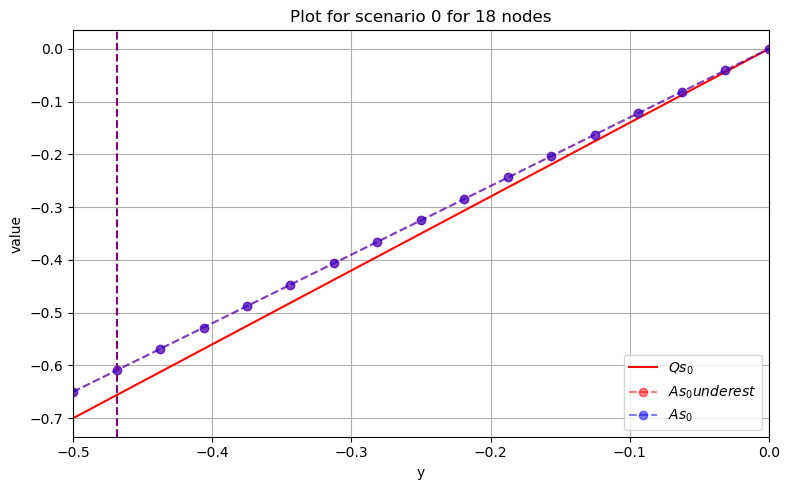

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.48437500000000044
ms is  -0.000244140625


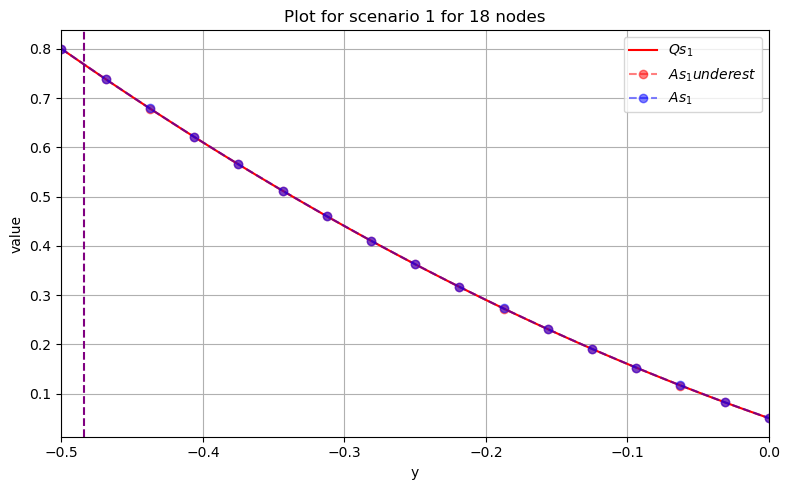

 
The plot for As_sum
The potential y_star is  -0.15625
error is  0.0


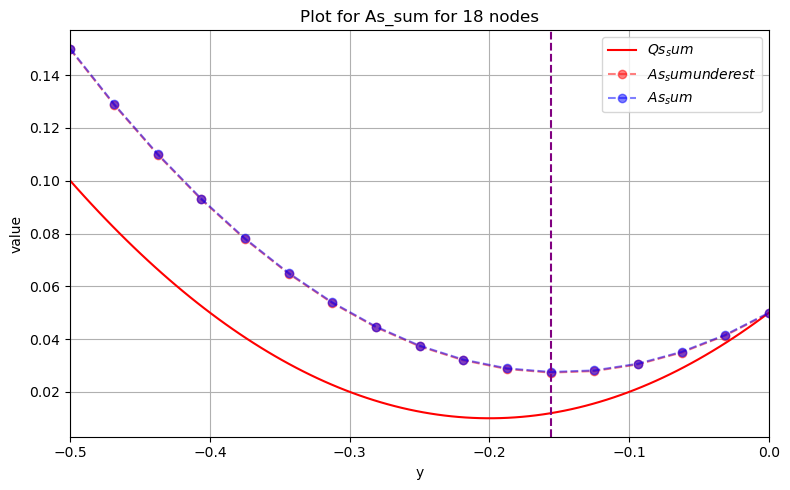

Sum *****************************************
error at y_star is  0.0
y_star is  -0.15625
ms_list and sum_ms is  [0.0, -0.000244140625] -0.000244140625
new node choosen from ms
new node is -0.48437500000000044
Current As_min is 0.02729492187499999
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.48437500000000044
ms is  0.0


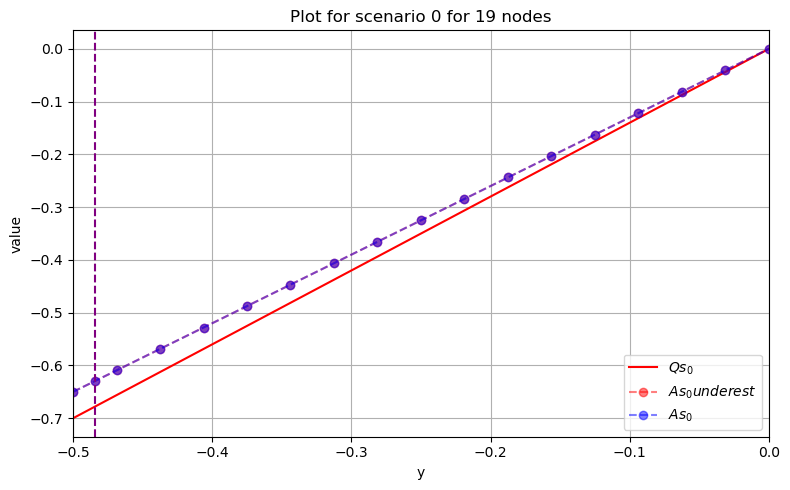

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.046875
ms is  -0.000244140625


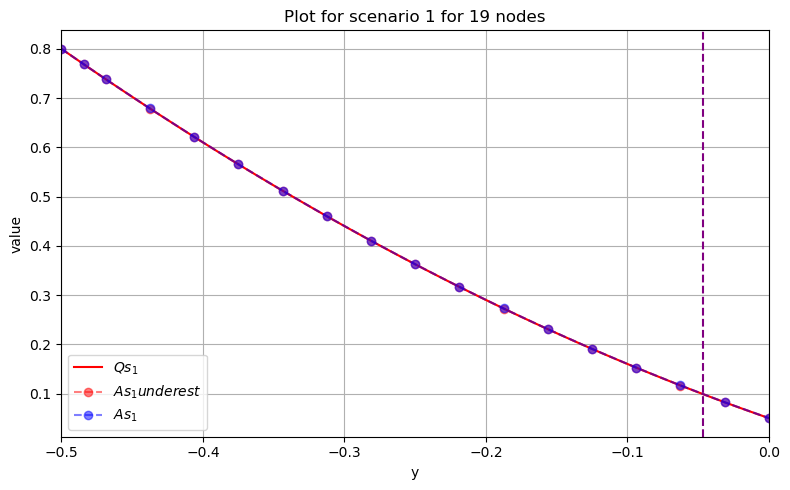

 
The plot for As_sum
The potential y_star is  -0.15625
error is  0.0


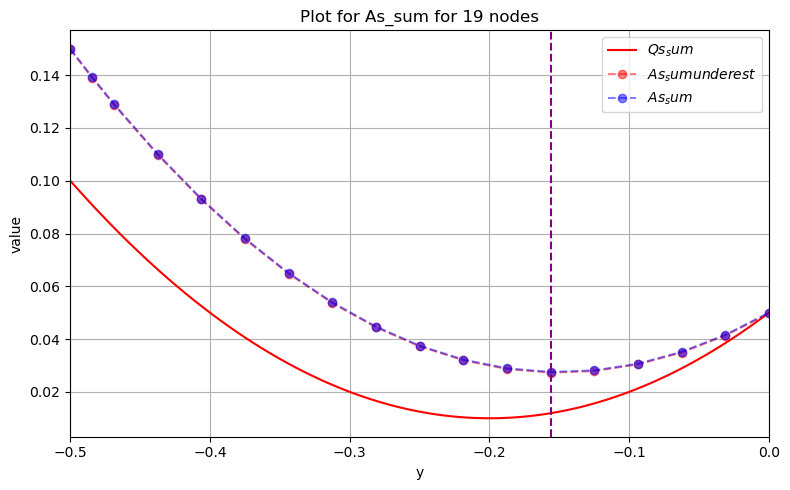

Sum *****************************************
error at y_star is  0.0
y_star is  -0.15625
ms_list and sum_ms is  [0.0, -0.000244140625] -0.000244140625
new node choosen from ms
new node is -0.046875
Current As_min is 0.02729492187499999
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
 
The plot for scenario  0
The potential y_star is  -0.48437500000000044
ms is  0.0


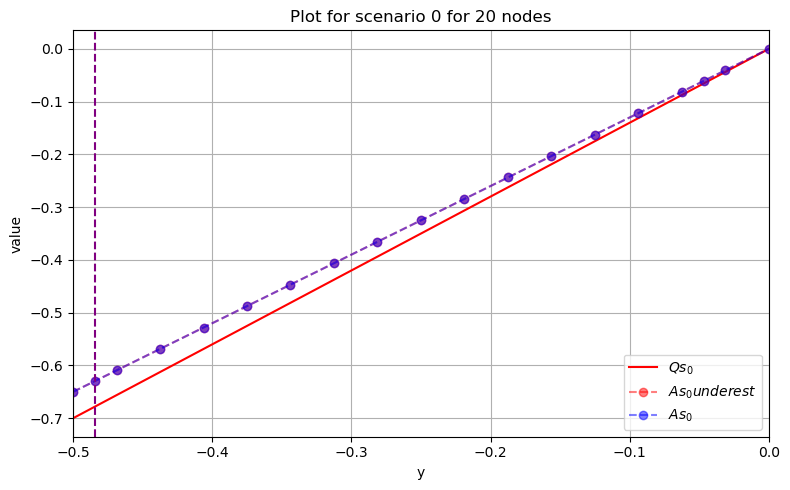

 
Solving scenario  1
 
The plot for scenario  1
The potential y_star is  -0.015625
ms is  -0.000244140625


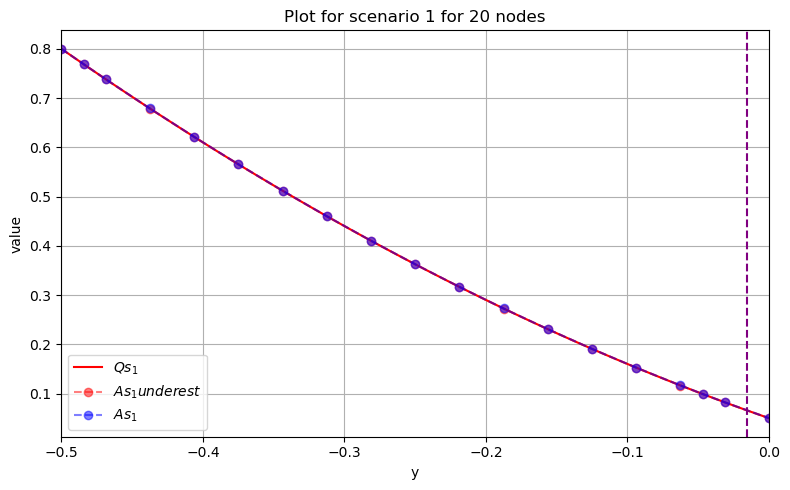

 
The plot for As_sum
The potential y_star is  -0.15625
error is  0.0


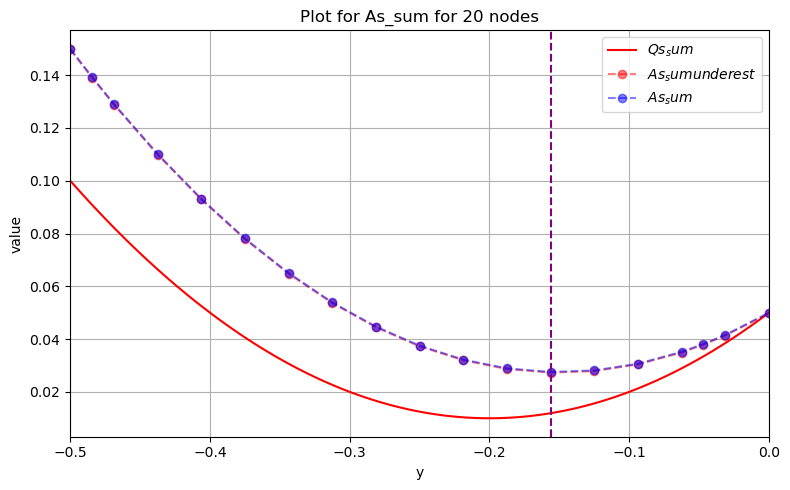

Sum *****************************************
error at y_star is  0.0
y_star is  -0.15625
ms_list and sum_ms is  [0.0, -0.000244140625] -0.000244140625
new node choosen from ms
new node is -0.015625
Current As_min is 0.02729492187499999
*****************************************



In [82]:
result = nc_underest([ylb, yub],model_list,20,True, v_list)

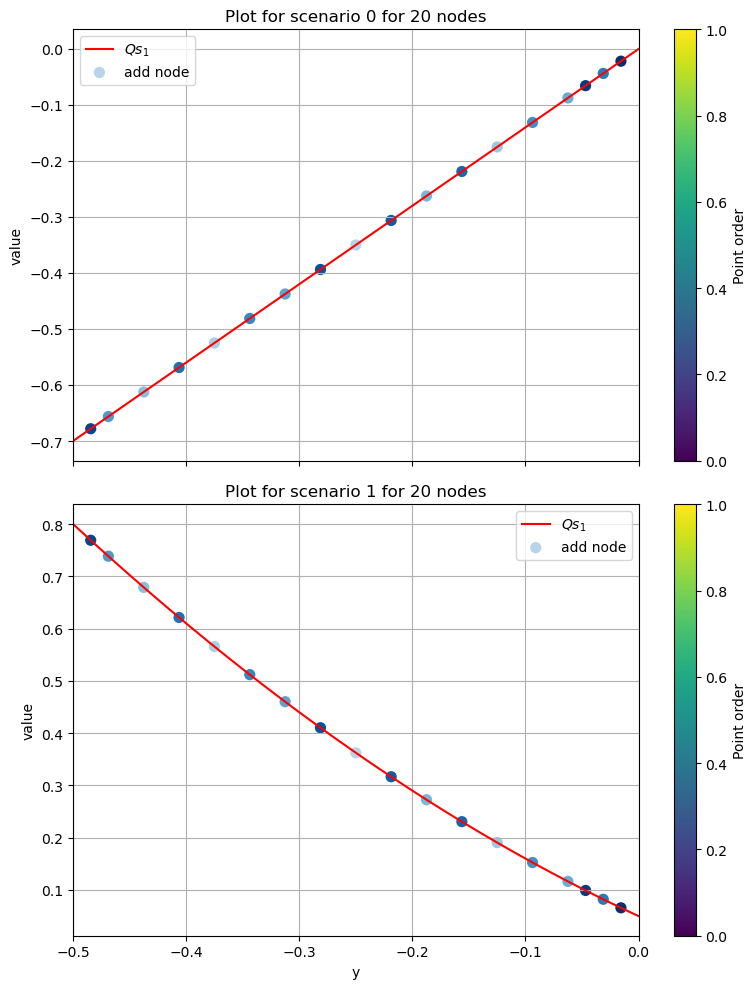

In [83]:
y_vals = np.linspace(ylb, yub, 501)
N = 2
Qs_vals_list = [None] * N
for i in range(N):
    Qs_vals_list[i] = [v_list[i](y) for y in y_vals]
Qs_arr = np.array(Qs_vals_list, dtype=float, ndmin=2)  
Qs_vals_sum = Qs_arr.sum(axis=0)




adds = result[-1][0]
add_node_history = result[-1][2]
v1_node = [v_list[0](y) for y in add_node_history]
v2_node = [v_list[1](y) for y in add_node_history]
#colors = plt.cm.viridis(np.linspace(0, 1, len(add_node_history)))
colors = plt.cm.Blues(np.linspace(0.3, 1, len(add_node_history)))



fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=False)
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap)
axes[0].plot(y_vals, Qs_vals_list[0], label=fr'$Qs_{i}$', color='red')
sc0 = axes[0].scatter(add_node_history, v1_node, c=colors, s=50, label='add node')
axes[0].set_xlim(ylb, yub)
axes[0].set_ylabel('value')
axes[0].set_title("Plot for scenario 0 for 20 nodes")
axes[0].legend()
axes[0].grid(True)
fig.colorbar(sm, ax=axes[0], label='Point order')
axes[1].plot(y_vals, Qs_vals_list[1], label=fr'$Qs_{i}$', color='red')
sc1 = axes[1].scatter(add_node_history, v2_node, c=colors, s=50, label='add node')
axes[1].set_xlim(ylb, yub)
axes[1].set_xlabel('y')
axes[1].set_ylabel('value')
axes[1].set_title("Plot for scenario 1 for 20 nodes")
axes[1].legend()
axes[1].grid(True)
fig.colorbar(sm, ax=axes[1], label='Point order')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


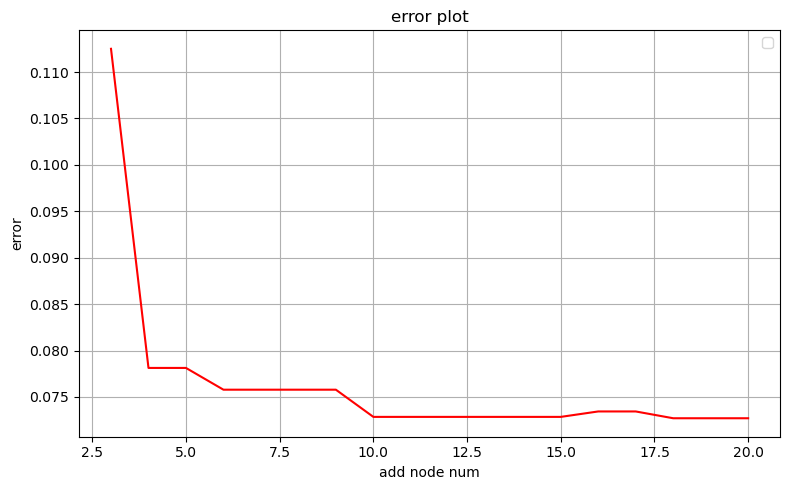

      adds     errors
----------------------
         3 0.112500000000
         4 0.078125000000
         5 0.078125000000
         6 0.075781250000
         7 0.075781250000
         8 0.075781250000
         9 0.075781250000
        10 0.072851562500
        11 0.072851562500
        12 0.072851562500
        13 0.072851562500
        14 0.072851562500
        15 0.072851562500
        16 0.073437500000
        17 0.073437500000
        18 0.072705078125
        19 0.072705078125
        20 0.072705078125


In [79]:
adds = result[-1][0]
true_min_val = 0.1
plt.figure(figsize=(8, 5))
errors = [true_min_val-item for item in result[-1][1]]
plt.plot(adds, errors, color='red')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(adds, errors):
    print(f"{a:>10} {e:>10.12f}")

In [84]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 
    
# ========== Solve Lagrangian relaxation once ==========
def solve_lagrangian_once(model_list: List[ConcreteModel], lambdas: List[float]):
    xs, objs = [], []
    N = len(model_list)
    for n, m in enumerate(model_list):
        if hasattr(m, 'obj'):
            m.del_component(m.obj)
        lag_term = (lambdas[n+1]-lambdas[n]) * m.y
        m.obj = Objective(expr = m.obj_expr + lag_term, sense=minimize)
        solver.solve(m, tee=False)
        xs.append(value(m.y))
        objs.append(value(m.obj))
    return xs, objs, sum(objs)

# ========== subgradient lambda update ==========
def subgradient_update(
    lambdas: list[float],
    xs: list[float],                       
    zUB: float,
    zLB: float,
    alpha_fac: float = 0.5           
) -> list[float]:
    """
    g_n = x^n - x^{n+1},  n=1,...,N-1
    t = α * (zUB - zLB) / ||g||^2
    """
    N = len(xs)
    g = [xs[n] - xs[n+1] for n in range(N-1)]
    g2 = sum(gi*gi for gi in g)
    if g2 <= 1e-16:
        return lambdas[:]
    t = alpha_fac * max(0.0, zUB - zLB) / g2
    
    new_lambdas = [0]
    for i, lam in enumerate(lambdas):
        if 1<=i<=(N-1):
            new_lambdas.append(lam + t * g[i-1]) 
    new_lambdas.append(0)
    '''
    new_lambdas = lambdas
    new_lambdas[1] = lambdas[1] + t * g[0]
    '''
    print('zUB is ',zUB)
    print('zLB is ',zLB)
    print('g2 is ',g2)
    return new_lambdas

# ========== evaluate upper bound ==========
def compute_upper_bound(
    model_list: List[ConcreteModel],
    xs: list
) -> float:
    """
    use mean value of xs to evaluate a upper bound
    """
    x_bar = np.mean(xs)
    print('x_bar is ',x_bar)
    objss = []
    N = len(model_list)
    for n, m in enumerate(model_list):
        if hasattr(m, 'obj'):
            m.del_component(m.obj)
        m.obj = Objective(expr = m.obj_expr, sense=minimize)
        m.y.fix(x_bar)
        solver.solve(m, tee=False)
        objss.append(value(m.obj))
        m.y.unfix()
    zUB = sum(objss)
    return zUB

# ========== main loop ==========
def lagrangian_loop(model_list: List[ConcreteModel],
                    max_iter: int = 20,
                    alpha_fac: float = 0.5,
                    lam0: List[float] = None):
    N = len(model_list)
    lambdas = lam0 if lam0 is not None else [0.0]*(N+1)
    history = []
    for k in range(max_iter):
        print('=====')
        xs, objs, zLB = solve_lagrangian_once(model_list, lambdas)
        zUB = compute_upper_bound(model_list,xs)
        history.append((k, zLB, xs, lambdas[:]))
        print(f"iter {k:02d}: zLB={zLB:.6f}, xs={['%.4f'%x for x in xs]}, λ={['%.3f'%l for l in lambdas]}")
        print('objs is ',objs)
        print('lower bound is ',sum(objs))
        lambdas = subgradient_update(lambdas, xs, zUB, zLB, alpha_fac)
    return history

=====
x_bar is  -0.25
iter 00: zLB=-0.600000, xs=['-0.5000', '0.0000'], λ=['0.000', '0.000', '0.000']
objs is  [-0.65, 0.04999999999999999]
lower bound is  -0.6000000000000001
zUB is  0.03749999999999998
zLB is  -0.6000000000000001
g2 is  0.25
=====
x_bar is  -0.25
iter 01: zLB=-0.281250, xs=['-0.5000', '0.0000'], λ=['0.000', '-0.638', '0.000']
objs is  [-0.33125, 0.04999999999999999]
lower bound is  -0.28125
zUB is  0.03749999999999998
zLB is  -0.28125
g2 is  0.25
=====
x_bar is  -0.25
iter 02: zLB=-0.121875, xs=['-0.5000', '0.0000'], λ=['0.000', '-0.956', '0.000']
objs is  [-0.171875, 0.04999999999999999]
lower bound is  -0.12187500000000001
zUB is  0.03749999999999998
zLB is  -0.12187500000000001
g2 is  0.25
=====
x_bar is  -0.27890625
iter 03: zLB=-0.045530, xs=['-0.5000', '-0.0578'], λ=['0.000', '-1.116', '0.000']
objs is  [-0.09218749999999998, 0.04665771484374999]
lower bound is  -0.04552978515624999
zUB is  0.04411682128906247
zLB is  -0.04552978515624999
g2 is  0.1955297851562

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iter 09: zLB=0.022238, xs=['0.0000', '-0.1666'], λ=['0.000', '-1.333', '0.000']
objs is  [0.0, 0.02223803897034249]
lower bound is  0.02223803897034249
zUB is  0.03194760880754355
zLB is  0.02223803897034249
g2 is  0.027761961029657528


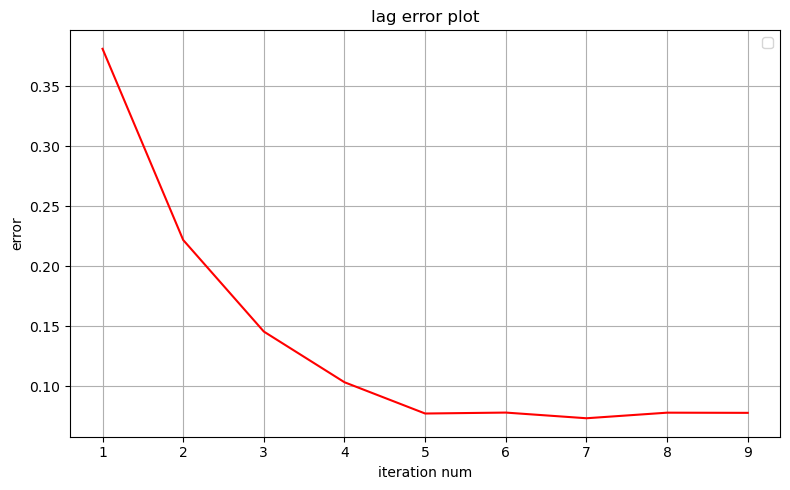

      adds     errors
----------------------
         0 0.700000000000
         1 0.381250000000
         2 0.221875000000
         3 0.145529785156
         4 0.103275308609
         5 0.077205596305
         6 0.077988280123
         7 0.073261336152
         8 0.077909792911
         9 0.077761961030


In [90]:
# build function for each scenario
def v_1(y):  
    return 1.4*y

def v_2(y): 
    return (y-0.5)**2-0.2
# in this case, min is at y=-0.2, obj = 0.01
v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.5
yub = 0
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y)
m1.obj_expr = Expression(expr=1.3*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == (m2.y-0.5)**2)
m2.obj_expr = Expression(expr=m2.x2-0.2)

model_list = [m1, m2]


lam0 = [0,0, 0]
lag_history = lagrangian_loop(model_list, max_iter=10, alpha_fac=0.5, lam0=lam0)
lag_iter = range(10)
lag_min = [lag_history[i][1] for i in range(len(lag_history))]
# plot
true_min_val = 0.1
plt.figure(figsize=(8, 5))
lag_errors = [true_min_val-item for item in lag_min]
plt.plot(lag_iter[1:], lag_errors[1:], color='red')
plt.xlabel('iteration num')
plt.ylabel('error')
plt.title(f"lag error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(lag_iter, lag_errors):
    print(f"{a:>10} {e:>10.12f}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


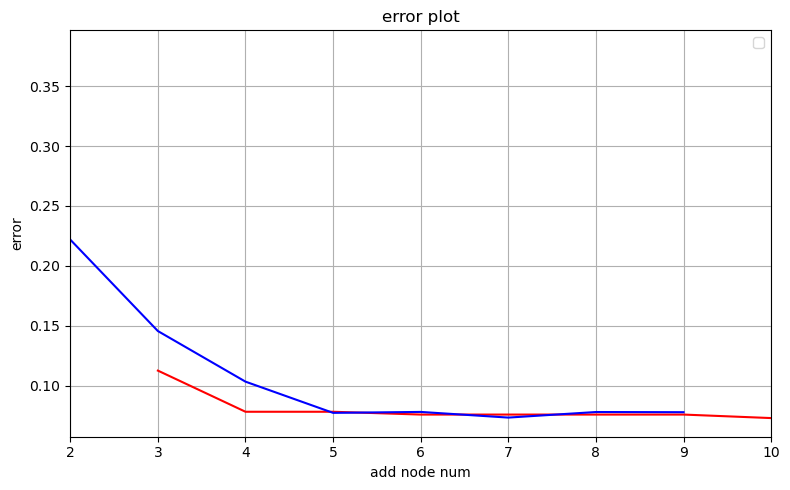

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(adds, errors, color='red')
plt.plot(lag_iter[1:], lag_errors[1:], color='blue')
plt.xlim([2,10])
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
d_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5]
e_list = []
for d in d_list:
    result = nc_underest([-d, d],model_list,30,False, v_list)
    e_list.append(-result[1])

WARNING (W1002): Setting Var 'y' to a numeric value `-1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'y' to a numeric value `1` outside the bounds
(-1e-05, 1e-05).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
The goal is to get  30  nodes
##################################################
##################################################
Start adding node  3
 
Solving scenario  0
*****************************************
error at y_star is  0.5
y_star is  0.0
ms_list and sum_ms is  [-0.5] 0.5
new node choosen from ms
new node is -0.0
*****************************************

##################################################
##################################################
Start adding node  4
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.125] 0.125
new node choosen from ms
new node is

##################################################
##################################################
Start adding node  25
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is -0.6875
*****************************************

##################################################
##################################################
Start adding node  26
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.001953125
new node choosen from ms
new node is 0.6875
*****************************************

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-0.001953125] 0.0019

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531249999999584e-05] 1.9531249999999584e-05
new node choosen from ms
new node is -0.09375000000000004
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.9531250000000017e-05] 1.9531250000000017e-05
new node choosen from ms
new node is 0.08125000000000006
*****************************************

##################################################
##################################################
Start adding node  20
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125000000045e-05] 1.953125000000045e-05
new node choosen from ms
new node is 0.09375000000

##################################################
##################################################
Start adding node  12
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.81250000000002e-07] 7.81250000000002e-07
new node choosen from ms
new node is 0.008749999999999999
*****************************************

##################################################
##################################################
Start adding node  13
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-7.812500000000004e-07] 7.812500000000004e-07
new node choosen from ms
new node is -0.0037500000000000003
*****************************************

##################################################
##################################################
Start adding node  14
 
Solving scenario  0
*****************************************
error at y_star 

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.25e-07] 1.25e-07
new node choosen from ms
new node is 0.0005
*****************************************

##################################################
##################################################
Start adding node  6
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.1249999999999965e-08] 3.1249999999999965e-08
new node choosen from ms
new node is -0.00075
*****************************************

##################################################
##################################################
Start adding node  7
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-3.125e-08] 3.125e-08
new node choosen from ms
new node is 0.00025
*****************************************

#########################################

##################################################
##################################################
Start adding node  27
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953125e-09] 1.953125e-09
new node choosen from ms
new node is 6.25e-05
*****************************************

##################################################
##################################################
Start adding node  28
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [-1.953124999999998e-09] 1.953124999999998e-09
new node choosen from ms
new node is -0.0001875
*****************************************

##################################################
##################################################
Start adding node  29
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_m

*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  22
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##################################################
Start adding node  23
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  -5e-05
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is -0.0001
*****************************************

##################################################
##########################################

*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  18
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding node  19
 
Solving scenario  0
*****************************************
error at y_star is  0.0
y_star is  0.0
ms_list and sum_ms is  [0.0] 0.0
new node choosen from ms
new node is 0.0
*****************************************

##################################################
##################################################
Start adding

C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
C:\Users\pc\AppData\Local\Temp\ipykernel_116288\4161946405.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(d_list), np.log(e_list), color='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


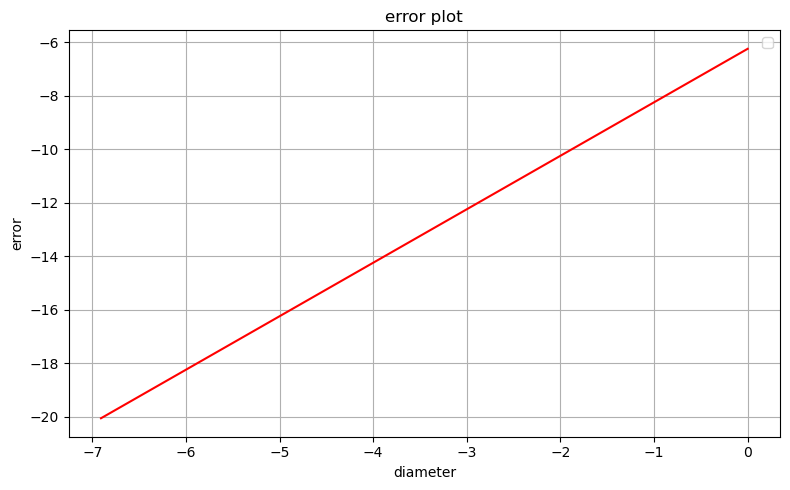

  diameter     errors
----------------------
         1 0.0019531250000000
       0.1 0.0000195312500000
      0.01 0.0000001953125000
     0.001 0.0000000019531250
    0.0001 -0.0000000012500000
     1e-05 -0.0000000000000000


In [29]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(d_list), np.log(e_list), color='red')
plt.xlabel('diameter')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'diameter':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(d_list, e_list):
    print(f"{a:>10} {e:>10.16f}")